# Assignment 2 specification

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as a zip file.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.
4. Which of the 3 target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and pandas filtering by rows  convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest prediction accuracy on the test set? Why is this? __[5 marks]__

# Task 1: Read the _hourly_ data and split into training and test data. #


## Start of Answer 1 ##

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Personal Imports
from helper_methods import analyse_discrete_numerical
from helper_methods import analyse_continous_numerical
from helper_methods import print_side_by_side
from helper_methods import correlate_discrete_continous
from helper_methods import correlate_continous_numeric
from helper_methods import correlate_feature_target_discrete
from helper_methods import correlate_feature_target_continous
from helper_methods import calculatePredictors
from helper_methods import calculateDegrees
from helper_methods import calculatePolynomialScore

Read in the bike sharing data

In [2]:
bikeSharing = pd.read_csv("Bike-Sharing-Dataset/hour.csv")
bikeSharing.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

Split the data into training and testing subsets.

In [3]:
trainBikes, testBikes = train_test_split(bikeSharing, test_size=0.2)

## End of Answer 1 ##

# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model #

## Start of Answer 2 ##

### Pass 1 ###

#### Feature Dtype Conversion ####

The dataframe could have invalid types for certain features and if that is the case, they need to be fixed.

In [4]:
trainBikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 15643 to 13804
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     13903 non-null  int64  
 1   dteday      13903 non-null  object 
 2   season      13903 non-null  int64  
 3   yr          13903 non-null  int64  
 4   mnth        13903 non-null  int64  
 5   hr          13903 non-null  int64  
 6   holiday     13903 non-null  int64  
 7   weekday     13903 non-null  int64  
 8   workingday  13903 non-null  int64  
 9   weathersit  13903 non-null  int64  
 10  temp        13903 non-null  float64
 11  atemp       13903 non-null  float64
 12  hum         13903 non-null  float64
 13  windspeed   13903 non-null  float64
 14  casual      13903 non-null  int64  
 15  registered  13903 non-null  int64  
 16  cnt         13903 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 1.9+ MB


Since the "dteday" feature is currently an Object, it will be converted to a datetime object

In [5]:
trainBikes.dteday = pd.to_datetime(trainBikes.dteday)

The dataframe should now be all the right Dtypes.

In [6]:
trainBikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 15643 to 13804
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     13903 non-null  int64         
 1   dteday      13903 non-null  datetime64[ns]
 2   season      13903 non-null  int64         
 3   yr          13903 non-null  int64         
 4   mnth        13903 non-null  int64         
 5   hr          13903 non-null  int64         
 6   holiday     13903 non-null  int64         
 7   weekday     13903 non-null  int64         
 8   workingday  13903 non-null  int64         
 9   weathersit  13903 non-null  int64         
 10  temp        13903 non-null  float64       
 11  atemp       13903 non-null  float64       
 12  hum         13903 non-null  float64       
 13  windspeed   13903 non-null  float64       
 14  casual      13903 non-null  int64         
 15  registered  13903 non-null  int64         
 16  cnt         13903 

#### Analysing the DataFrame for Redundant Features ####

Using the information provided in the introduction to this assignment,
i.e., https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset
Certain features can be dropped due to being redundant

"instant" is a 1 indexed version of the already existing pandas index, and as such can be dropped

In [7]:
trainBikes.drop(columns="instant", inplace=True)

"dteday" contains the full date of each entry. This is a feature with a high varience of entries and is already covered by the combination of "yr" and "mnth" features.
Because of this, it can be dropped.

In [8]:
trainBikes.drop(columns="dteday", inplace=True)

"season" contains the season[1:4] that each entry took place in, this information is already covered by mnth and is seemingly incorrect,
with multiple entries for season 1 (presumingly Winter) taking place in mnth 3 (presumingly March, based on dteday),
where they should have changed over to season 2 by then. Because of this, it can be dropped.

In [9]:
trainBikes.drop(columns="season", inplace=True)

"temp" and "atemp" seem to have very similar values and could be redundant, but further investigation is needed first.

In [10]:
trainBikes[["temp", "atemp"]].corr()

temp     atemp
temp   1.000000  0.987701
atemp  0.987701  1.000000

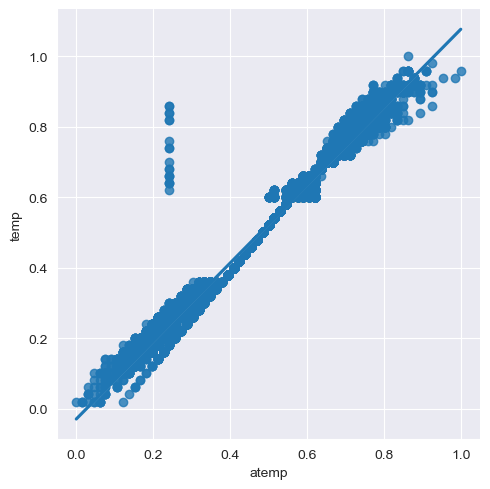

In [11]:
sns.lmplot(data=trainBikes, x="atemp", y="temp")

From the pearson correlation and lmplot it is very visible that atemp and temp have a near perfect linear correlation.
Because of this, both will be compared to the target, count, and the weaker one will be dropped.

In [12]:
trainBikes[["cnt", "temp", "atemp"]].corr()

cnt      temp     atemp
cnt    1.000000  0.406309  0.403539
temp   0.406309  1.000000  0.987701
atemp  0.403539  0.987701  1.000000

From the pearson correlation, it can be estimated that temp is stronger than atemp and as such atemp will be dropped.

In [13]:
trainBikes.drop(columns="atemp", inplace=True)

There could still be some redundant features left but nothing obvious and as such the remaining features will all be analysed fully.
This is the new, less redundant dataframe.

In [14]:
trainBikes.head()

yr  mnth  hr  holiday  weekday  workingday  weathersit  temp   hum  \
15643   1    10   0        0        5           1           2  0.56  0.83   
17264   1    12   5        0        4           1           1  0.24  0.75   
4291    0     7  17        0        6           0           1  0.84  0.30   
1009    0     2  17        0        1           1           1  0.46  0.33   
13404   1     7  17        0        2           1           1  0.92  0.29   

       windspeed  casual  registered  cnt  
15643     0.1045       5          51   56  
17264     0.1642       1          10   11  
4291      0.2239     179         170  349  
1009      0.6119      25         218  243  
13404     0.0000      95         675  770

#### Check for na's and fix if any ####

In [15]:
trainBikes.isna().sum()

yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

No na's to fix.

### Pass 2 ###

#### Feature: yr ####
Investigate the yr feature.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         0.503704		Int64Index: 13903 entries, 15643 to 13804
std          0.500004		Series name: yr
min          0.000000		Non-Null Count  Dtype
25%          0.000000		--------------  -----
50%          1.000000		13903 non-null  int64
75%          1.000000		dtypes: int64(1)
max          1.000000		memory usage: 217.2 KB




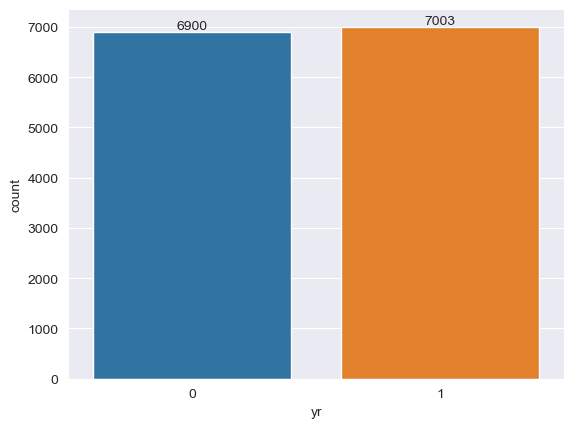

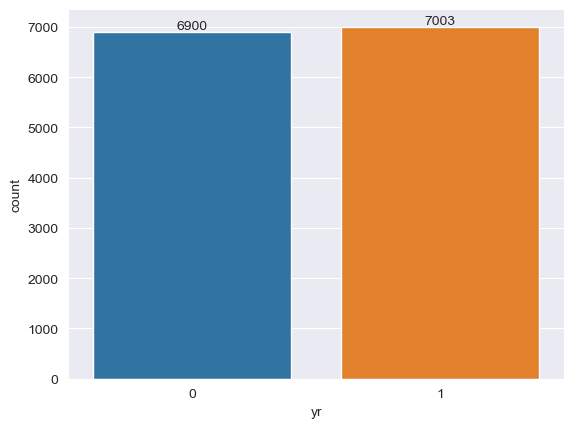

In [16]:
analyse_discrete_numerical(trainBikes, trainBikes.yr)

**yr Findings:**
- Near identical amount of entries for each year

The near identical count of entries is most likely because the data was recorded for every hour of every day of each year.
This is most likely due to the lack of data that was split off into bikesTest.
This also implies that there isn't a need to further investigate feature:feature correlation here.

#### Feature: mnth ####
Investigate the mnth feature.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         6.537222		Int64Index: 13903 entries, 15643 to 13804
std          3.442464		Series name: mnth
min          1.000000		Non-Null Count  Dtype
25%          4.000000		--------------  -----
50%          7.000000		13903 non-null  int64
75%         10.000000		dtypes: int64(1)
max         12.000000		memory usage: 217.2 KB




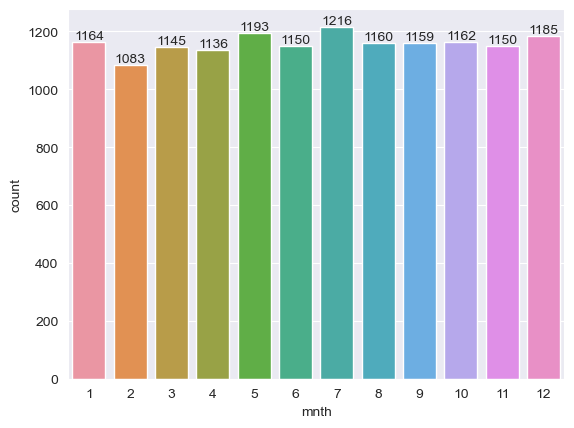

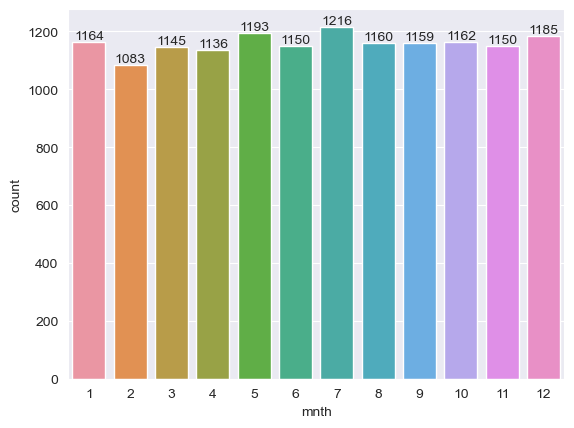

In [17]:
analyse_discrete_numerical(trainBikes, trainBikes.mnth)

**mnth Findings:**
- very similar amount of entries per month

The entry count similarity is most likely due to the same reason as the identical count for yr.
Data was recorded on an hourly basis and as such the amount of entries is similar.
The difference in amount is most likely due to the varying amounts of days in each month.
Another likely cause is the lack of data that was split off into bikesTest.
Because of this, no further feature:feature investigation is needed.

#### Feature: hr ####
Investigate the hr feature.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean        11.559951		Int64Index: 13903 entries, 15643 to 13804
std          6.908343		Series name: hr
min          0.000000		Non-Null Count  Dtype
25%          6.000000		--------------  -----
50%         12.000000		13903 non-null  int64
75%         18.000000		dtypes: int64(1)
max         23.000000		memory usage: 217.2 KB




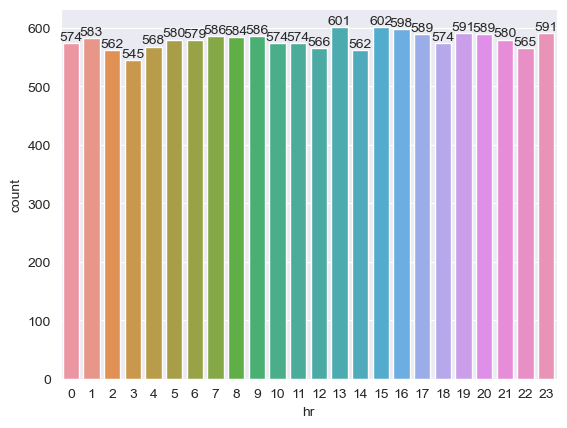

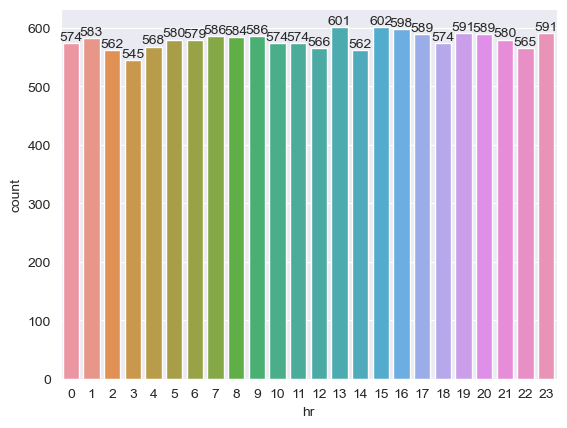

In [18]:
analyse_discrete_numerical(trainBikes, trainBikes.hr)

**hr Findings:**
- count of entries is fairly similar across the board

The similar count is once again due to the same reason as mnth and yr.
However, there is some more significant difference in hr compared to mnth and yr,
this is most likely due to no one using a bike at those times and this relationship will be investigated in Pass 3.
Another likely cause is the lack of data that was split off into bikesTest.
No further feature:feature correlation investigation needed.

#### Feature: holiday ####
Investigate the holiday feature.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         0.028987		Int64Index: 13903 entries, 15643 to 13804
std          0.167775		Series name: holiday
min          0.000000		Non-Null Count  Dtype
25%          0.000000		--------------  -----
50%          0.000000		13903 non-null  int64
75%          0.000000		dtypes: int64(1)
max          1.000000		memory usage: 217.2 KB




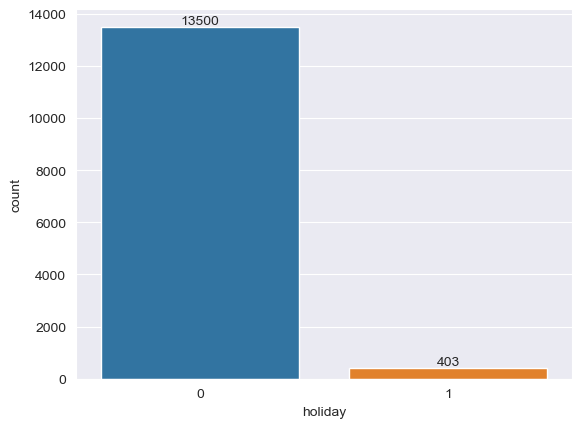

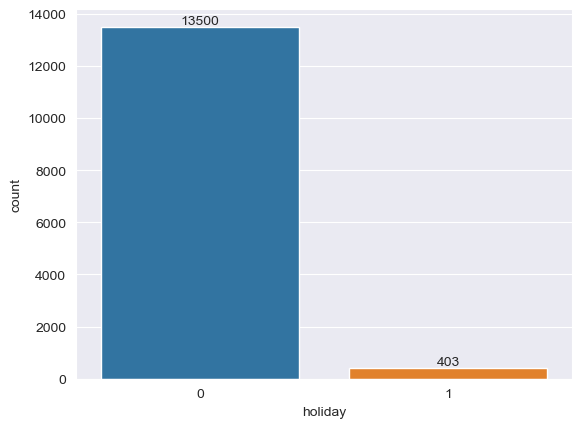

In [19]:
analyse_discrete_numerical(trainBikes, trainBikes.holiday)

**holiday Findings:**
- Much more entries for non-holidays than holiday days

This is the expected result as holiday eligible days are far and few inbetween,
as such, there ca only be so many entries for holiday days.
No further feature:feature correlation investigation needed.

#### Feature: weekday ####
Investigate the weekday feature.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         2.994534		Int64Index: 13903 entries, 15643 to 13804
std          2.004483		Series name: weekday
min          0.000000		Non-Null Count  Dtype
25%          1.000000		--------------  -----
50%          3.000000		13903 non-null  int64
75%          5.000000		dtypes: int64(1)
max          6.000000		memory usage: 217.2 KB




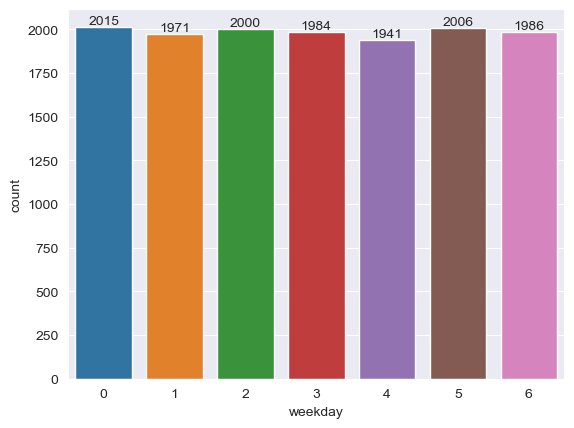

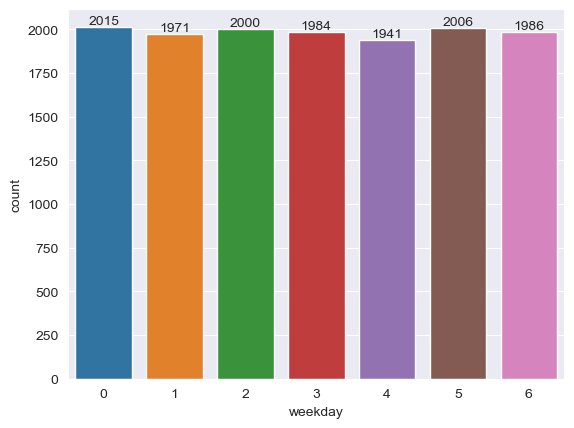

In [20]:
analyse_discrete_numerical(trainBikes, trainBikes.weekday)

#### Feature: workingday ####
Investigate the workingday feature.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         0.683234		Int64Index: 13903 entries, 15643 to 13804
std          0.465232		Series name: workingday
min          0.000000		Non-Null Count  Dtype
25%          0.000000		--------------  -----
50%          1.000000		13903 non-null  int64
75%          1.000000		dtypes: int64(1)
max          1.000000		memory usage: 217.2 KB




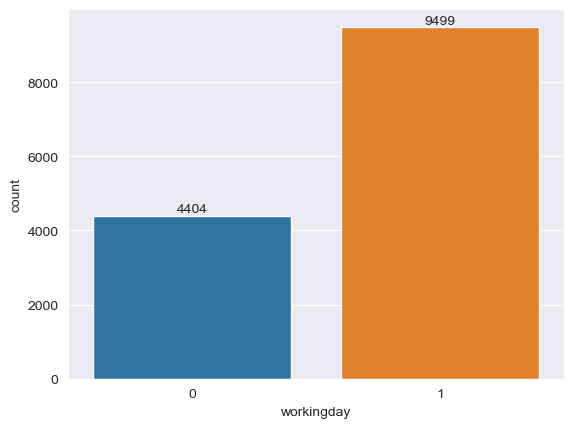

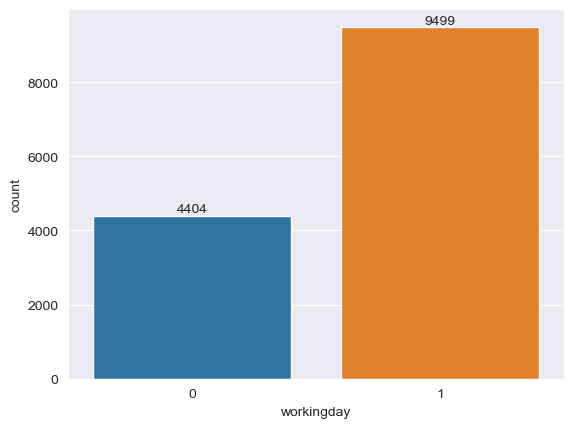

In [21]:
analyse_discrete_numerical(trainBikes, trainBikes.workingday)

**weekday Findings:**
- Very similar amount of entries per weekday.

Same reason as the features before holiday. The slight change between the different weekdays
could be due to a cnt <= 0 for certain hrs of those days and that relationship will be investigated
in pass 3. Another likely cause is the lack of data that was split off into bikesTest.

**workingday Findings:**
- a little over double the amount of entries for workingday as there is for non-workingday

This is the expected result for workingday, following the same reasoning for majority of previous features.
The ratio of weekend to weekday is 2:5, the ratio here is close to around 2.3:5.  This change is most likely impacted by:
- lack of data that was split off into bikesTest.
- holiday days falling on what normally would be a workingday.
- certain days where cnt <= 0

**Hypothesis on possible feature correlation:**
- does holiday have an impact on workingday?
  - do holiday days tend to fall between Monday and Friday and as such offset the workingday ratio?

*****Feature: workingday, Feature: holiday*****
Investigate the following hypothesis:
"do holiday days tend to fall between Monday and Friday and as such offset the workingday ratio?"

In [22]:
trainBikesWorkingDayHolidayCount = trainBikes.loc[(trainBikes.weekday >= 1) & (trainBikes.weekday <=5) & (trainBikes.holiday == 1)].count()[0]
trainBikesHolidayCount = trainBikes.loc[(trainBikes.holiday == 1)].count()[0]
print(trainBikesWorkingDayHolidayCount, trainBikesHolidayCount)
trainBikes[["holiday", "workingday"]].phik_matrix()

403 403
interval columns not set, guessing: ['holiday', 'workingday']


holiday  workingday
holiday     1.000000    0.387257
workingday  0.387257    1.000000

**Results:**
Judging from the count above, every holiday day lands on what normally would be a working day, i.e., Monday - Friday.
This result further explains the difference in workingday:non-workingday ratio to the expected weekday:weekend ratio.

**Conclusion:**
holiday has a big impact on the workingday count ratio and a good correlation.

#### Feature: weathersit ####
Investigate the weathersit feature

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         1.425160		Int64Index: 13903 entries, 15643 to 13804
std          0.638516		Series name: weathersit
min          1.000000		Non-Null Count  Dtype
25%          1.000000		--------------  -----
50%          1.000000		13903 non-null  int64
75%          2.000000		dtypes: int64(1)
max          4.000000		memory usage: 217.2 KB




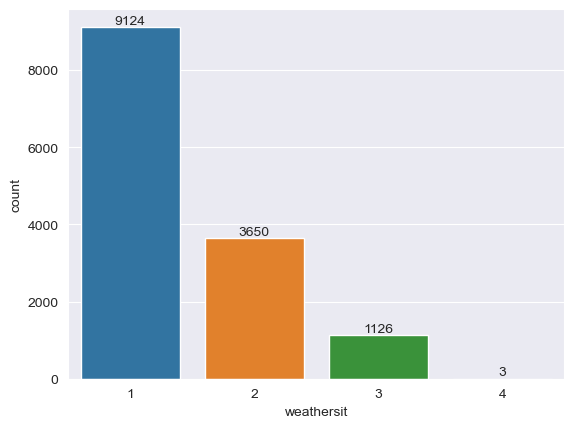

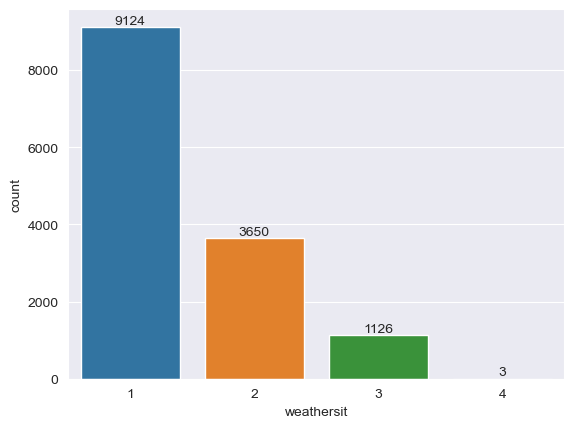

In [23]:
analyse_discrete_numerical(trainBikes, trainBikes.weathersit)

**weathersit Findings:**
- A descending count of entries in the sequence of 1 > 2 > 3 > 4

The data follows an expected pattern with the more common weather types present in weather 1 appearing much more often than the rest.
With the severe weather 4 appearing only a handful of times.
From these results it can also be assumed that the results were recorded in a mediterranean or similar environment,
due to the lower frequency of severe weather.

**Hypothesis on possible feature correlation:**
- does mnth have an impact on weathersit?
    - are more severe weather types more common to appear during certain months of the year?

##### Feature: weathersit, Feature: mnth #####
Investigate the following hypothesis:
"are more severe weather types more common to appear during certain months of the year?"

interval columns not set, guessing: ['weathersit', 'mnth']


            weathersit      mnth		             count      mean       std  min  25%  50%   75%   max
weathersit    1.000000  0.130056		weathersit                                                       
mnth          0.130056  1.000000		1           9124.0  6.510412  3.337759  1.0  4.0  7.0   9.0  12.0
                                		2           3650.0  6.613699  3.657782  1.0  3.0  7.0  10.0  12.0
                                		3           1126.0  6.521314  3.548895  1.0  3.0  6.0  10.0  12.0
                                		4              3.0  1.000000  0.000000  1.0  1.0  1.0   1.0   1.0




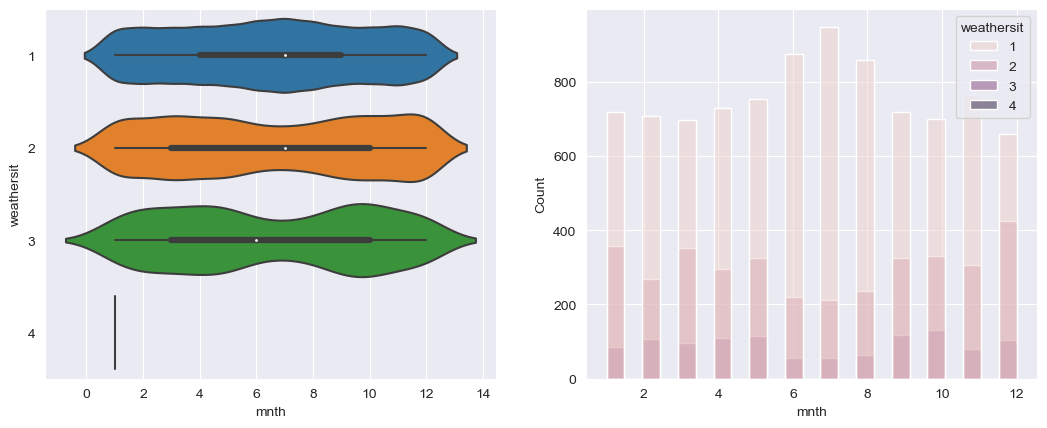

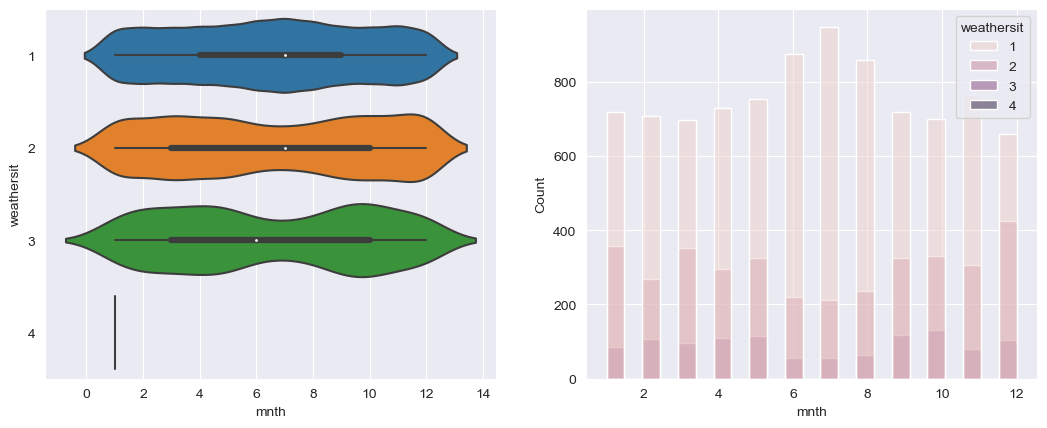

In [24]:
matrix = trainBikes[["weathersit", "mnth"]].phik_matrix()
describe = trainBikes.groupby("weathersit")["mnth"].describe()
print_side_by_side([matrix, describe])

fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(fig.get_figwidth() * 2)
sns.violinplot(data=trainBikes, x="mnth", y="weathersit", orient="h", ax=axs[0])
sns.histplot(data=trainBikes, x="mnth", hue="weathersit", ax=axs[1])
fig

**Results:**
The weathersit:mnth relationship has a phik correlation of 0.12, this implies a very weak relationship that should have next to no effect.
From the describe table, it's visible that all weathersit values (aside from 4) have a very similar mean and median month.
The violinplot and histplot further expand on this relationship, showing that weather type 1 tends to occur more often during the summer months.
Aside from that, their distribution is pretty equal to each other.

**Conclusion:**
The month has some impact on the frequency of specific weather types, but nothing significant.

#### Feature: temp ####
Investigate the temp feature.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         0.496976		Int64Index: 13903 entries, 15643 to 13804
std          0.193071		Series name: temp
min          0.020000		Non-Null Count  Dtype  
25%          0.340000		--------------  -----  
50%          0.500000		13903 non-null  float64
75%          0.660000		dtypes: float64(1)
max          1.000000		memory usage: 217.2 KB




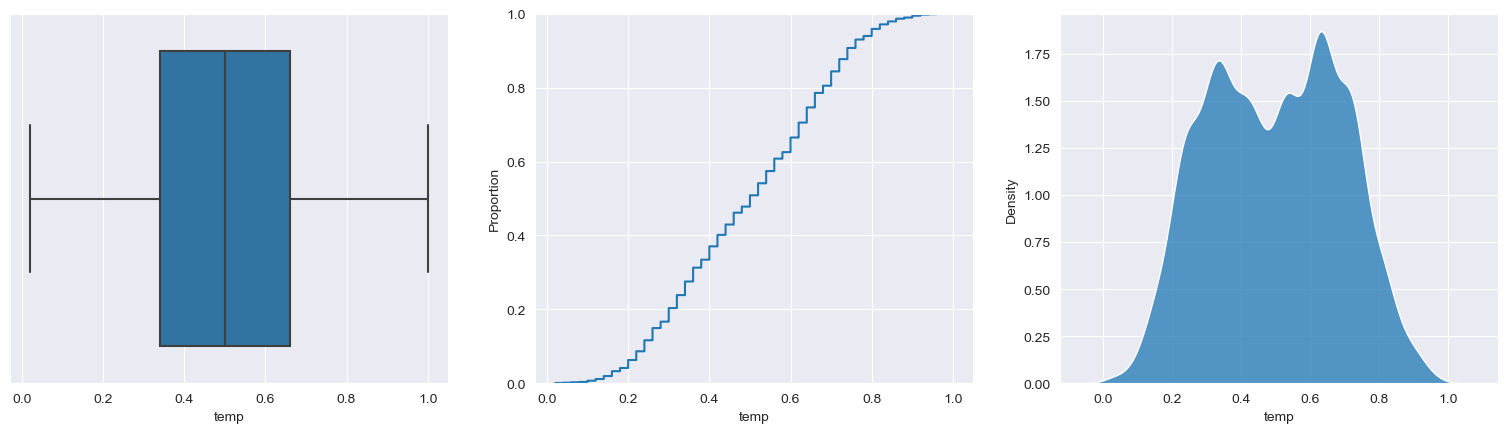

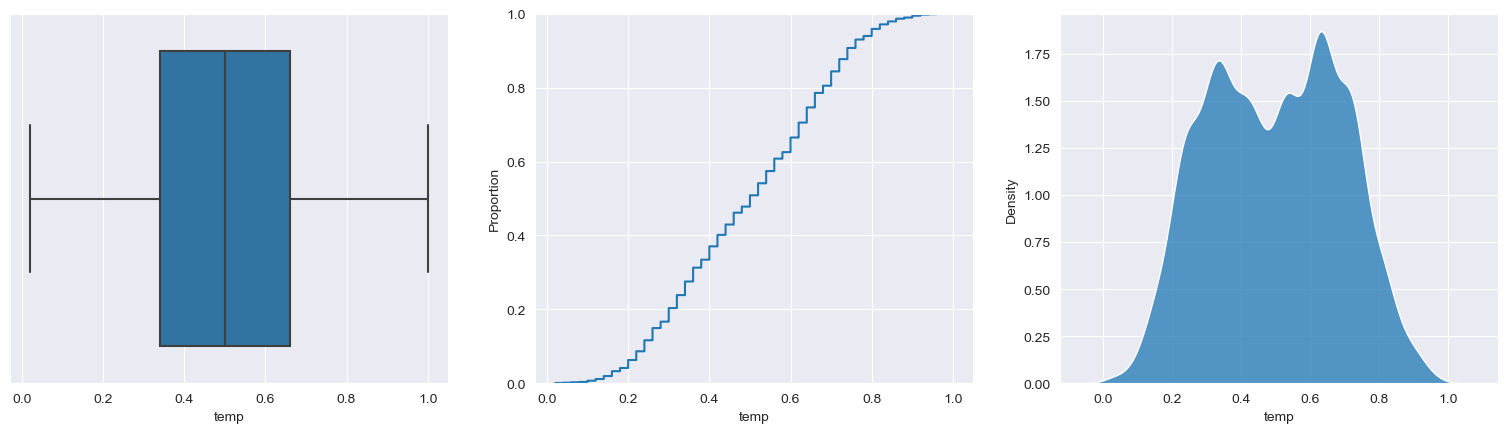

In [25]:
analyse_continous_numerical(trainBikes, trainBikes.temp)

**temp Findings:**
- Normally distributed
- Highest frequency of entries occurs around the 0.3 and 0.7 temp mark

From the describe table and boxplot it can be noted that temp has a very clean standard deviation with a near perfect mean.
The ecdf plot further supports this by having very similar jumps between different temps and no obviously leaps in height at any point.
The kde plot then visualizes the actual distribution of values with peaks +/-(0.2) from the mean.  All this makes mean a good representation of the central position.

**Hypothesis on possible feature correlation:**
- Does weathersit have an impact on temp?
    - Does the current weather level have an impact on how high/low the temp is?
- Does mnth have an impact on temp?
    - Does the current month have an impact on the level of temp?
- Is there a correlation between temp and humidity?
    - Does the level of humidity have a correlation to the level of temp?
- Is there a correlation between temp and windspeed?
    - Does the level of windspeed have a correlation to the level of temp?

##### Feature: temp, Feature: weathersit #####
Investigate the following hypothesis:
"Does the current weather level have an impact on how high/low the temp is?"

interval columns not set, guessing: ['weathersit', 'temp']


            weathersit      temp		             count      mean       std   min   25%   50%   75%   max
weathersit    1.000000  0.161235		weathersit                                                          
temp          0.161235  1.000000		1           9124.0  0.511589  0.201215  0.02  0.34  0.52  0.68  1.00
                                		2           3650.0  0.473222  0.176247  0.02  0.32  0.46  0.62  0.96
                                		3           1126.0  0.456394  0.161513  0.08  0.34  0.46  0.60  0.92
                                		4              3.0  0.186667  0.041633  0.14  0.17  0.20  0.21  0.22




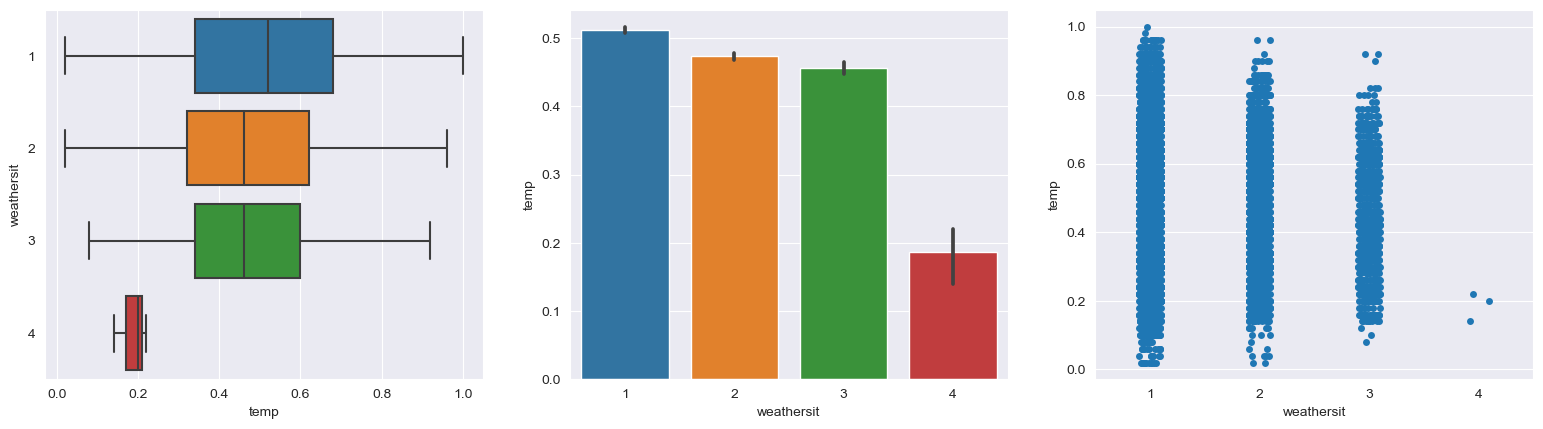

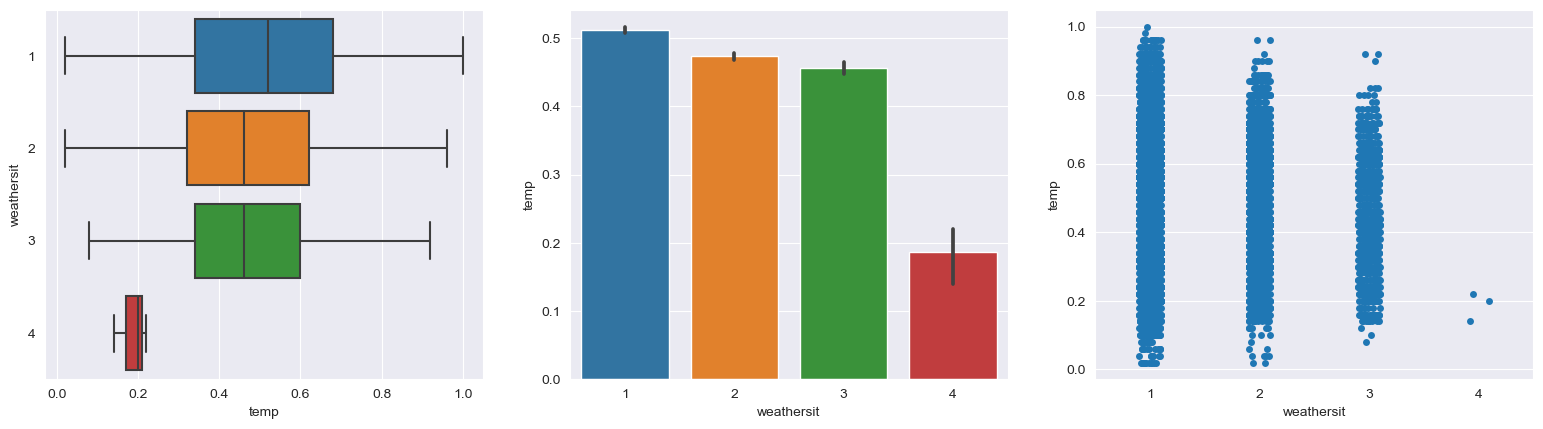

In [26]:
correlate_discrete_continous(trainBikes, "weathersit", "temp")

**Results:**
The phik matrix shows a correlation of 0.16, which implies a very weak relationship between weathersit and temp. The descibe table further shows a small change in temp based on weather.
From the boxplot and weathersit, it can be seen that weathersit 1-3 have fairly similar distributions with slightly lower means going from 1 to 3.
In all these comparisons, weathersit 4 stands as an outlier and this could be due to a very small sample size.  The striplot then shows the quantity dispersion for each weathersit.

**Conclusion:**
Weather has a small impact on temp, but not significant.

##### Feature: temp, Feature: mnth #####
Investigate the following hypothesis:
"Does the current month have an impact on the level of temp?"

interval columns not set, guessing: ['mnth', 'temp']


          mnth      temp		       count      mean       std   min   25%   50%   75%   max
mnth  1.000000  0.806489		mnth                                                          
temp  0.806489  1.000000		1     1164.0  0.238746  0.100291  0.02  0.16  0.22  0.30  0.58
                        		2     1083.0  0.298984  0.104957  0.06  0.22  0.30  0.36  0.66
                        		3     1145.0  0.389659  0.122580  0.12  0.30  0.38  0.48  0.72
                        		4     1136.0  0.469859  0.113196  0.24  0.38  0.46  0.54  0.80
                        		5     1193.0  0.593294  0.095165  0.34  0.52  0.60  0.64  0.90
                        		6     1150.0  0.685148  0.096063  0.46  0.62  0.68  0.74  0.98
                        		7     1216.0  0.755214  0.083856  0.58  0.70  0.74  0.82  1.00
                        		8     1160.0  0.708672  0.072445  0.52  0.66  0.70  0.76  0.90
                        		9     1159.0  0.617739  0.081

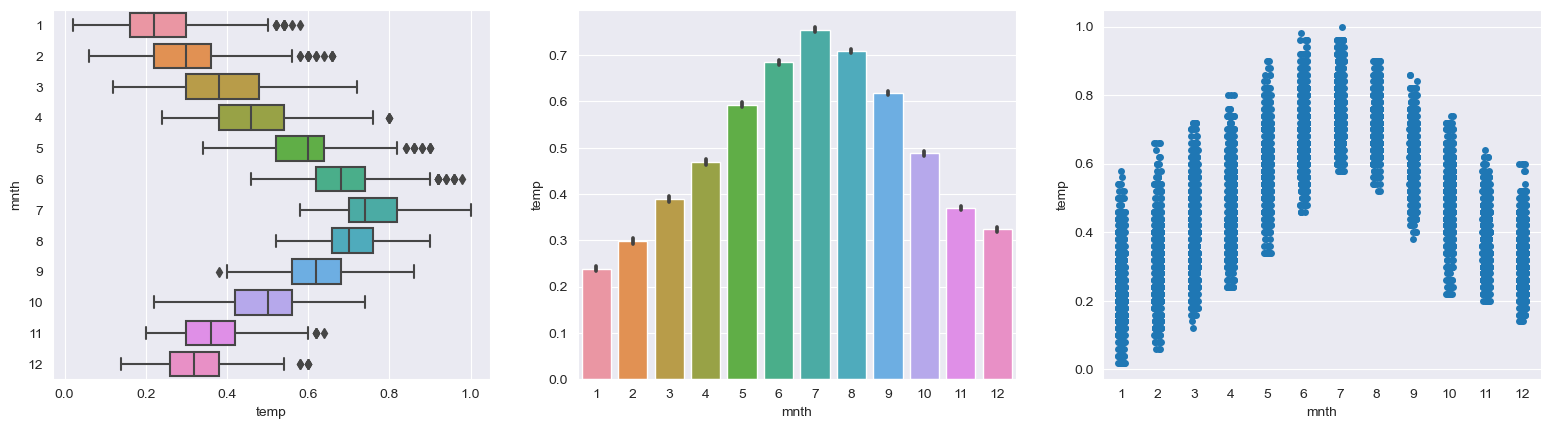

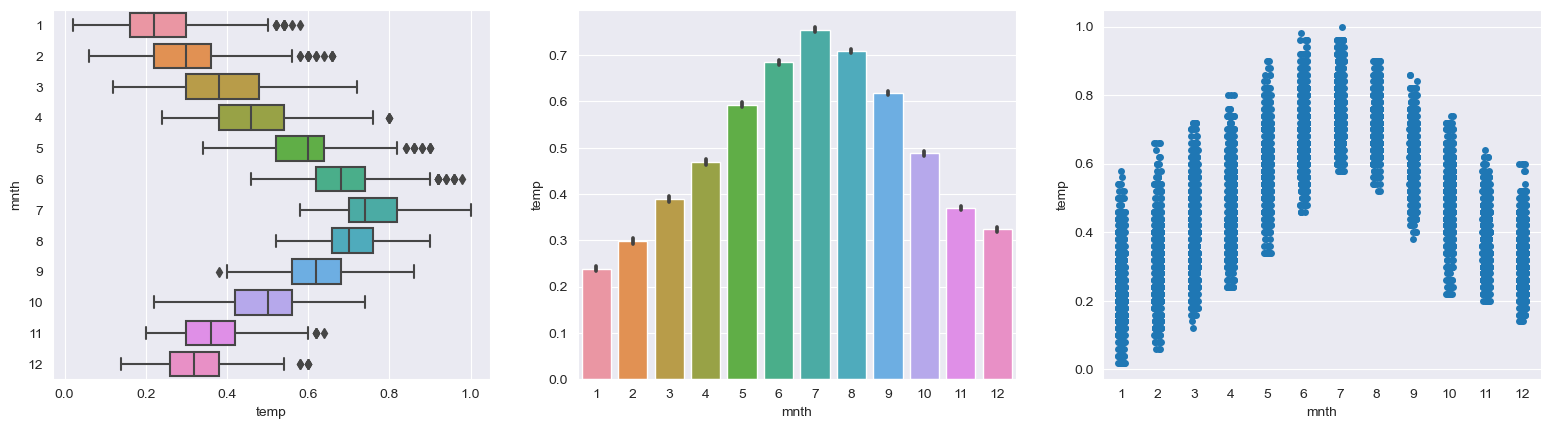

In [27]:
correlate_discrete_continous(trainBikes, "mnth", "temp")

**Results:**
The temp:mnth relationship has a phik correlation of 0.8. This implies a very strong correlation betweent the month of the year and the temp.
This is further explored in the visualisation where it's noticeable that the mean temp consistently increases from mnth 1, reaching it's peak around mnth 7.
After which, it drops down in similar increments to the prior increase. The boxplot shows that certain outliers do exist and are commonly found on the right of each box.
The boxplot also shows that temp per mnth is mostly normally distributed with some skewness happening in certain mnths.

**Conclusion:**
There is a very strong relationship between the 2 features, and mnth has a very strong impact on temp.

##### Feature: temp, Feature: hum #####
Investigate the following hypothesis:
"Does the level of humidity have a correlation to the level of temp?"



          temp       hum		          temp       hum
temp  1.000000 -0.071281		temp  1.000000 -0.055694
hum  -0.071281  1.000000		hum  -0.055694  1.000000




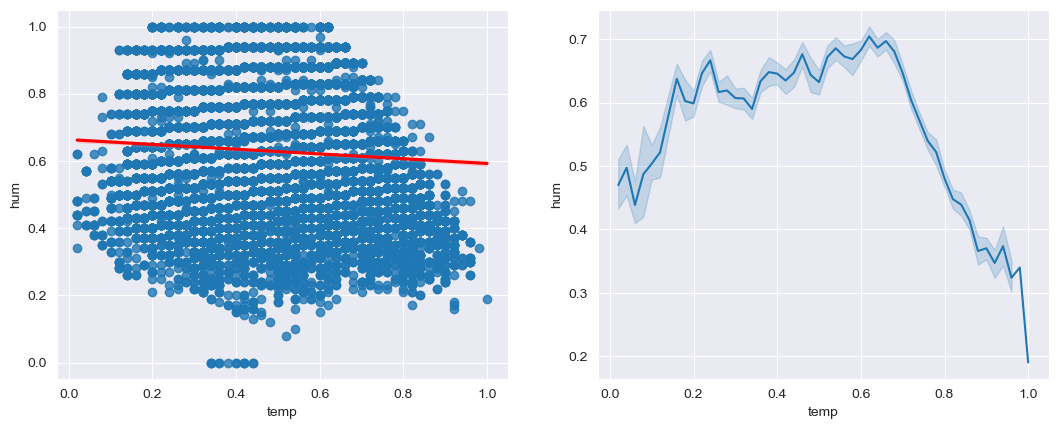

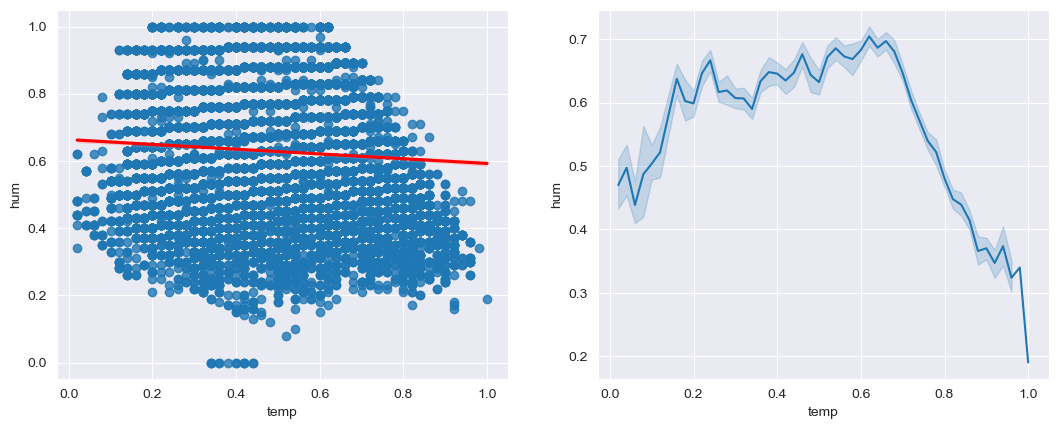

In [28]:
correlate_continous_numeric(trainBikes, "temp", "hum")

**Results:**
From the pearson and spearman correlation tables, it can be assumed that there is next to no correlation between temp and hum.
This if further explored by the regplot having data points in no obvious trend and a near horizontal regression line.
The lineplot depics the relationship between hum and temp, but no visible trend exists except for a dip in hum for higher temps, which is expected.

**Conclusion:**
No relationship between temp and hum.

##### Feature: temp, Feature: windspeed #####
Investigate the following hypothesis:
"Does the level of windspeed have a correlation to the level of temp?"



               temp  windspeed		               temp  windspeed
temp       1.000000  -0.022654		temp       1.000000  -0.008337
windspeed -0.022654   1.000000		windspeed -0.008337   1.000000




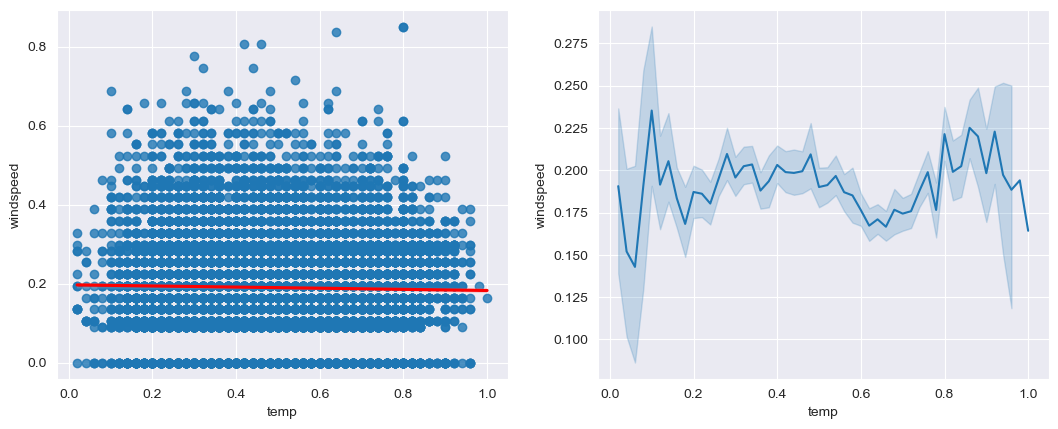

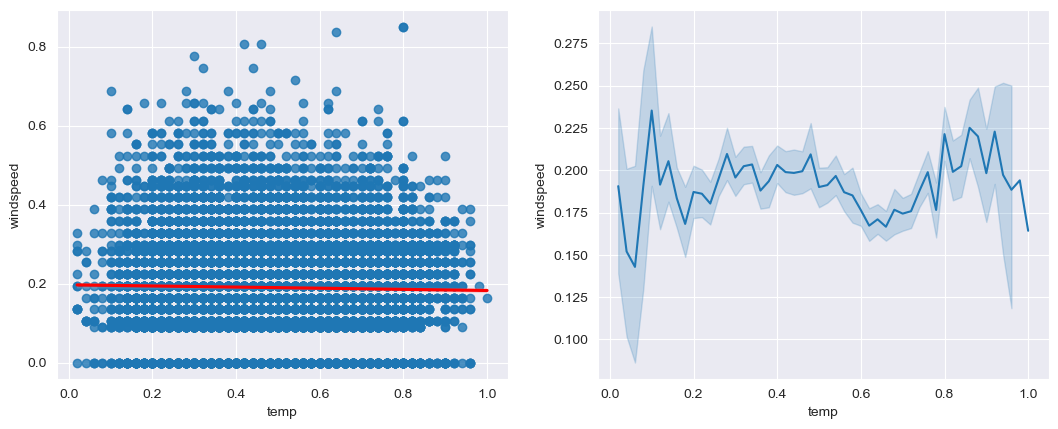

In [29]:
correlate_continous_numeric(trainBikes, "temp", "windspeed")

**Results:**
From the pearson and spearman correlation tables, it can be assumed that there is next to no correlation between temp and windspeed.
This if further explored by the regplot having data points in no obvious trend and a near horizontal regression line.
The lineplot depics the relationship between windspeed and temp, but no visible trend exist except for a spike in the lower and upper parts of temp.

**Conclusion:**
No relationship between temp and windspeed.

#### Feature: hum ####
Investigate the hum feature

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         0.628108		Int64Index: 13903 entries, 15643 to 13804
std          0.192420		Series name: hum
min          0.000000		Non-Null Count  Dtype  
25%          0.480000		--------------  -----  
50%          0.630000		13903 non-null  float64
75%          0.780000		dtypes: float64(1)
max          1.000000		memory usage: 217.2 KB




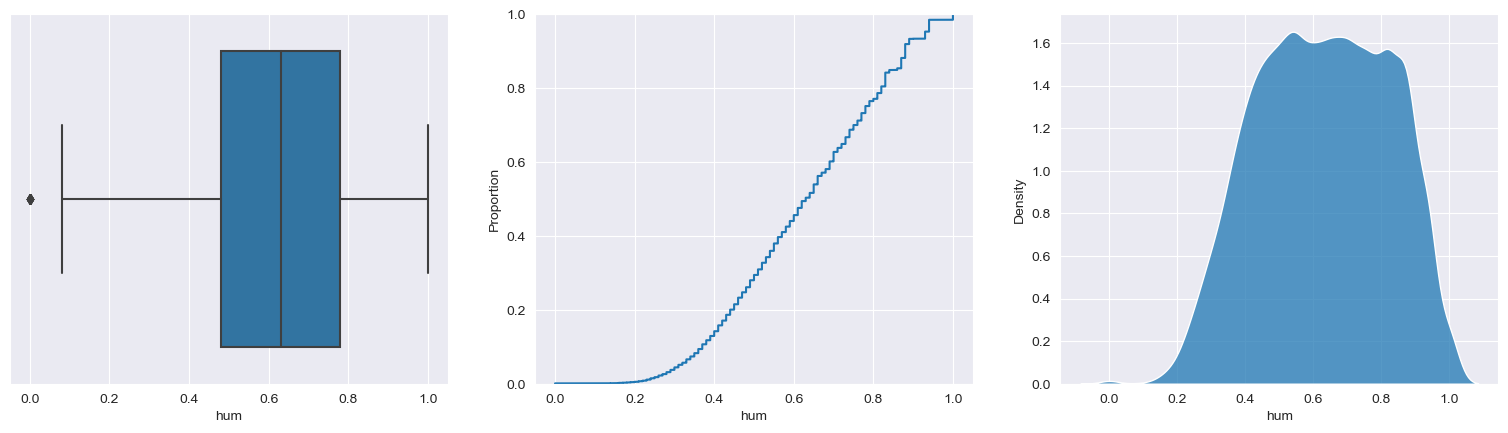

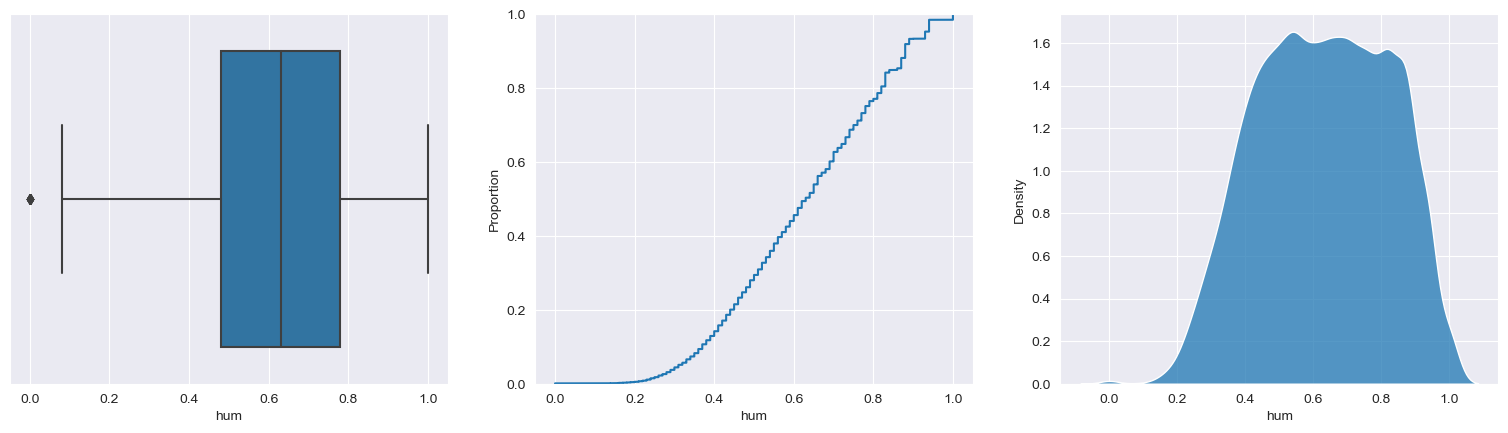

In [30]:
analyse_continous_numerical(trainBikes, trainBikes.hum)

**hum Findings:**
- Data is quite normally distributed, with a few outliers on the left.
- Highest frequency of entries centers around 0.6

From the describe table and the boxplot, it can be estimated that hum is normally distributed.
This is due to the median line being the middle of the boxplot box and the mean being near identical to the 50% mark in the describe table.
The ecdf and kde plots both show a very low frequency of hum < 0.2 and a peak frequency between 0.5 and 0.8 hum.
Mean is a good representation of the central point.

**Hypothesis on possible feature correlation:**
- Does weathersit have an impact on hum?
    - Does a specific weathersit level have a correlation to a higher/lower hum value?
- Does mnth have an impact on hum?
    - Does a specific month have a correlation to a higherl/lower hum value?
- Is there a correlation between hum and temp?
    - Does the level of temp have a correlation to the level of hum?
        - No, tested in temp investigation.
- Is there a correlation between hum and windspeed?
    - Does the level of windspeed have a correlation to the level of hum?

##### Feature: hum, Feature: weathersit #####
Investigate the following hypothesis:
"Does a specific weathersit level have a correlation to a higher/lower hum value?"

interval columns not set, guessing: ['weathersit', 'hum']


            weathersit       hum		             count      mean       std   min   25%   50%    75%   max
weathersit    1.000000  0.446665		weathersit                                                           
hum           0.446665  1.000000		1           9124.0  0.574339  0.178563  0.08  0.43  0.57  0.710  1.00
                                		2           3650.0  0.700236  0.171465  0.00  0.57  0.71  0.840  1.00
                                		3           1126.0  0.829316  0.150291  0.00  0.78  0.87  0.930  1.00
                                		4              3.0  0.883333  0.040415  0.86  0.86  0.86  0.895  0.93




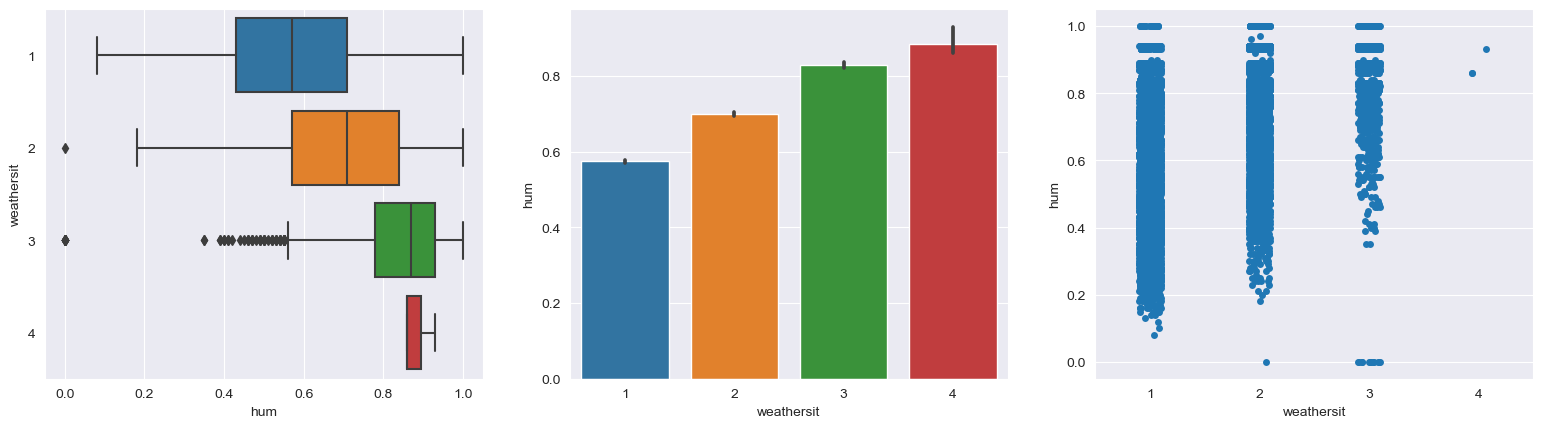

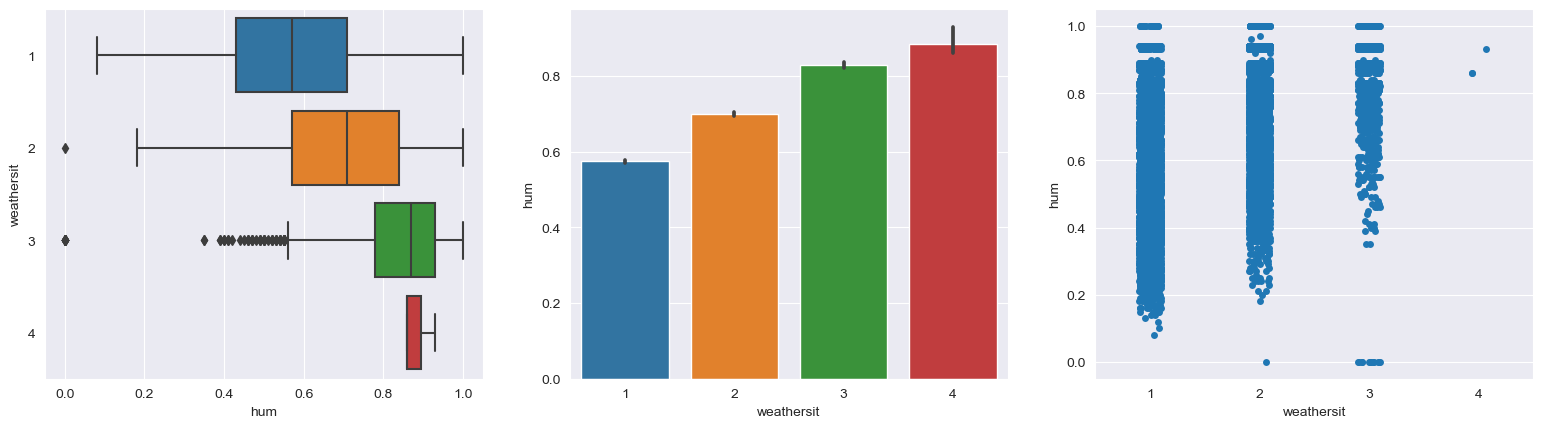

In [31]:
correlate_discrete_continous(trainBikes, "weathersit", "hum")

**Results:**
The hum:weathersit relationship has a phik correlation of 0.44, which implies a pretty strong correlation between the two.
The describe table then further supports this by having an increasing hum mean and median going from weathersit 1 to 4.
From the boxplot, it's visible that each weathersit has a normally distributted hum, with some outliers on the left of some boxes.
The barplot then further depicts a rising mean value for hum per weathersit.

**Conclusion:**
There is a good correlation between weathersit and hum.

##### Feature: hum, Feature: mnth #####
Investigate the following hypothesis:
"Does a specific month have a correlation to a higherl/lower hum value?"

interval columns not set, guessing: ['mnth', 'hum']


          mnth       hum		       count      mean       std   min     25%   50%   75%   max
mnth  1.000000  0.348532		mnth                                                            
hum   0.348532  1.000000		1     1164.0  0.582878  0.186531  0.21  0.4400  0.55  0.74  1.00
                        		2     1083.0  0.565716  0.203365  0.08  0.4200  0.54  0.70  1.00
                        		3     1145.0  0.595380  0.229078  0.00  0.4100  0.60  0.77  1.00
                        		4     1136.0  0.589789  0.218265  0.16  0.4100  0.58  0.77  1.00
                        		5     1193.0  0.694158  0.175734  0.21  0.5700  0.72  0.83  1.00
                        		6     1150.0  0.575113  0.183442  0.20  0.4200  0.57  0.74  1.00
                        		7     1216.0  0.600543  0.173541  0.16  0.4700  0.59  0.74  0.94
                        		8     1160.0  0.635310  0.168474  0.25  0.5100  0.65  0.78  0.94
                        		9     1159

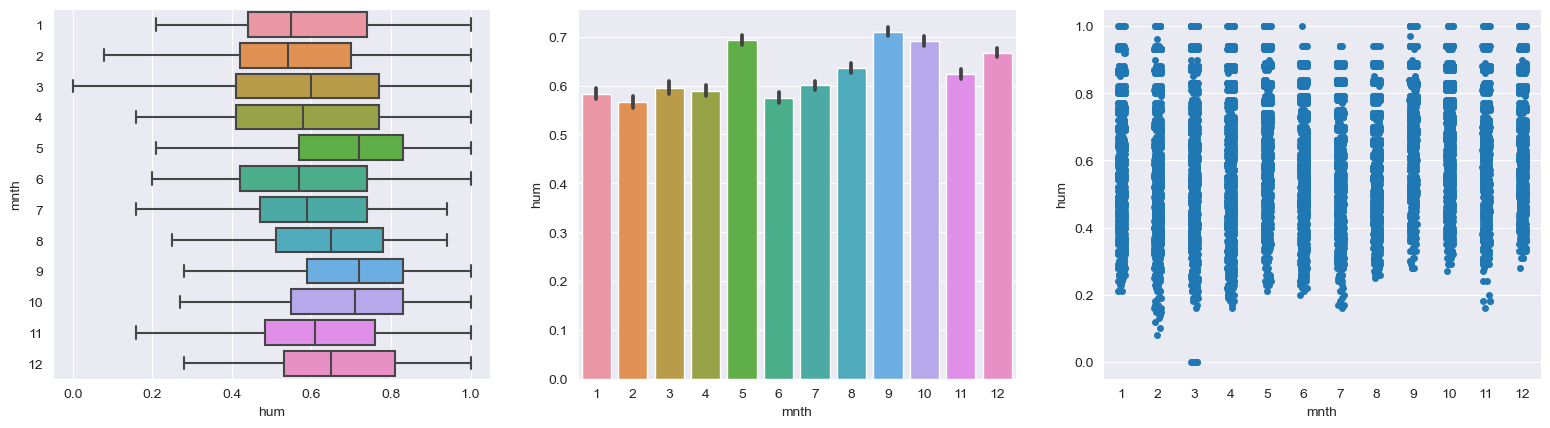

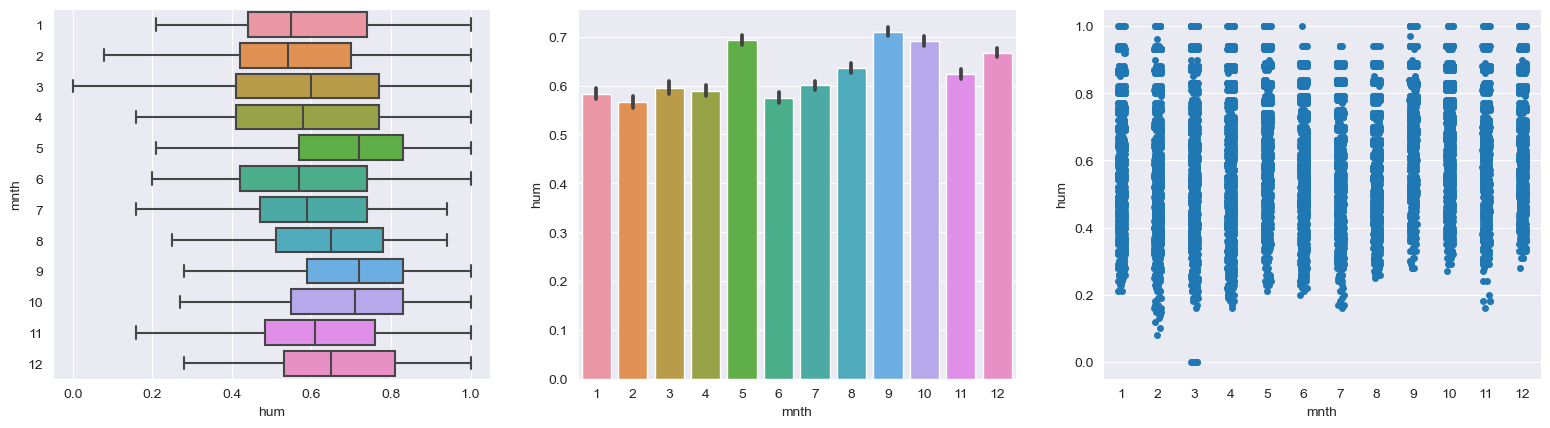

In [32]:
correlate_discrete_continous(trainBikes, "mnth", "hum")

**Results:**
According to the phik_matrix, the mnth:hum relationship has a correlation of 0.35, which signifies a weak correlation between the two.
From the boxplot, it's visible that most of the boxes are either negatively or positively skewed, with certain ones like mnth 6 being normally distributed.
The stripplot then shows that the distribution for majority of mnths is about the same or very similar.

**Conclusion:**
There is a weak relationship between the two features, but nothing note-worthy.

##### Feature: hum, Feature: windspeed #####
Investigate the following hypothesis:
"Does the level of windspeed have a correlation to the level of hum?"



                hum  windspeed		                hum  windspeed
hum        1.000000  -0.289545		hum        1.000000  -0.291813
windspeed -0.289545   1.000000		windspeed -0.291813   1.000000




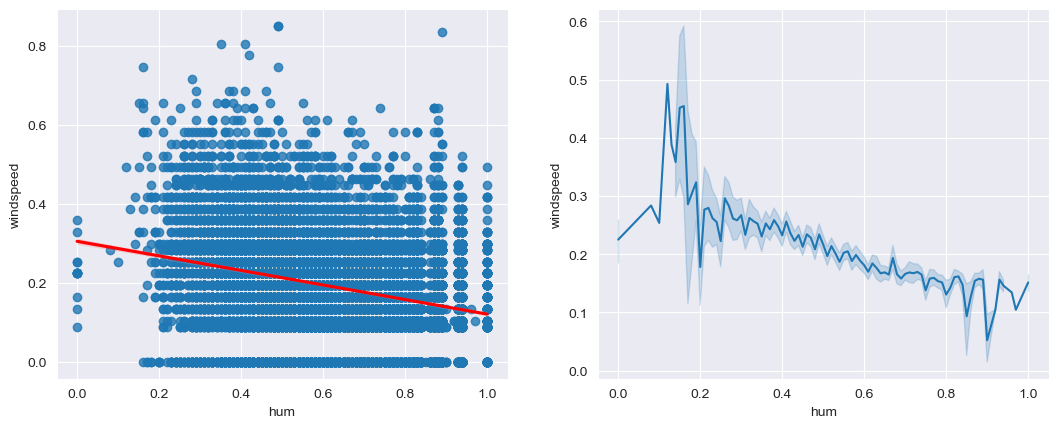

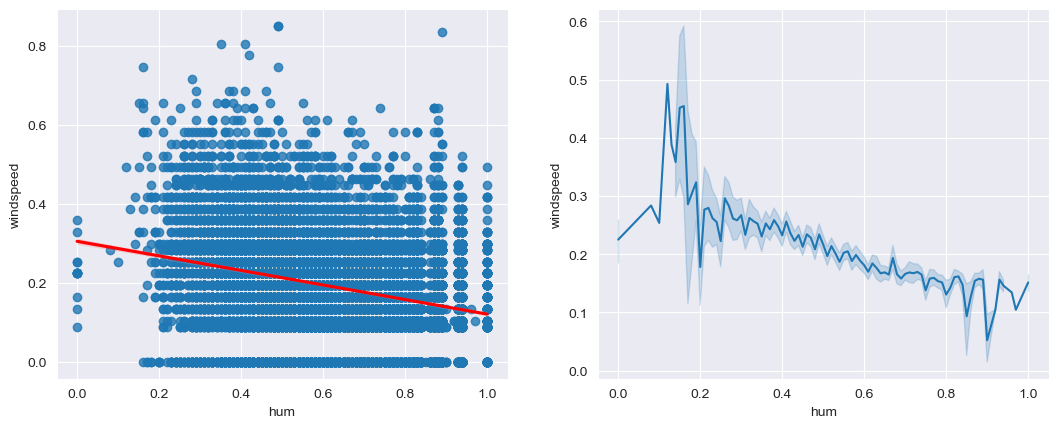

In [33]:
correlate_continous_numeric(trainBikes, "hum", "windspeed")

**Results:**
From the pearson and spearman correlation tables, it can be noted that the hum:windspeed relationship has a negative correlation of 0.3.
This is further shown in the regplot, with the regression line slightly sloping downwards from left to right.
The lineplot then further explores the windspeed/hum relationship.

**Conclusion:**
A weak negative relationship exists.

#### Feature: windspeed ####
Investigate the windspeed feature

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean         0.189613		Int64Index: 13903 entries, 15643 to 13804
std          0.122492		Series name: windspeed
min          0.000000		Non-Null Count  Dtype  
25%          0.104500		--------------  -----  
50%          0.164200		13903 non-null  float64
75%          0.253700		dtypes: float64(1)
max          0.850700		memory usage: 217.2 KB




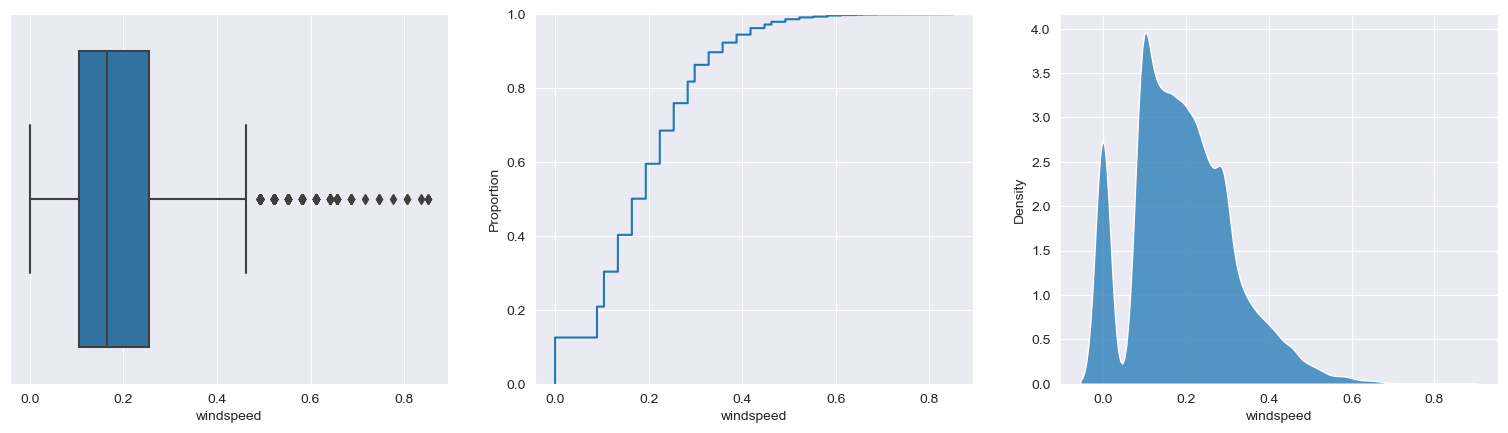

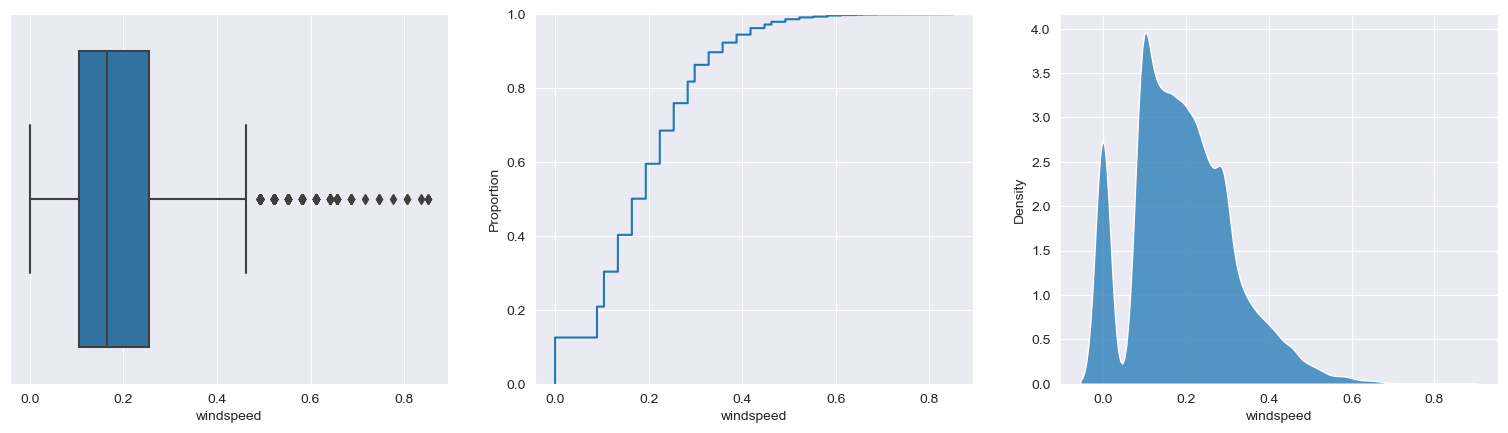

In [34]:
analyse_continous_numerical(trainBikes, trainBikes.windspeed)

**windspeed Findings:**
- Not normally distributed, negative skew
- Multiple outliers on the right
- Highest frequency of entries centers between 0.1 and 0.3 windspeed

From the boxplot it can be observed that windspeeds are not normally distributed, they tend to be negatively skewed.
Majority of wind speeds occur in the bottom half of wind speed and with very few outliers occuring past the 0.6 windspeed mark.
This trend can be better viewed from the ecdf and kde plots.

**Hypothesis on possible feature correlation:**
- Does weathersit have an impact on windspeed?
    - Does a specific weathersit level have a correlation to a higher/lower windspeed value?
- Does mnth have an impact on windspeed?
    - Does a specific month have a correlation to a higherl/lower windspeed value?
- Is there a correlation between windspeed and temp?
    - Does the level of temp have a correlation to the level of windspeed?
        - No, tested in temp investigation.
- Is there a correlation between windspeed and hum?
    - Does the level of hum have a correlation to the level of windspeed?
        - Yes, a weak negative relationship, tested in hum investigation.

##### Feature: windspeed, Feature: weathersit #####
Investigate the following hypothesis:
"Does a specific weathersit level have a correlation to a higher/lower windspeed value?"

interval columns not set, guessing: ['weathersit', 'windspeed']


            weathersit  windspeed		             count      mean       std     min     25%     50%     75%     max
weathersit    1.000000   0.085352		weathersit                                                                    
windspeed     0.085352   1.000000		1           9124.0  0.190197  0.124295  0.0000  0.1045  0.1940  0.2537  0.8060
                                 		2           3650.0  0.179073  0.113782  0.0000  0.1045  0.1642  0.2537  0.6866
                                 		3           1126.0  0.219006  0.129931  0.0000  0.1343  0.1940  0.2985  0.8507
                                 		4              3.0  0.204000  0.119714  0.0896  0.1418  0.1940  0.2612  0.3284




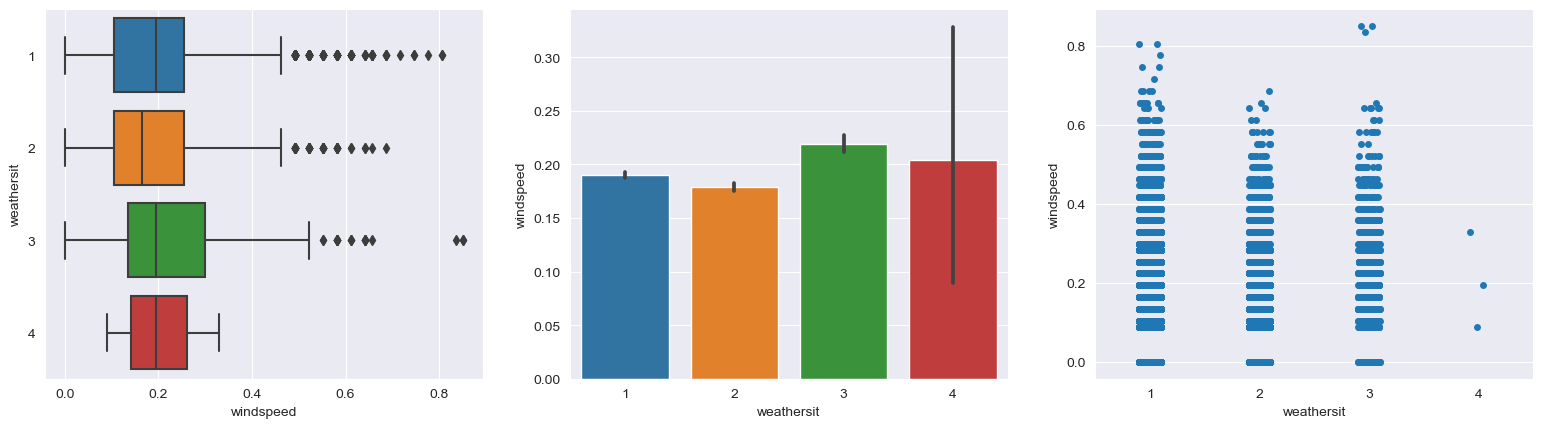

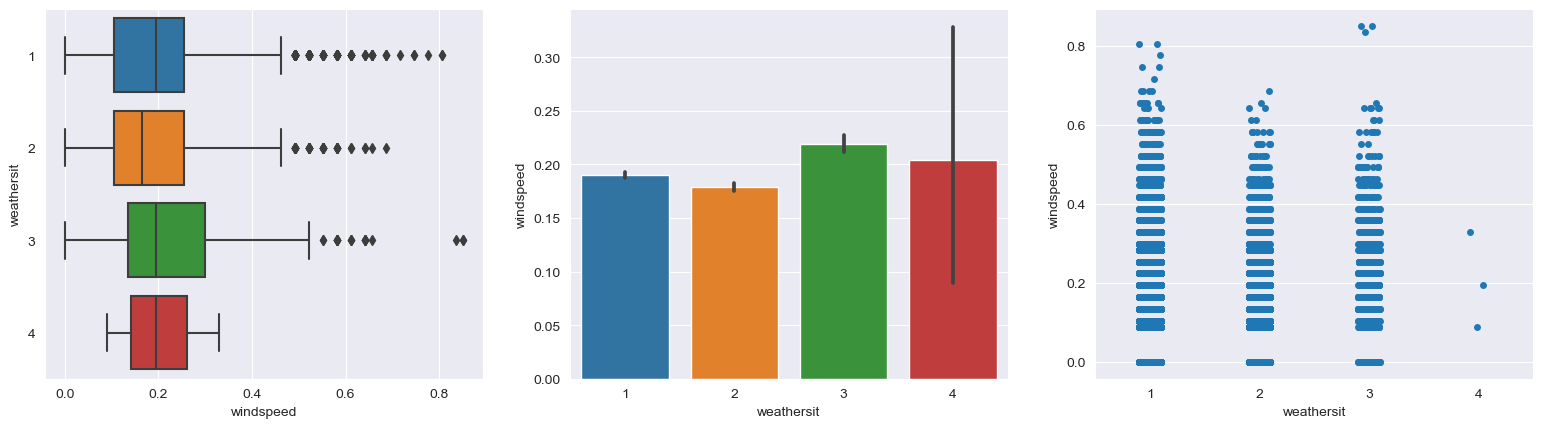

In [35]:
correlate_discrete_continous(trainBikes, "weathersit", "windspeed")

**Results:**
From the phik matrix, it's visible that the weathersit:hum relationship has a near 0 correlation between the 2.
This is further backed up by the describe table showing similar means/medians throughtout the weathersits.
The boxplot and stripplot both show the dispersion of windspeed vs weathersit data. With the boxplot also showing the median of each.
Each weathersit has a near to normal distribution with 3 and 2 being slightly negatively skewed.

**Conclusion:**
No notable correlation between the two features.

##### Feature: windspeed, Feature: mnth #####
Investigate the following hypothesis:
"Does a specific month have a correlation to a higherl/lower windspeed value?"

interval columns not set, guessing: ['mnth', 'windspeed']


               mnth  windspeed		       count      mean       std  min     25%     50%     75%     max
mnth       1.000000   0.222865		mnth                                                                 
windspeed  0.222865   1.000000		1     1164.0  0.207679  0.124885  0.0  0.1045  0.1940  0.2836  0.6567
                              		2     1083.0  0.217547  0.150088  0.0  0.1045  0.1940  0.2985  0.8060
                              		3     1145.0  0.219961  0.126559  0.0  0.1343  0.2239  0.2985  0.6866
                              		4     1136.0  0.233371  0.129926  0.0  0.1343  0.2239  0.3284  0.7164
                              		5     1193.0  0.183186  0.107789  0.0  0.1045  0.1642  0.2537  0.6119
                              		6     1150.0  0.182988  0.107956  0.0  0.1045  0.1642  0.2537  0.5821
                              		7     1216.0  0.167092  0.101996  0.0  0.1045  0.1642  0.2239  0.8507
                      

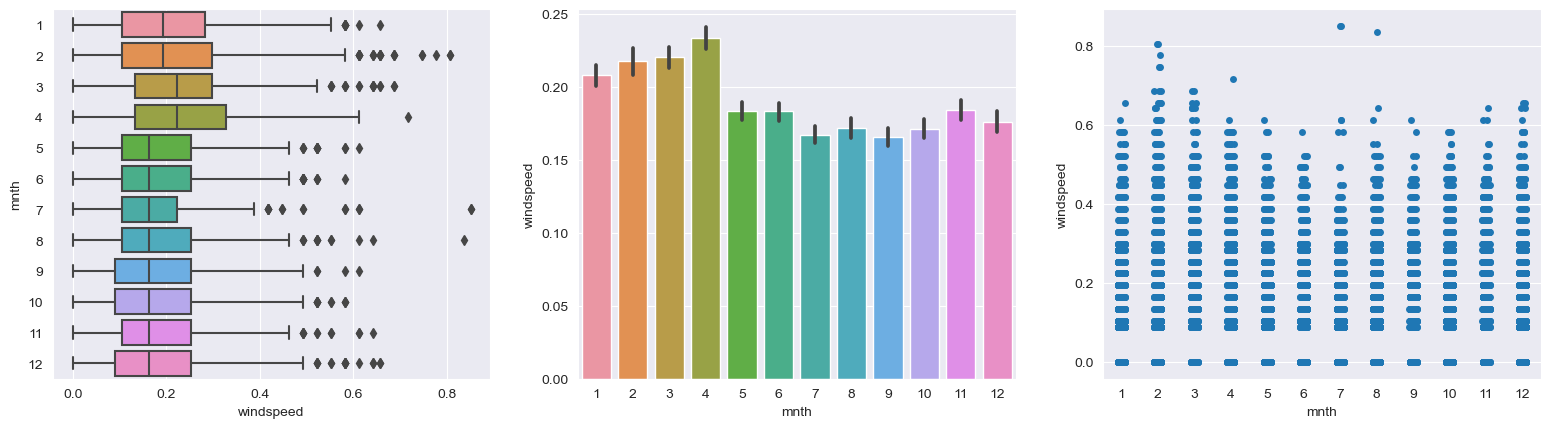

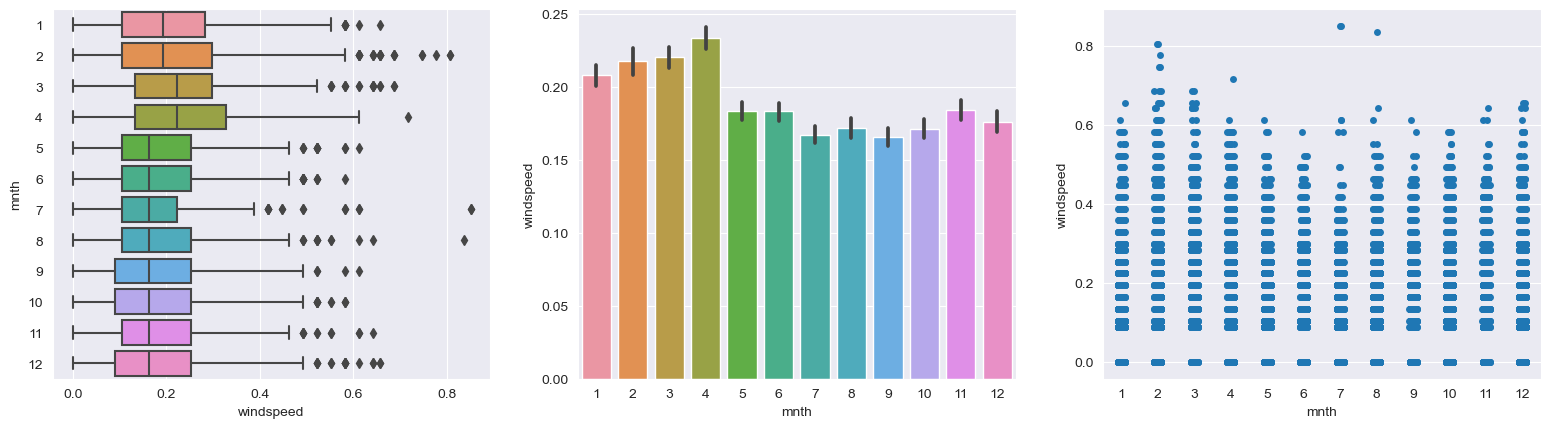

In [36]:
correlate_discrete_continous(trainBikes, "mnth", "windspeed")

**Results:**
From the phik matrix, it's visible that there is a weak correlation in the windspeed:mnth relationship.
The boxplot shows that majority of mnth do not have normally distributed windspeed values, but all have relatively similar medians when compared to each other.

**Conclusion:**
There is a weak relationship between the two features.

#### Summary ####
- holiday has a big impact on the workingday count ratio
- mnth has some impact on the frequency of specific weathersit, but nothing significant
- weathersit has a small impact on tmep
- there is a very strong relationship between mnth and temp
- there is a good correlation between weathersit and hum
- there is a weak relationship between mnth and hum
- there is a weak relationship between windspeed and mnth

### Pass 3 ###

#### Target Feature Investigation ####

##### Target: casual #####
Investigate the casual target.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean        35.658994		Int64Index: 13903 entries, 15643 to 13804
std         49.257479		Series name: casual
min          0.000000		Non-Null Count  Dtype
25%          4.000000		--------------  -----
50%         17.000000		13903 non-null  int64
75%         48.000000		dtypes: int64(1)
max        367.000000		memory usage: 217.2 KB




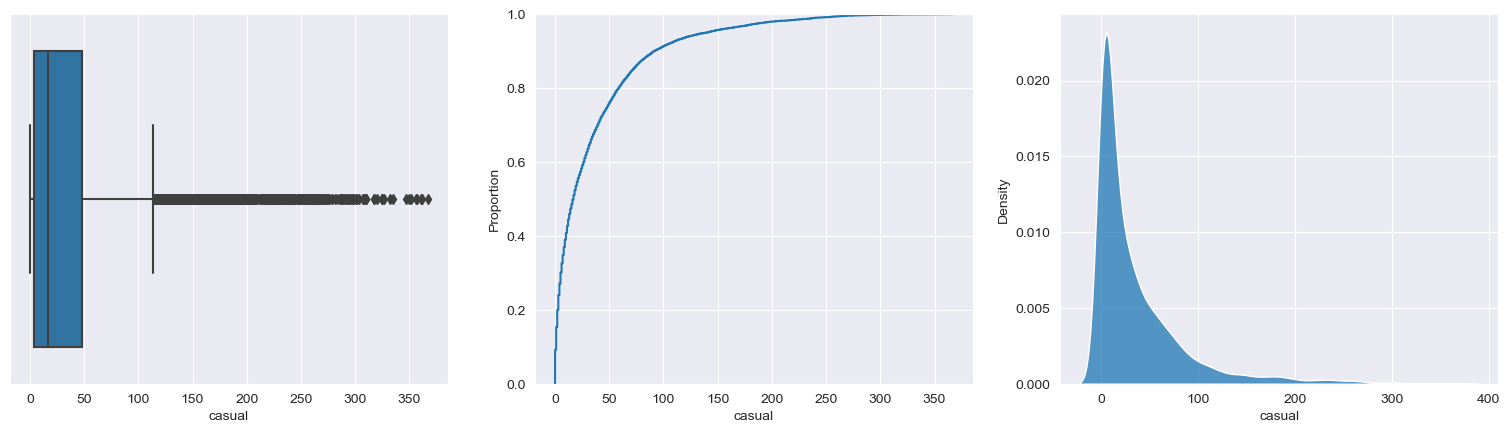

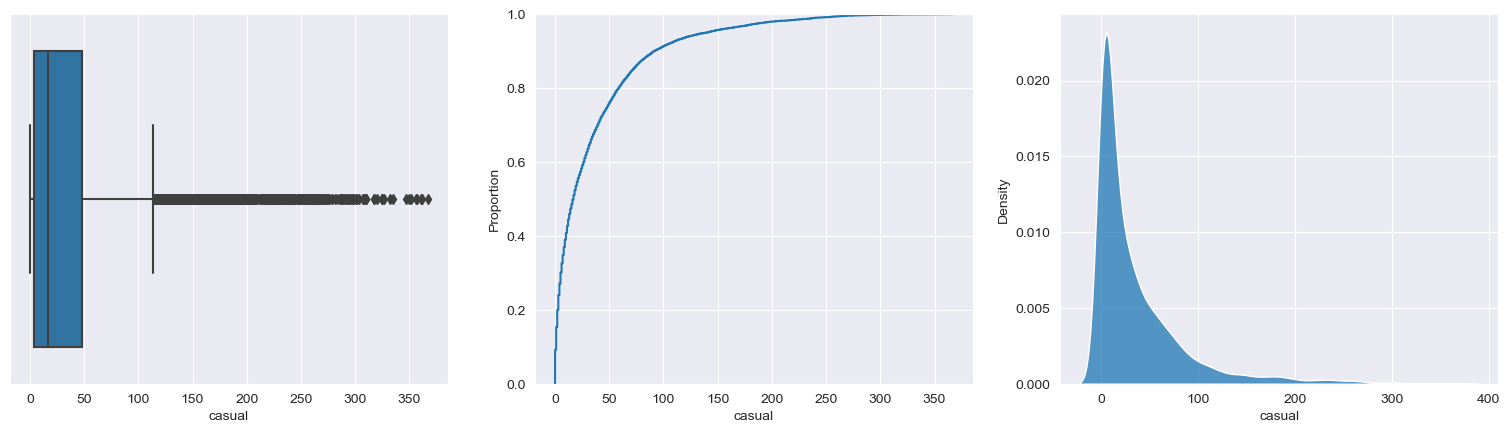

In [37]:
analyse_continous_numerical(trainBikes, trainBikes.casual)

**casual Findings:**
- not normally distributed, negatively skewed
- majority of entries have a casual of between 0 and 100
- countless of outliers on right

From the describe table it's visible that the data is not normally distributed due to a high difference in the mean and median.
This is further described in the boxplot, displaying a negative skew and outliers on the right.
The ecdf and kde plots also show this trend in dispersion. Mean is a poor representation of the central point.

##### Target: registered #####
Investigate the registered target.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean       154.623894		Int64Index: 13903 entries, 15643 to 13804
std        151.545857		Series name: registered
min          0.000000		Non-Null Count  Dtype
25%         35.000000		--------------  -----
50%        116.000000		13903 non-null  int64
75%        222.000000		dtypes: int64(1)
max        886.000000		memory usage: 217.2 KB




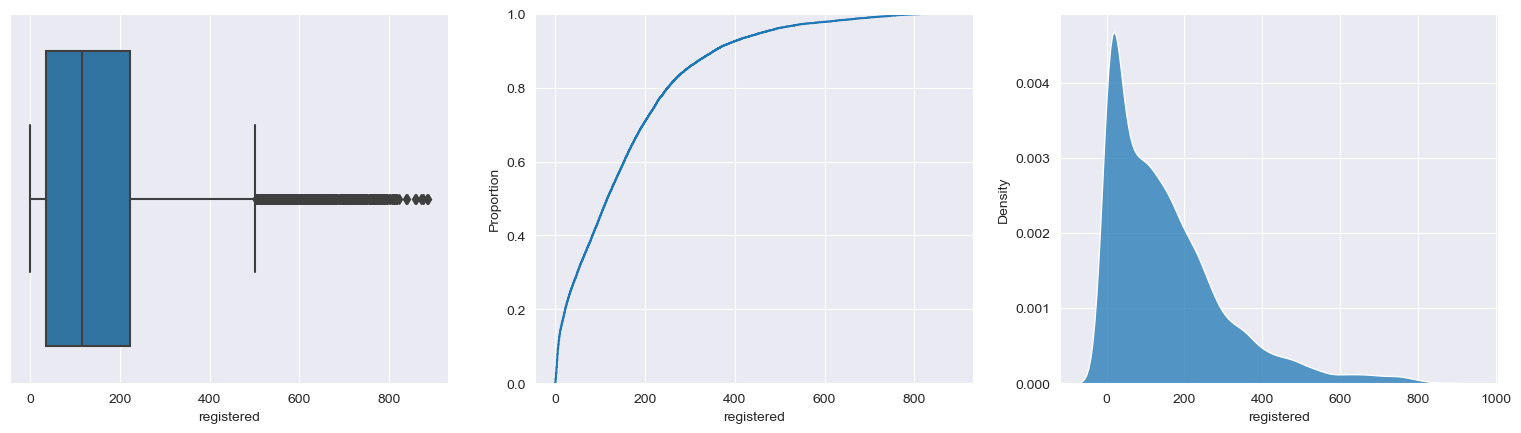

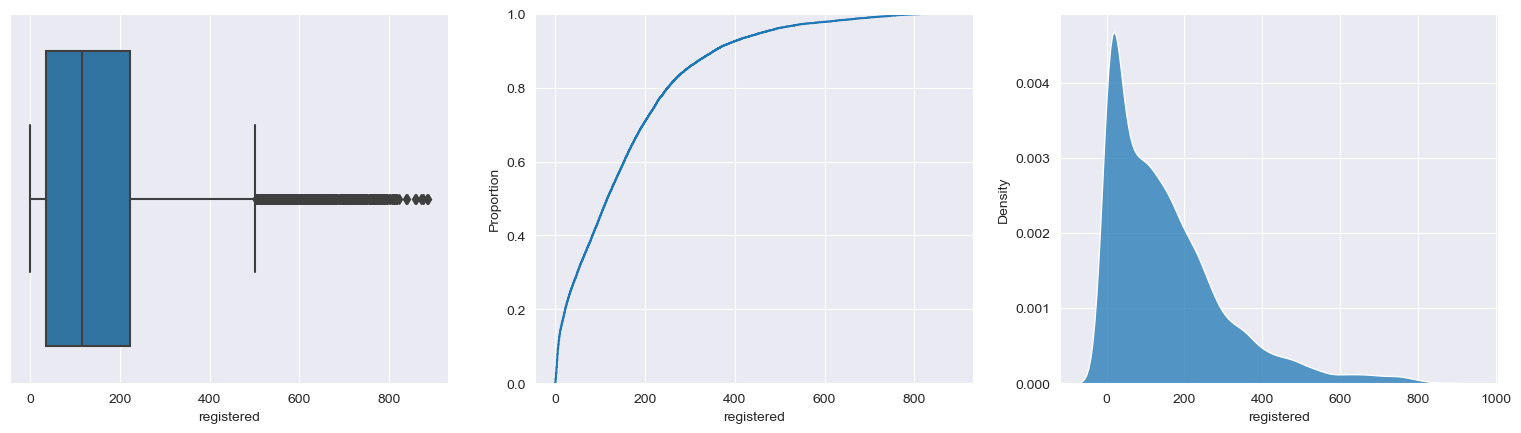

In [38]:
analyse_continous_numerical(trainBikes, trainBikes.registered)

**registered Findings:**
- close to being normally distributed, slight negative skew
- majority fo entries have a registered of between 0 and 300
- countless of outliers on right

From the describe table, it's visible that the data is close to being normally distributed.
From the ecdf and kde plots, it's quickly visible that majority of data has entries of registered lower than 400.

##### Target: cnt #####
Investigate the cnt target.

Describe: 					Info:
====================		====================
count    13903.000000		<class 'pandas.core.series.Series'>
mean       190.282889		Int64Index: 13903 entries, 15643 to 13804
std        181.457471		Series name: cnt
min          1.000000		Non-Null Count  Dtype
25%         40.000000		--------------  -----
50%        143.000000		13903 non-null  int64
75%        283.000000		dtypes: int64(1)
max        977.000000		memory usage: 217.2 KB




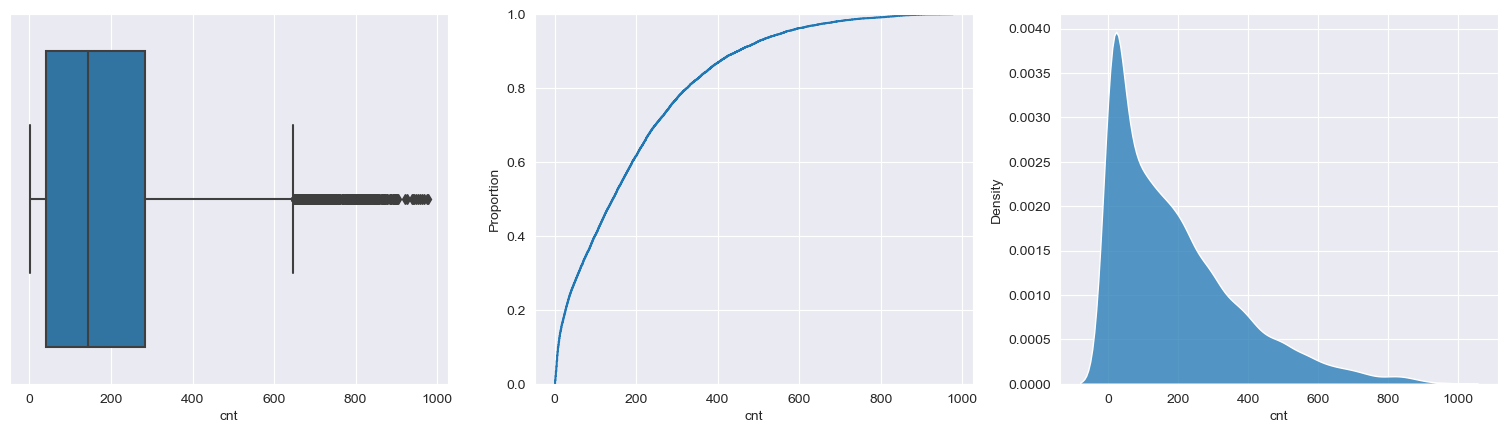

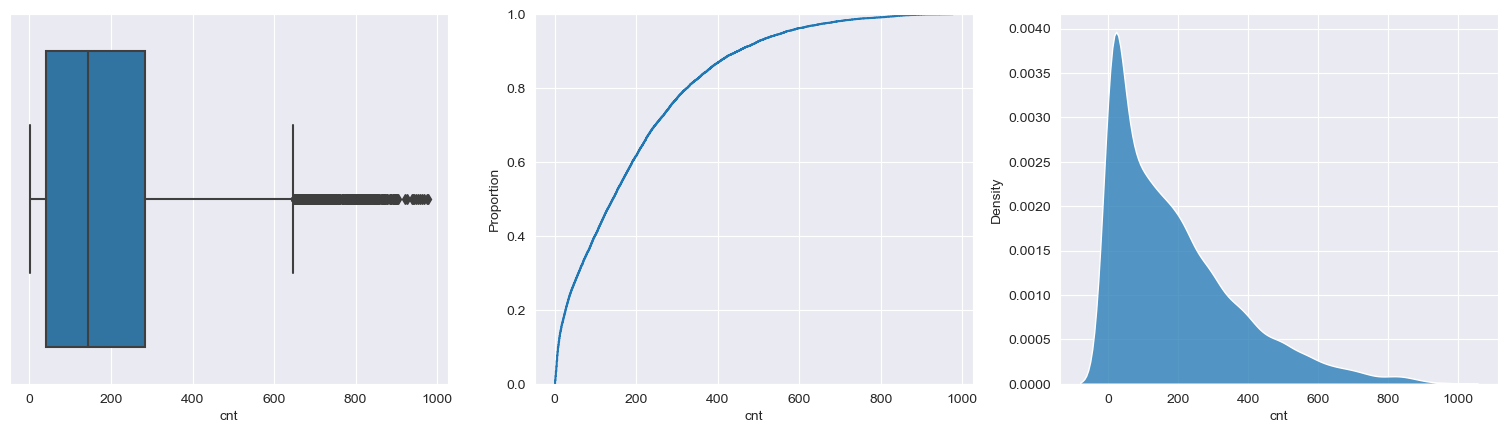

In [39]:
analyse_continous_numerical(trainBikes, trainBikes.cnt)

**cnt Findings:**
- not normally distributed, negatively skewed
- majority of entries occurs around 0 - 500
- countless outliers on right

From the describe table and boxplot, it's noticeable that the data is not normally distributed, with a negative skew.
Because the cnt target is a combination of the casual and registered targets, the normal distribution of the registered target is thrown off by the casual target.
This combination of both targets is further shown in the ecdf and kde plots.

#### Feature: yr, Targets: casual, registered, cnt ####
Investigate the yr feature against the targets.

interval columns not set, guessing: ['yr', 'cnt', 'casual', 'registered']


                  yr       cnt    casual  registered		     count        mean         std  min   25%    50%    75%    max
yr          1.000000  0.344307  0.212275    0.352125		yr                                                                
cnt         0.344307  1.000000  0.749156    0.964658		0   6900.0  144.648551  134.129627  1.0  32.0  109.0  213.0  638.0
casual      0.212275  0.749156  1.000000    0.624457		1   7003.0  235.246037  208.743221  1.0  53.5  192.0  350.0  977.0
registered  0.352125  0.964658  0.624457    1.000000		                                                                  




     count       mean        std  min  25%   50%   75%    max		     count        mean         std  min    25%    50%    75%    max
yr                                                           		yr                                                                 
0   6900.0  28.613913  38.949388  0.0  3.0  14.0  38.

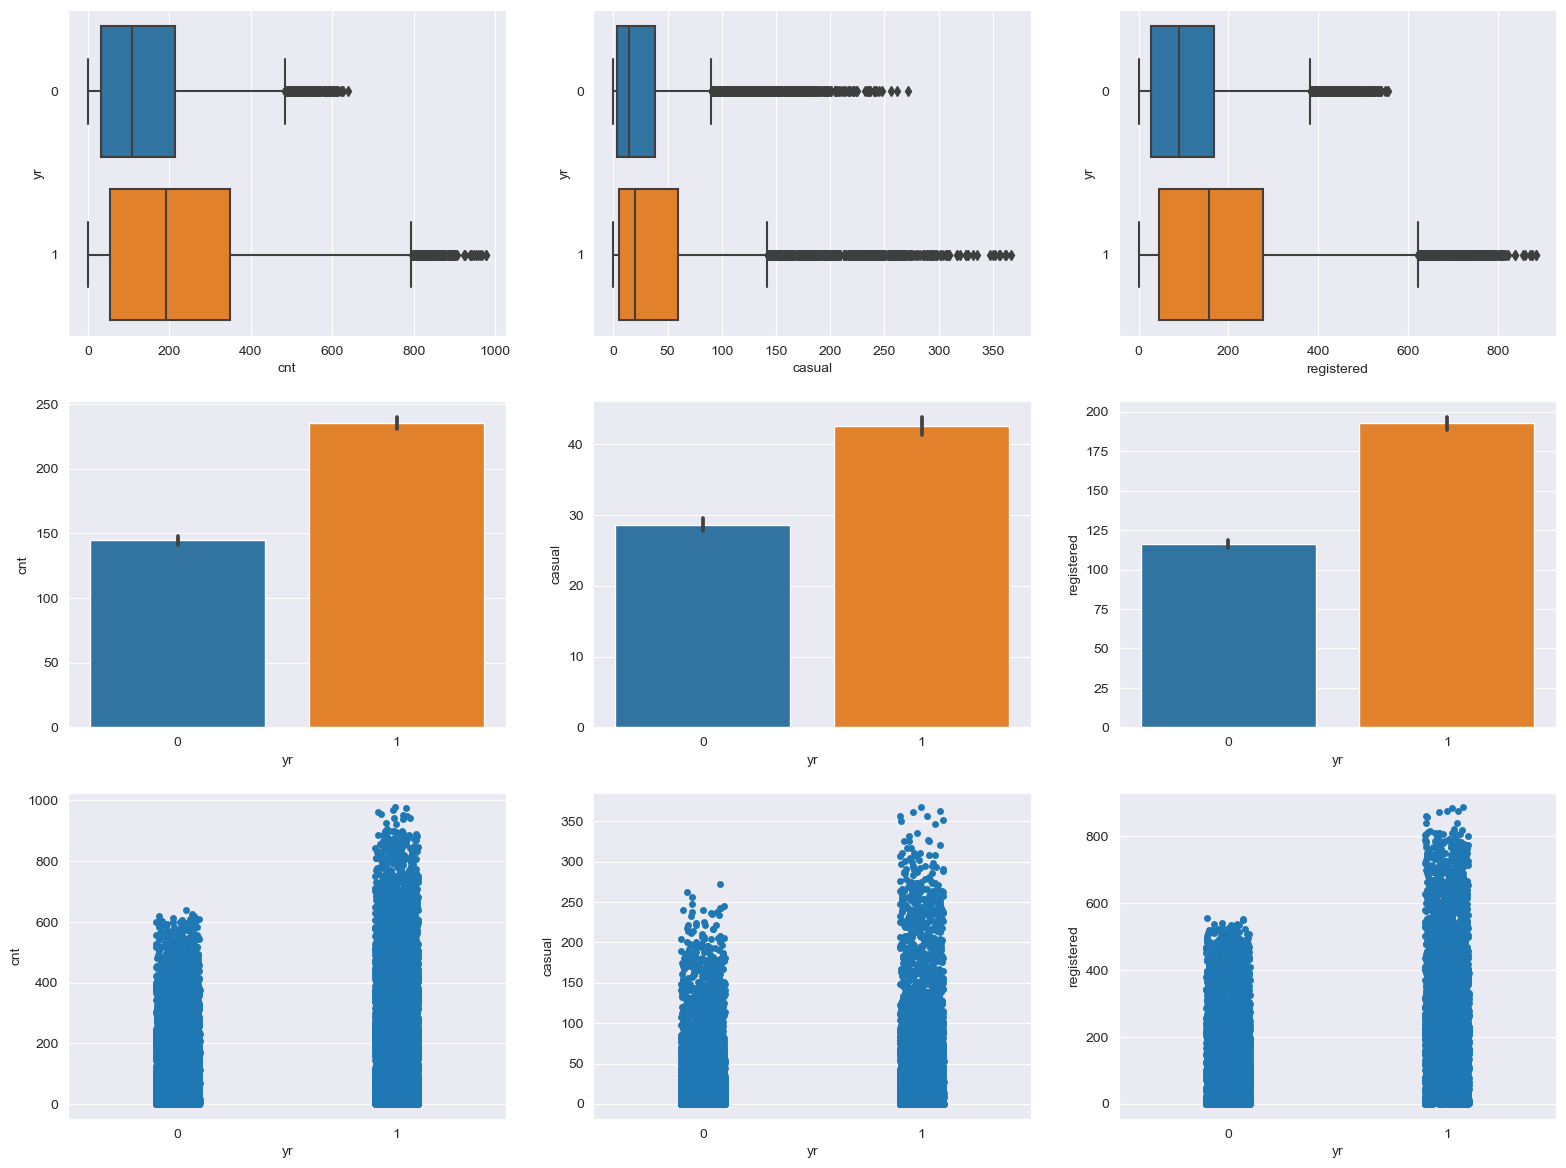

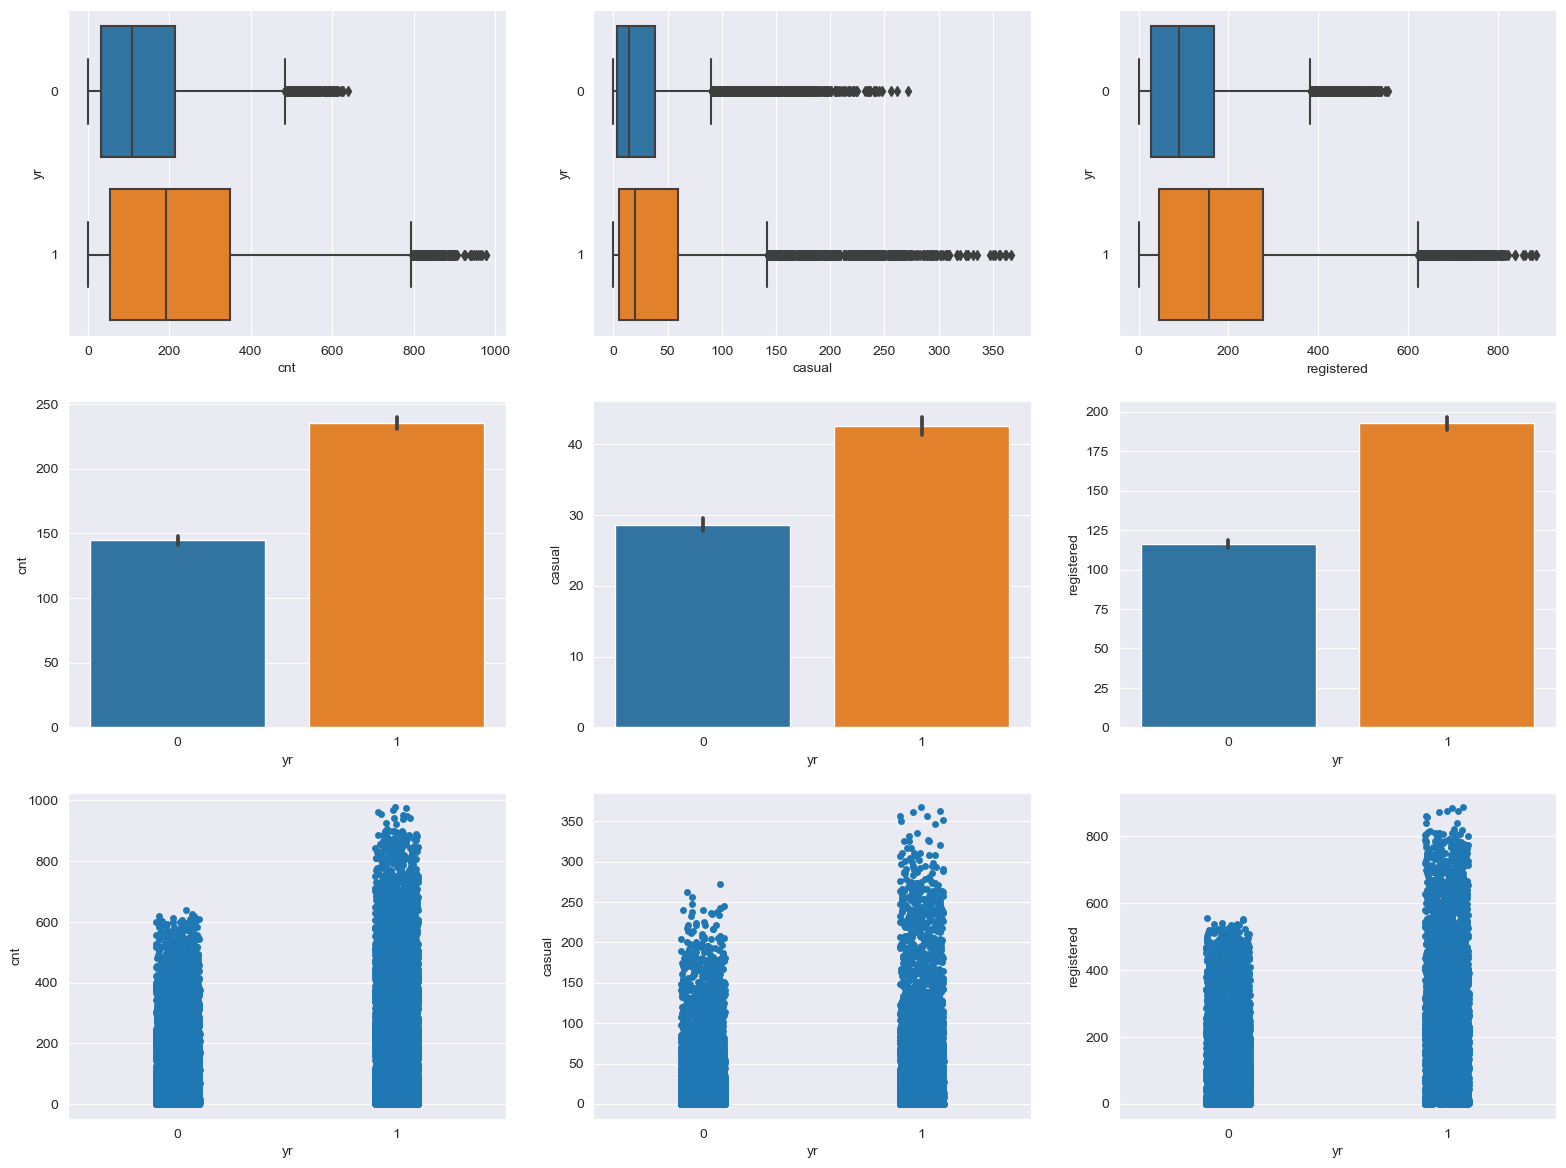

In [40]:
correlate_feature_target_discrete(trainBikes, "yr", ["cnt", "casual", "registered"])

**results:**
From the phik_matrix, it's calculated that yr has a .21 correlation with casual, a .34 correlation with cnt and a .35 correlation with registered.
This implies a weak to moderate correlation. The graphs further explore this by showing a general increase in targets for yr 1 over yr 0.

**Conclusion:**
yr is an alright predictor for each target, with it's best prediction being the registered target.

#### Feature: mnth, Targets: casual, registered, cnt
Invetigate the mnth feature against the targets

interval columns not set, guessing: ['mnth', 'cnt', 'casual', 'registered']


                mnth       cnt    casual  registered		       count        mean         std  min    25%    50%    75%    max
mnth        1.000000  0.319839  0.388460    0.293280		mnth                                                                 
cnt         0.319839  1.000000  0.749156    0.964658		1     1164.0   93.552405  100.533409  1.0  21.00   64.5  124.0  559.0
casual      0.388460  0.749156  1.000000    0.624457		2     1083.0  111.372114  109.793753  1.0  29.00   80.0  163.5  610.0
registered  0.293280  0.964658  0.624457    1.000000		3     1145.0  154.573799  164.260469  1.0  28.00  101.0  224.0  957.0
                                                    		4     1136.0  185.139085  177.905331  1.0  36.00  136.0  276.5  819.0
                                                    		5     1193.0  223.223806  185.672262  1.0  60.00  191.0  333.0  873.0
                                                    		

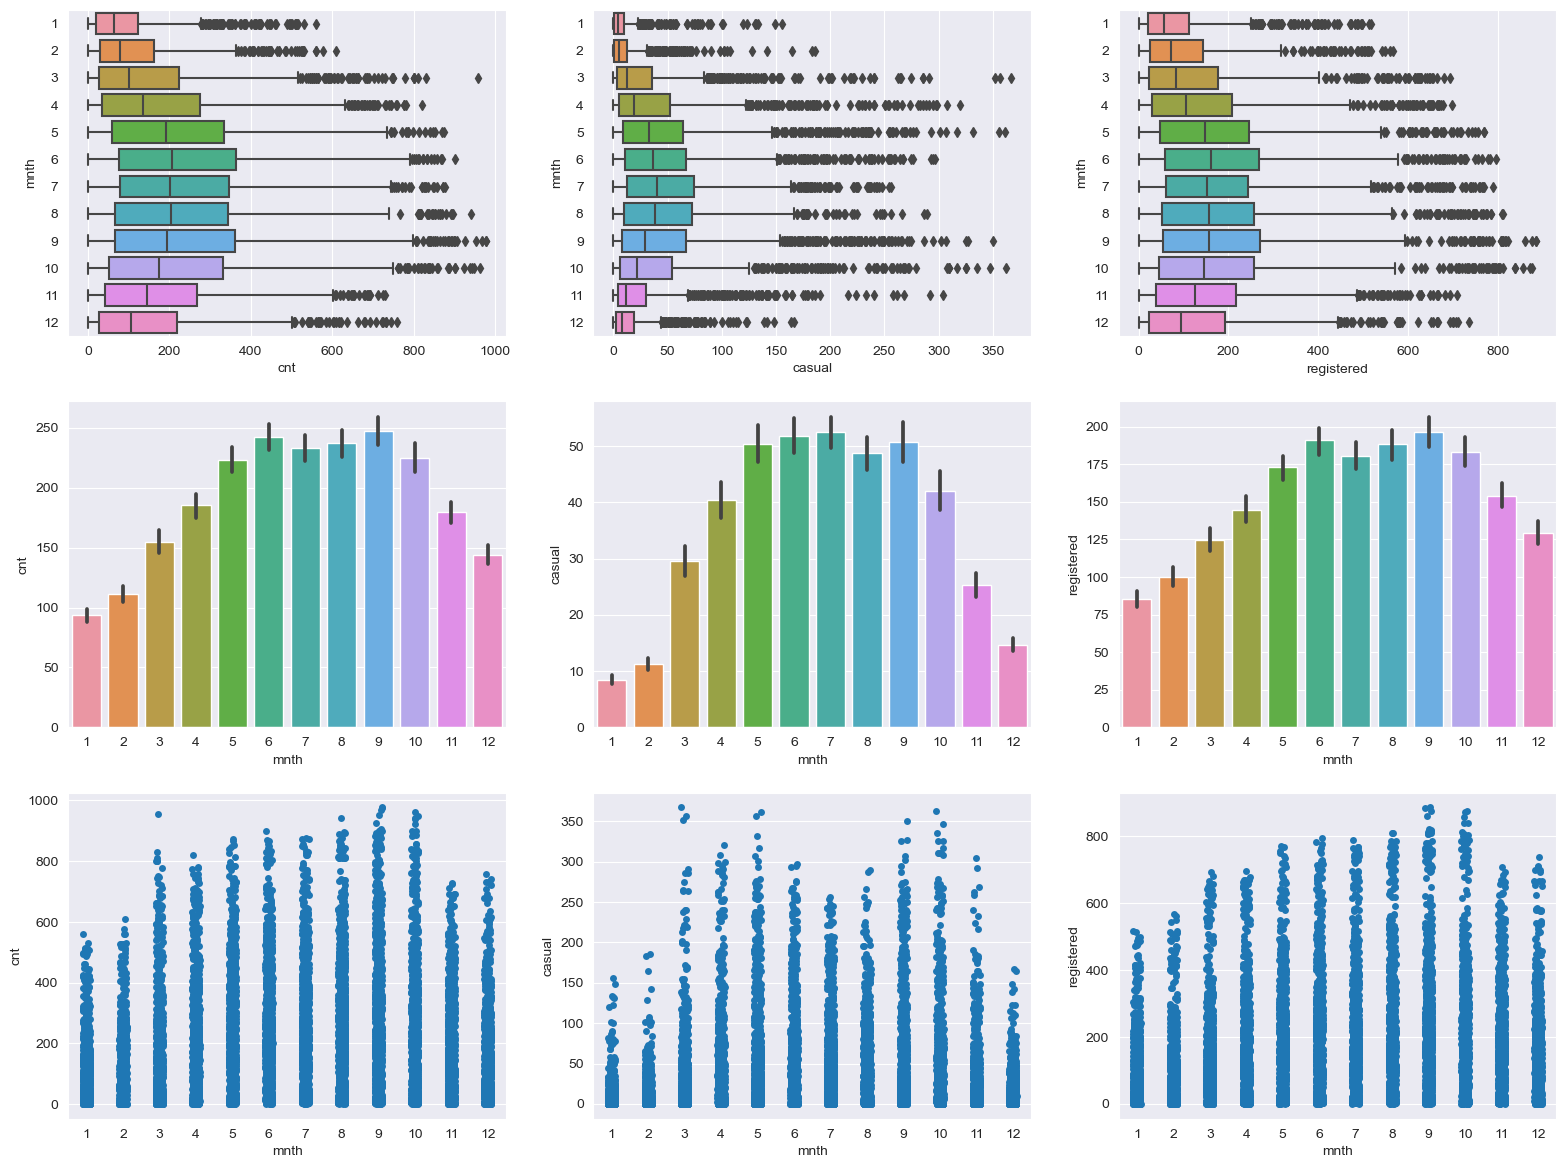

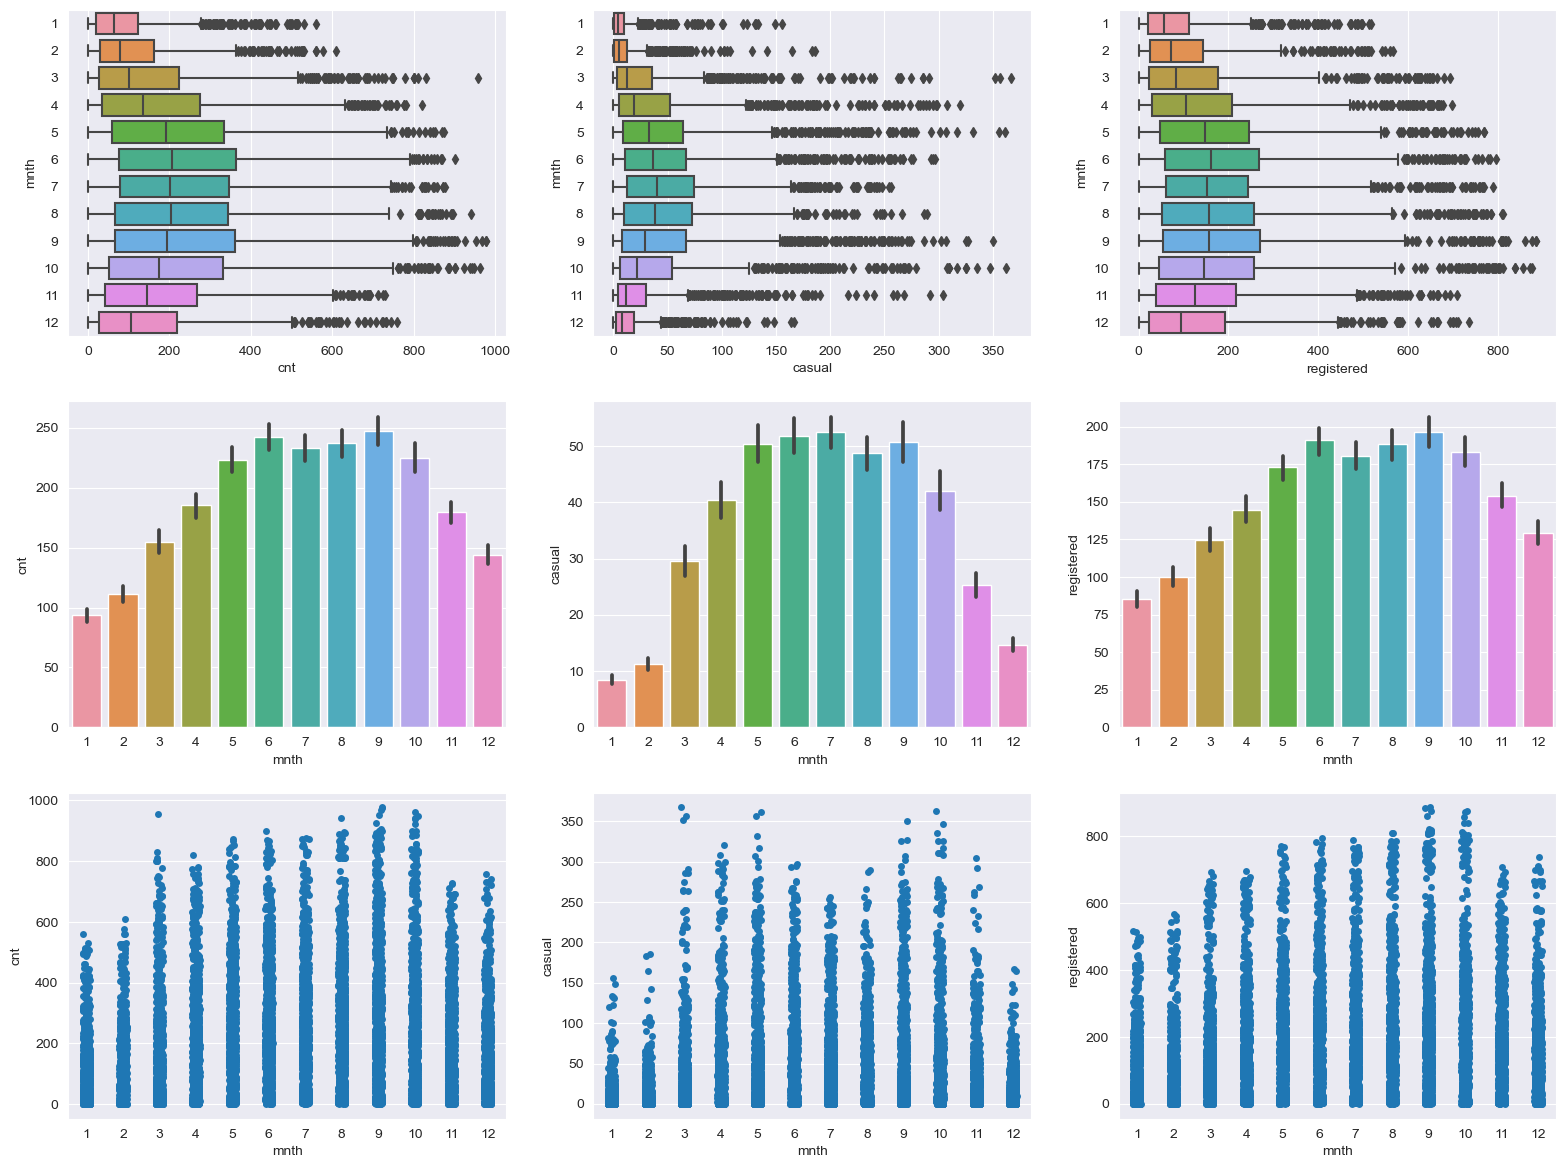

In [41]:
correlate_feature_target_discrete(trainBikes, "mnth", ["cnt", "casual", "registered"])

**results:**
From the phik_matrix, it's calculated that mnth has a .38 correlation with casual, a .31 correlation with cnt and a .29 correlation with registered.
This implies a weak to moderate correlation. The graph further explore a weak relationship by showing mostly slight changes in the targets per mnth.
With certain mnths such as 1,2,12 seeing bigger changes.

**Conclusion:**
mnth can be a good predictor for the targets but should be used in conjunction with another.

#### Feature: hr, Targets: casual, registered, cnt ####
Investigate the hr feature for the targets.

interval columns not set, guessing: ['hr', 'cnt', 'casual', 'registered']


                  hr       cnt    casual  registered		    count        mean         std   min     25%    50%     75%    max
hr          1.000000  0.704523  0.561490    0.711724		hr                                                                   
cnt         0.704523  1.000000  0.749156    0.964658		0   574.0   53.918118   42.110160   2.0   25.25   40.0   69.00  249.0
casual      0.561490  0.749156  1.000000    0.624457		1   583.0   34.229846   34.325539   1.0   11.00   20.0   45.50  168.0
registered  0.711724  0.964658  0.624457    1.000000		2   562.0   23.016014   26.924495   1.0    5.00   11.0   29.00  132.0
                                                    		3   545.0   11.508257   13.138139   1.0    3.00    6.0   13.00   79.0
                                                    		4   568.0    6.396127    4.194115   1.0    3.00    6.0    8.00   28.0
                                                    		5 

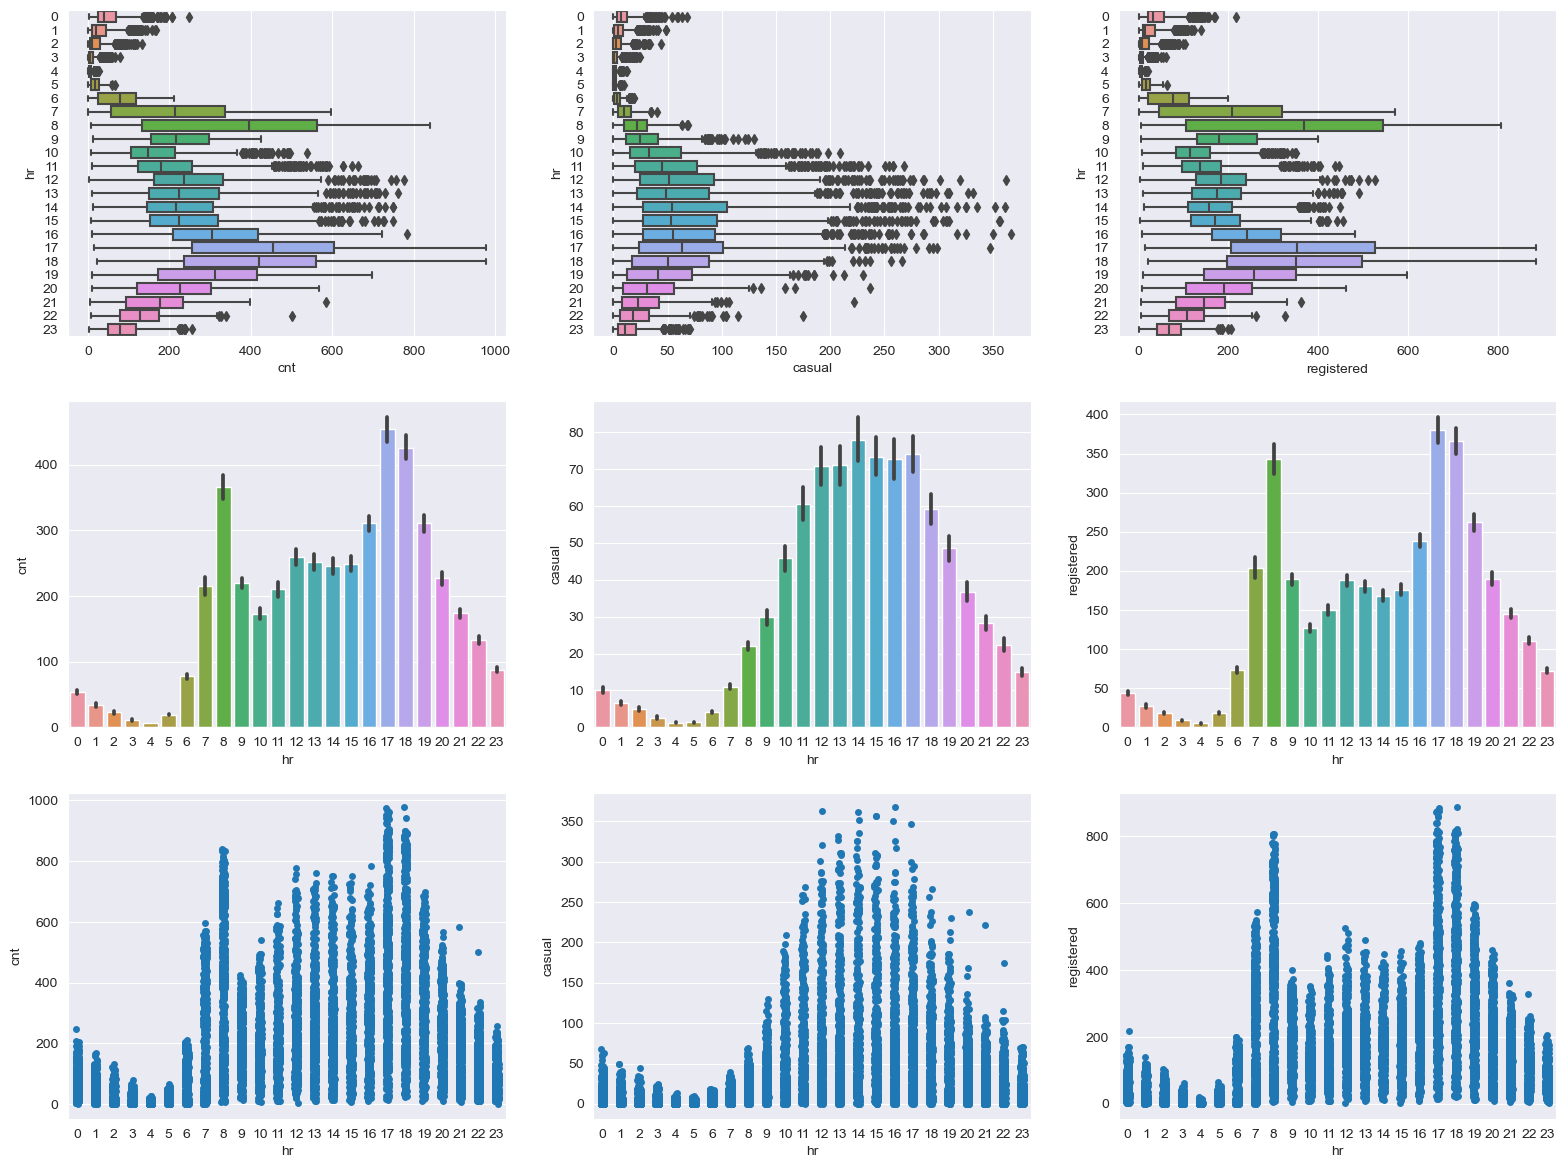

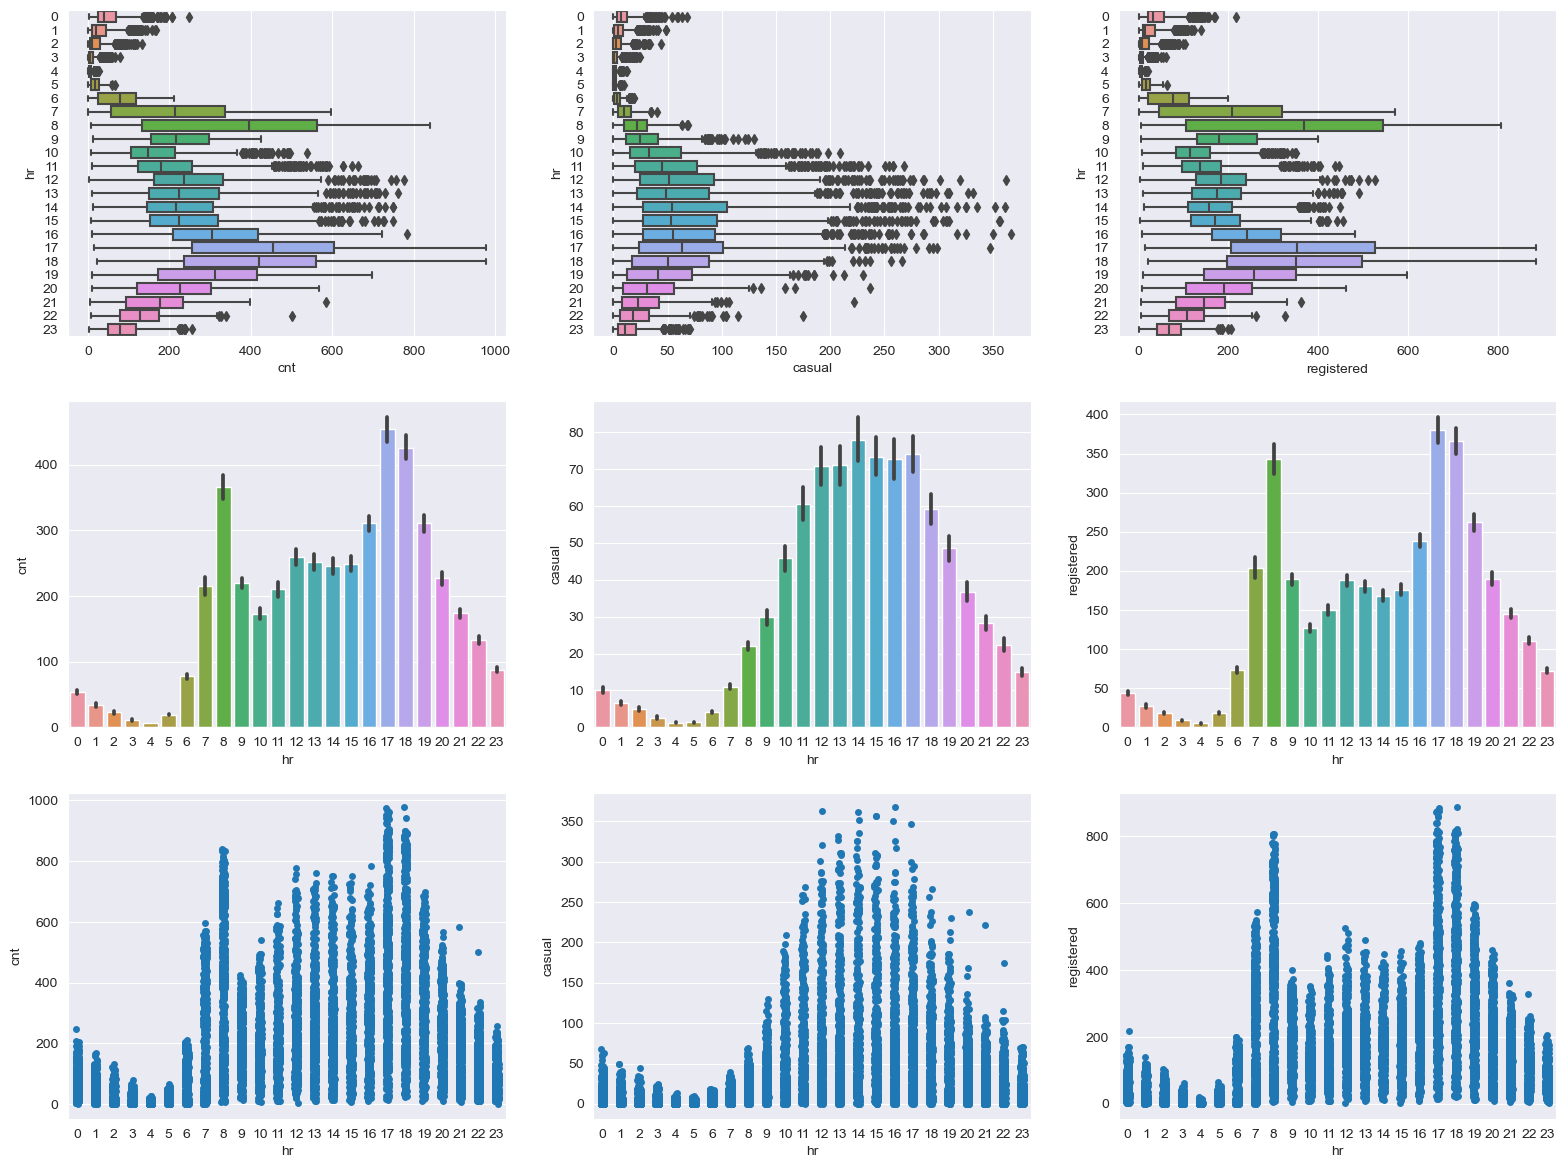

In [42]:
correlate_feature_target_discrete(trainBikes, "hr", ["cnt", "casual", "registered"])

**results:**
From the phik_matrix, it's calculated that hr has a .56 correlation with casual, a .70 correlation with cnt and a .71 correlation with registered.
This implies a strong to very strong correlation, depending on the target. The graphs further show this by a big difference in targets per mnth basis.

**Conclusion:**
hr is a very good predictor for cnt and registered and a good predictor for casual.

#### Feature: holiday, Target: casual, registered, cnt #####
Investigate the holiday feature against the targets.

interval columns not set, guessing: ['holiday', 'cnt', 'casual', 'registered']


             holiday       cnt    casual  registered		           count        mean         std  min   25%    50%    75%    max
holiday     1.000000  0.065781  0.072691    0.073501		holiday                                                                 
cnt         0.065781  1.000000  0.749156    0.964658		0        13500.0  191.368370  182.057393  1.0  41.0  145.0  284.0  977.0
casual      0.072691  0.749156  1.000000    0.624457		1          403.0  153.920596  155.950571  1.0  28.0   92.0  253.5  712.0
registered  0.073501  0.964658  0.624457    1.000000		                                                                        




           count       mean        std  min  25%   50%   75%    max		           count        mean         std  min   25%    50%    75%    max
holiday                                                            		holiday                                                              

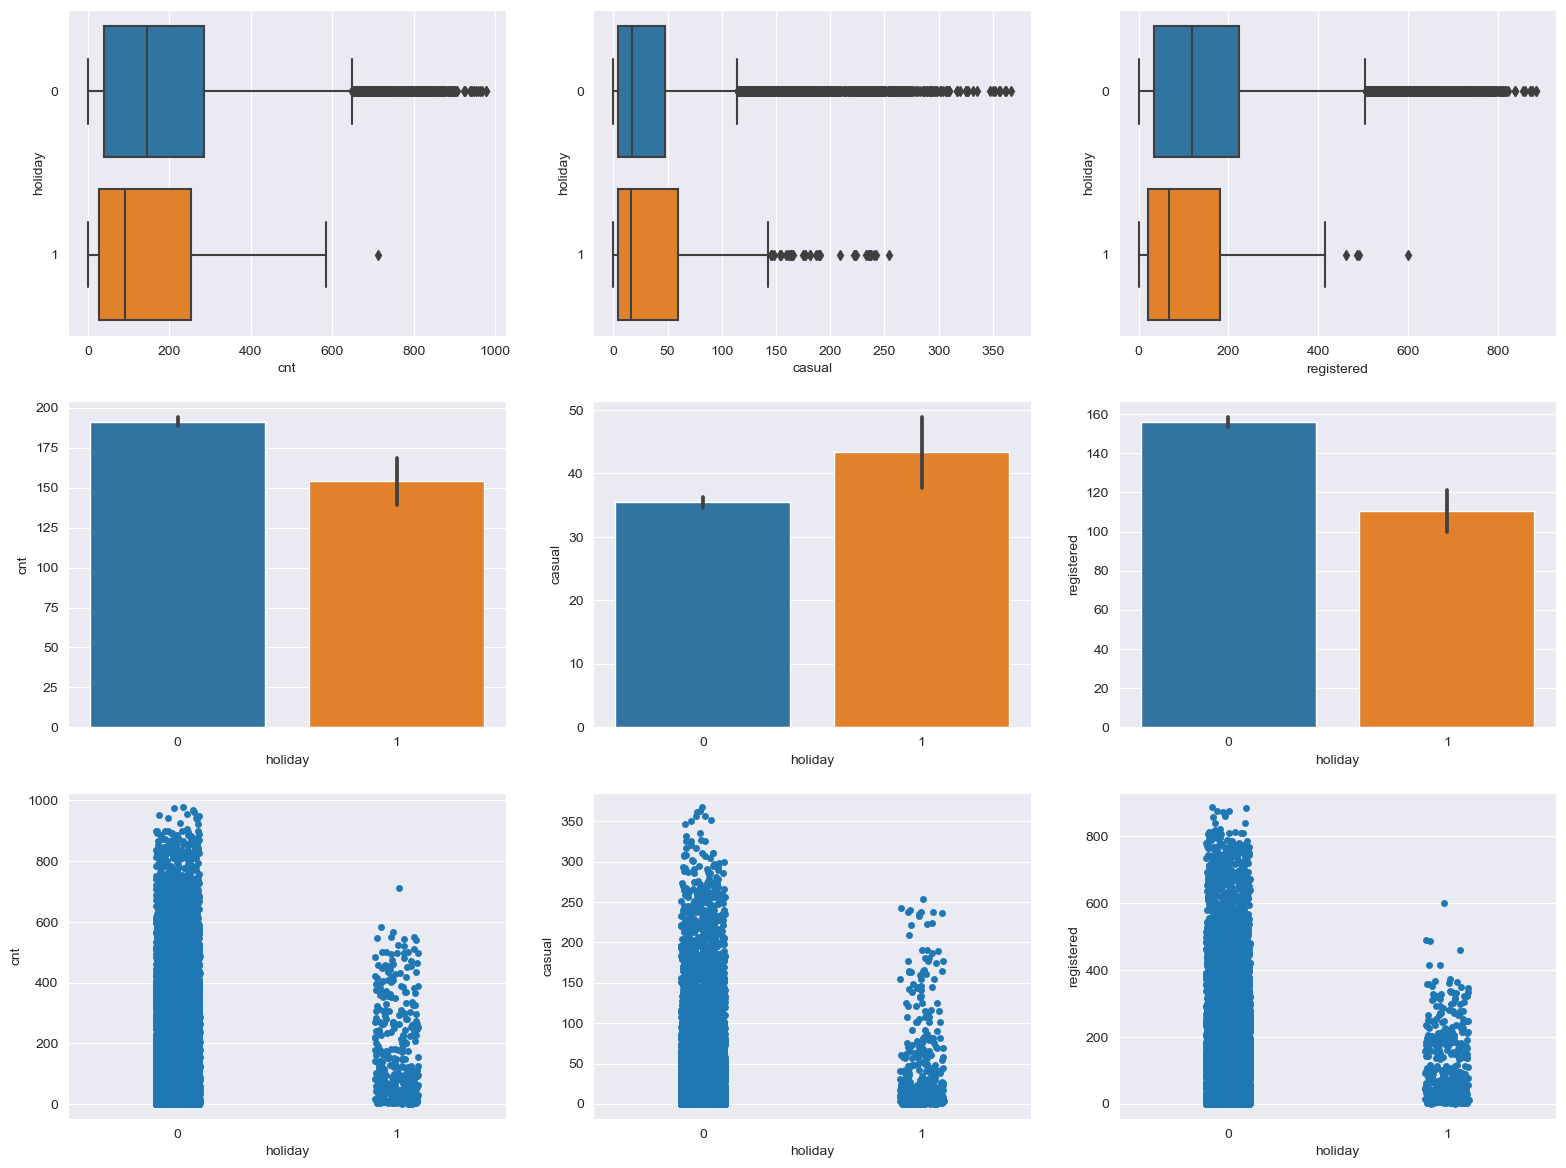

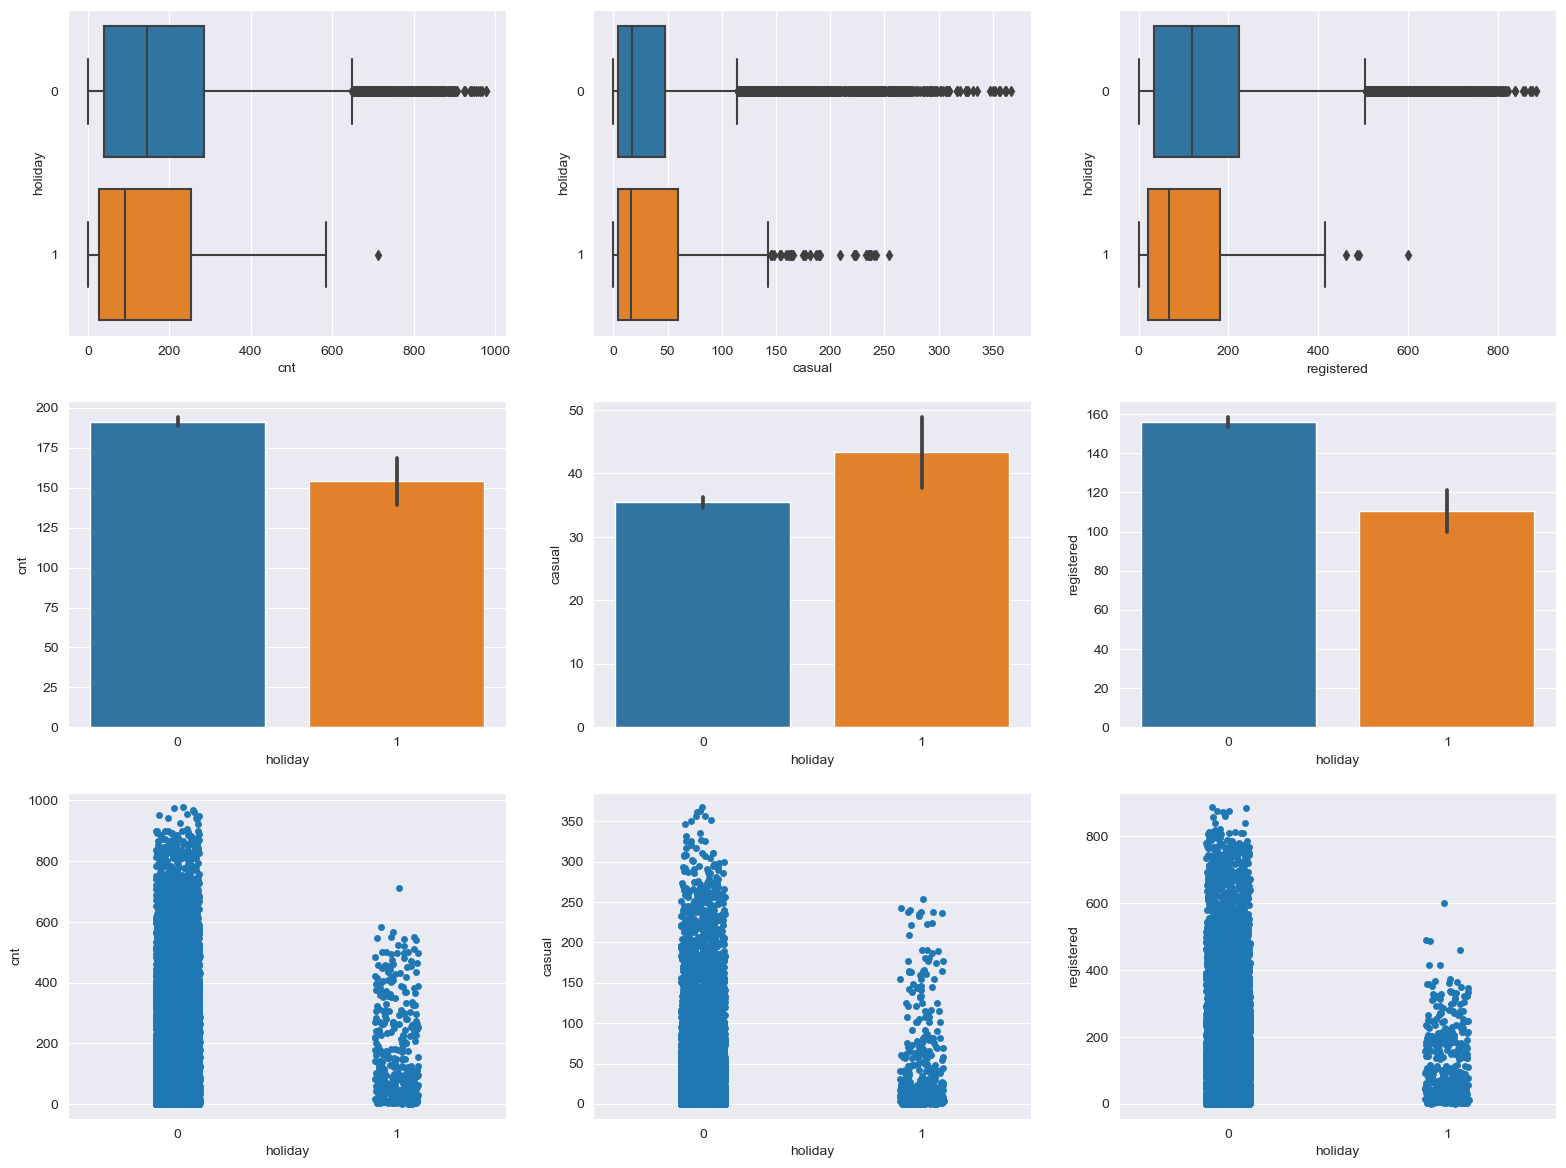

In [43]:
correlate_feature_target_discrete(trainBikes, "holiday", ["cnt", "casual", "registered"])

**results:**
From the phik_matrix, it's calculated that yr has a .07 correlation with casual, a .05 correlation with cnt and a .06 correlation with registered.
This implies a near-existant correlation. The graphs further explores this by showing minor changes in targets per holiday type.

**Conclusion:**
holiday is a bad predictor for targets.

#### Feature: weekday, Targets: casual, registered, cnt ####
Investigate the weekday feature for targets.

interval columns not set, guessing: ['weekday', 'cnt', 'casual', 'registered']


             weekday       cnt    casual  registered		          count        mean         std  min    25%    50%     75%    max
weekday     1.000000  0.103872  0.281008    0.136702		weekday                                                                  
cnt         0.103872  1.000000  0.749156    0.964658		0        2015.0  177.372208  167.607214  1.0  41.00  115.0  291.50  776.0
casual      0.281008  0.749156  1.000000    0.624457		1        1971.0  182.942161  180.424307  1.0  35.00  137.0  267.50  922.0
registered  0.136702  0.964658  0.624457    1.000000		2        2000.0  193.157500  187.795064  1.0  36.00  149.0  280.00  967.0
                                                    		3        1984.0  192.354839  191.735898  1.0  36.00  144.0  279.00  977.0
                                                    		4        1941.0  197.704791  187.061553  1.0  45.00  156.0  283.00  976.0
                       

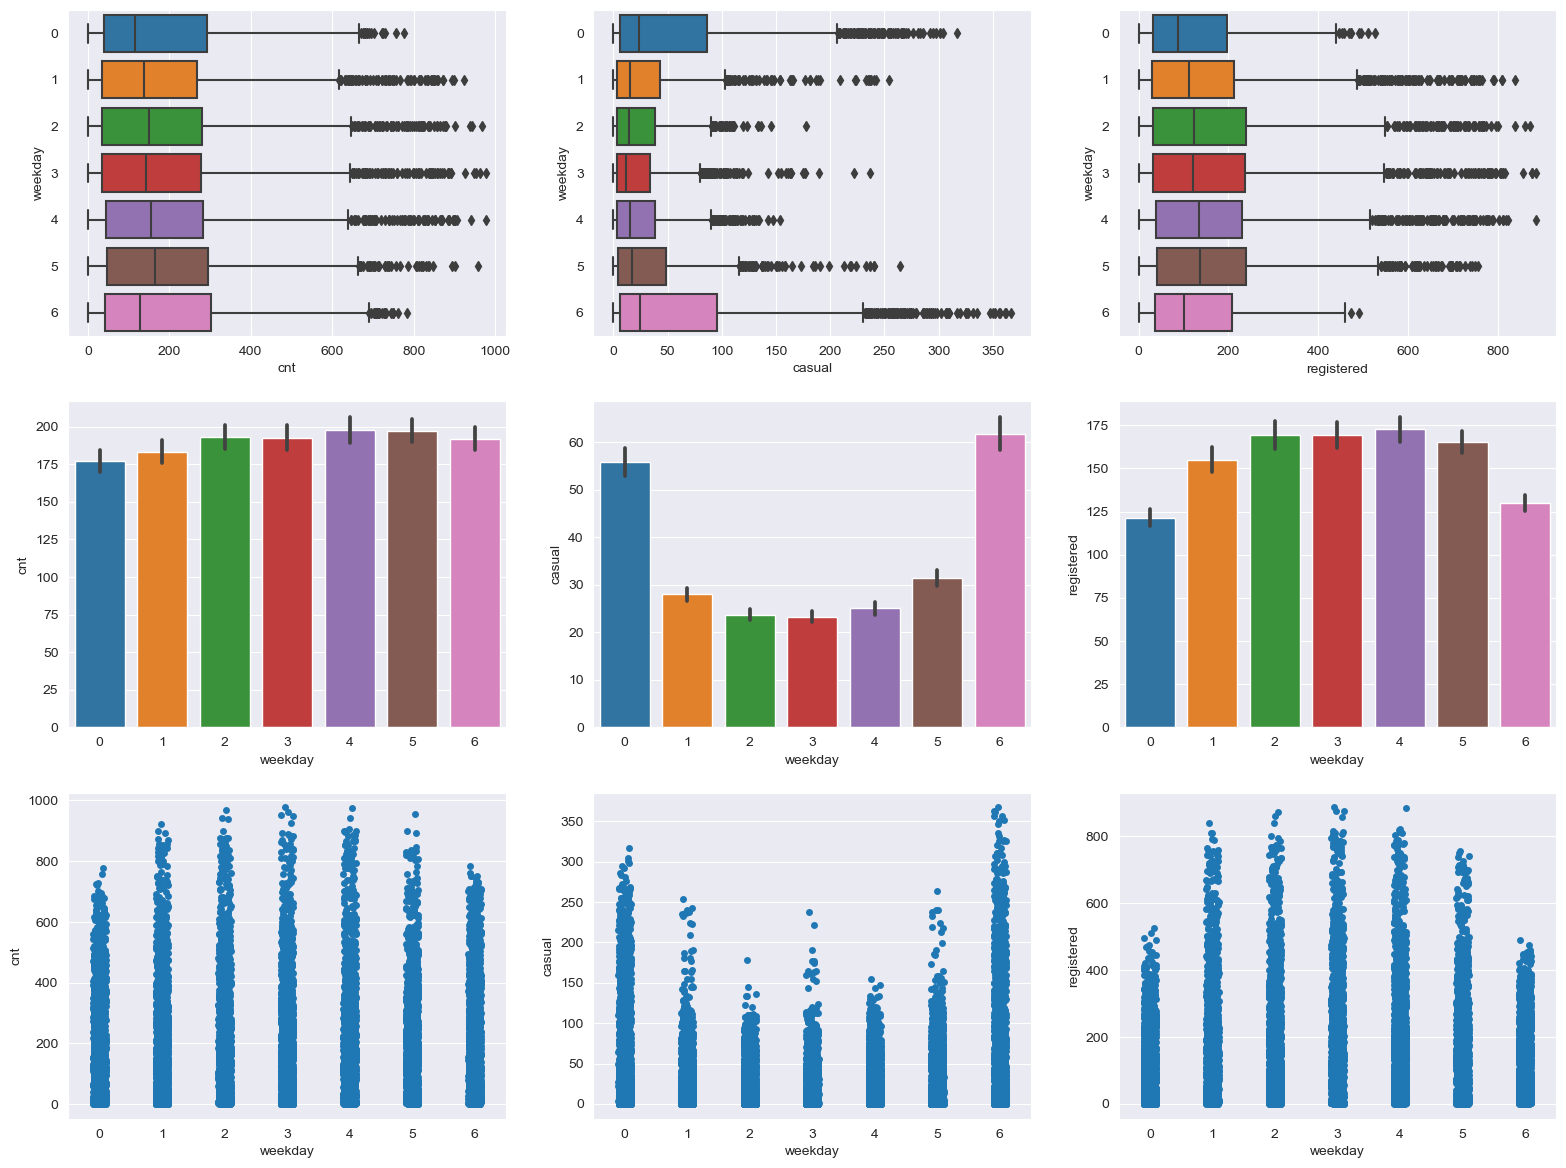

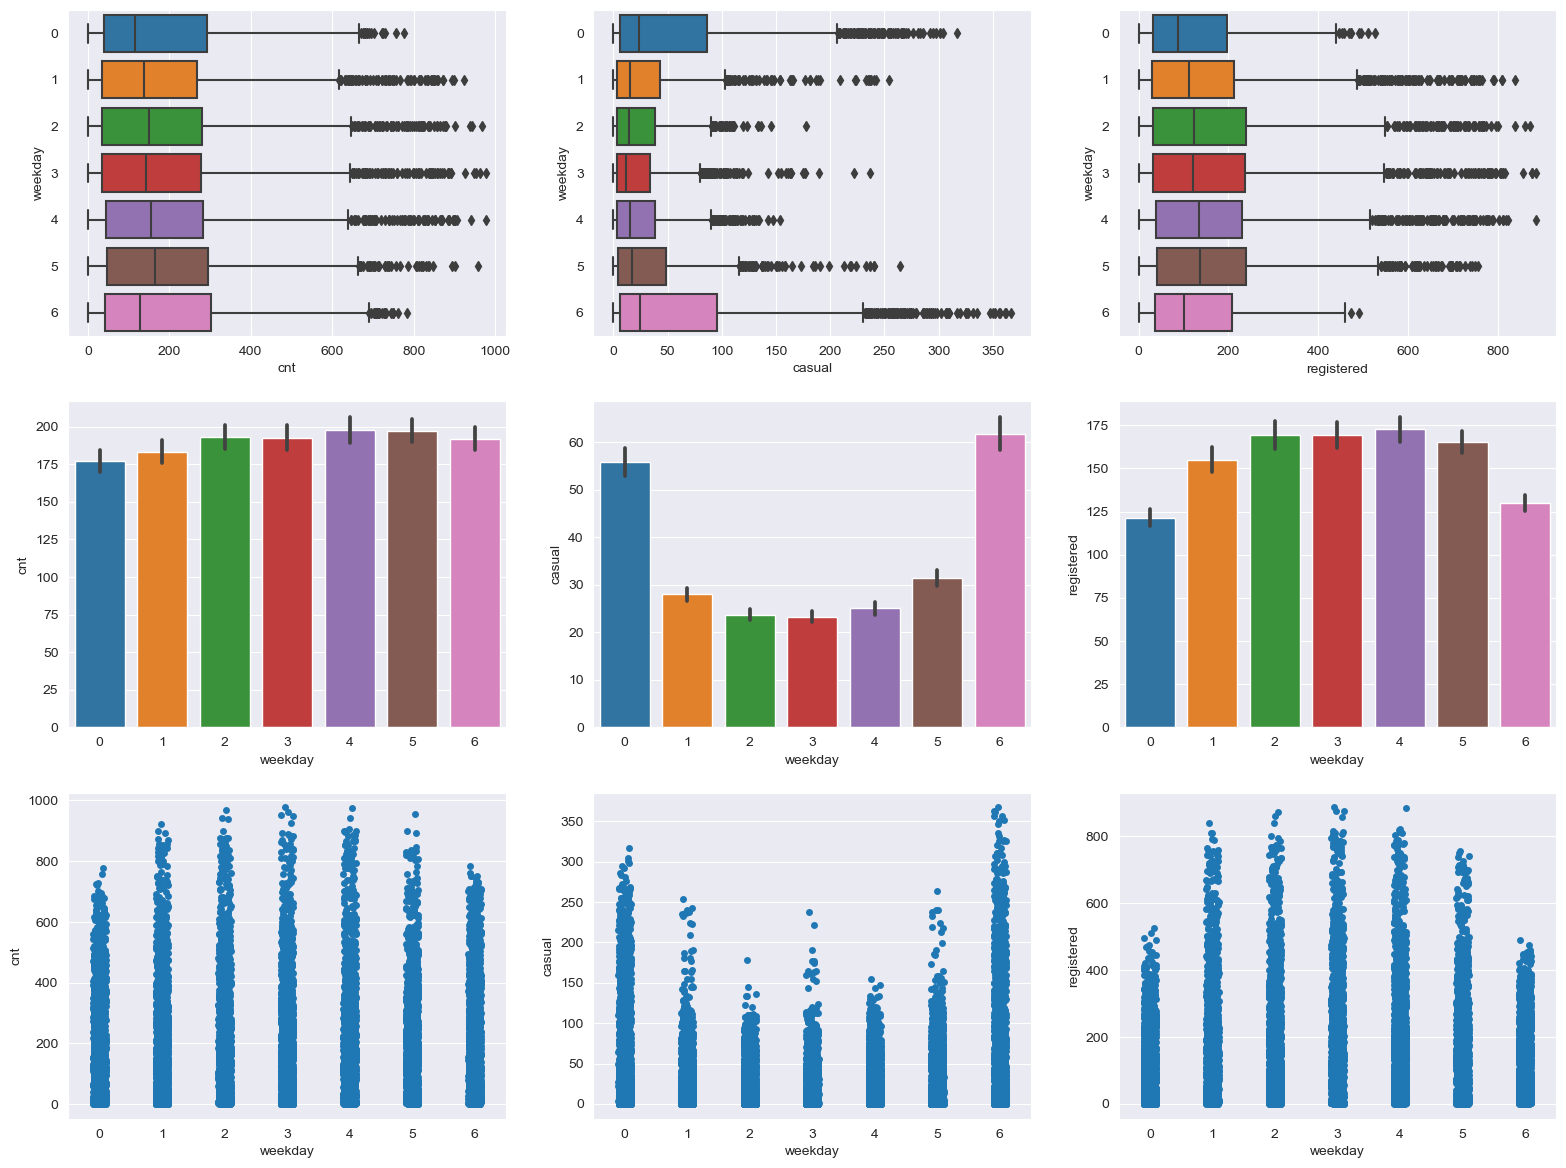

In [44]:
correlate_feature_target_discrete(trainBikes, "weekday", ["cnt", "casual", "registered"])

**results:**
From the phik_matrix, it's calculated that weekday has a .28 correlation with casual, a .10 correlation with cnt and a .13 correlation with registered.
This implies a very weak to weak correlation. The graphs further explore this by showing a relative lack of change between each weekday for each target.

**Conclusion:**
weekday is a bad predictor for targets.

#### Feature: workingday, Target: casual, registered, cnt ####
Investigate the workingday feature against the targets.

interval columns not set, guessing: ['workingday', 'cnt', 'casual', 'registered']


            workingday       cnt    casual  registered		             count        mean         std  min    25%    50%     75%    max
workingday    1.000000  0.158251  0.451415    0.223162		workingday                                                                  
cnt           0.158251  1.000000  0.749156    0.964658		0           4404.0  181.691417  173.313617  1.0  40.75  119.0  292.25  783.0
casual        0.451415  0.749156  1.000000    0.624457		1           9499.0  194.266133  184.985240  1.0  40.00  153.0  280.00  977.0
registered    0.223162  0.964658  0.624457    1.000000		                                                                            




             count       mean        std  min  25%   50%    75%    max		             count        mean         std  min   25%    50%     75%    max
workingday                                                            		workingday                 

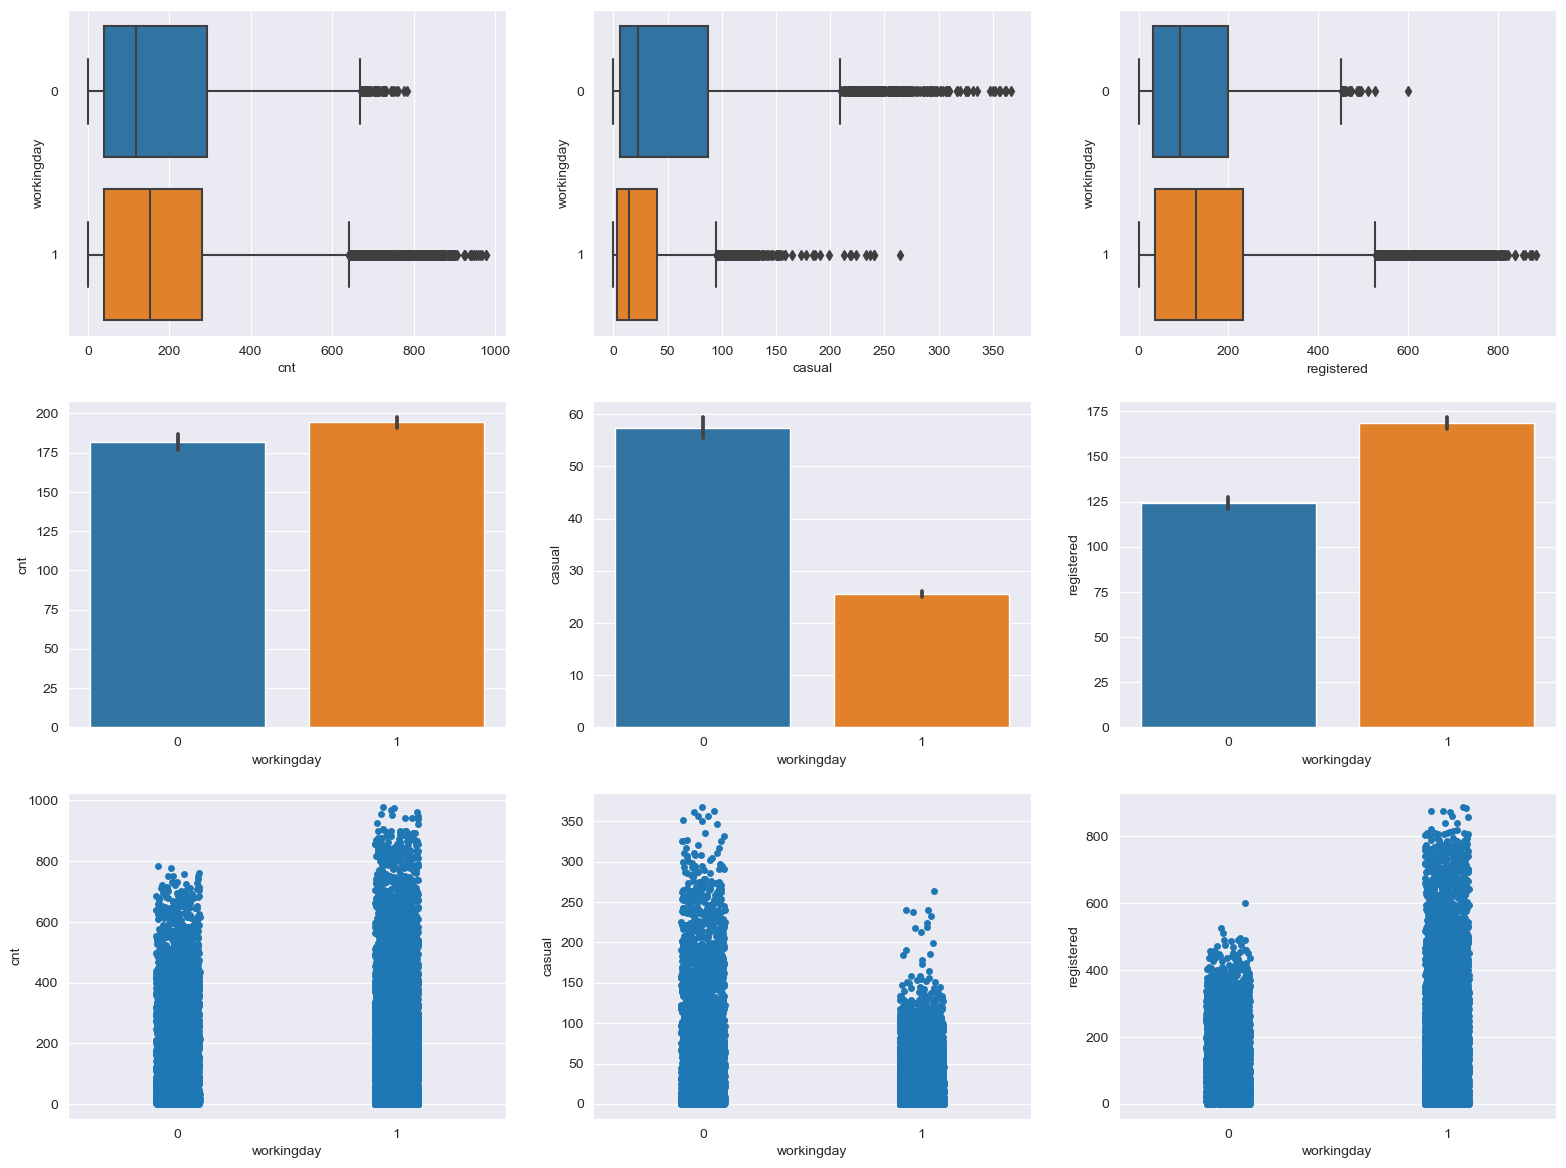

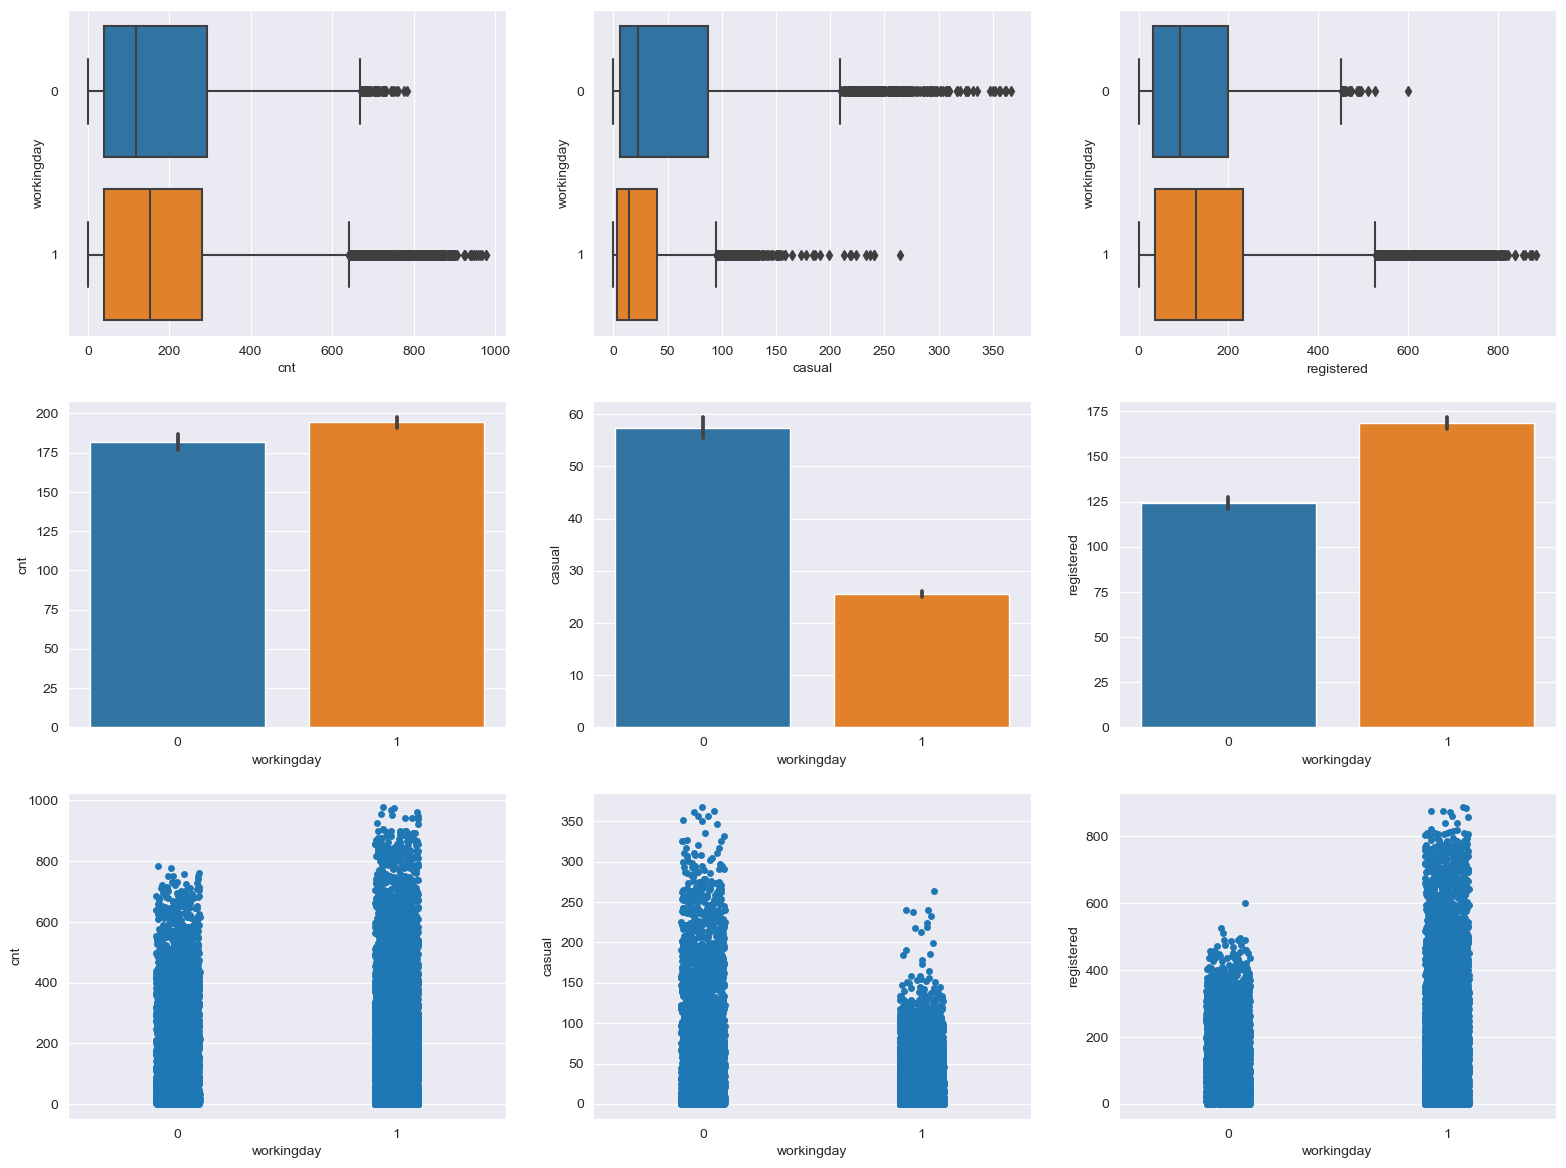

In [45]:
correlate_feature_target_discrete(trainBikes, "workingday", ["cnt", "casual", "registered"])

**results:**
From the phik_matrix, it's calculated that yr has a .45 correlation with casual, a .16 correlation with cnt and a .22 correlation with registered.
In this case, the feature correlation to each target is wildly different, with there being a very weak correlation to cnt, a slightly stronger correlation to registered,
and a good correlation for casual. The graphs further explore this by showing a general increase/decrease in targets for workiday 1 over workingday 0.

**Conclusion:**
workingday is a good predictor for casual, but useless for the other targets.

#### Feature: weathersit, Targets: casual, registered, cnt ####
Investigate the weathersit feature against the targets.

interval columns not set, guessing: ['weathersit', 'cnt', 'casual', 'registered']


            weathersit       cnt    casual  registered		             count        mean         std   min   25%    50%    75%    max
weathersit    1.000000  0.150880  0.153236    0.137896		weathersit                                                                 
cnt           0.150880  1.000000  0.749156    0.964658		1           9124.0  205.964928  189.791707   1.0  47.0  161.0  306.0  977.0
casual        0.153236  0.749156  1.000000    0.624457		2           3650.0  175.008493  164.782124   1.0  40.0  133.0  258.0  957.0
registered    0.137896  0.964658  0.624457    1.000000		3           1126.0  113.032860  133.934537   1.0  21.0   65.0  155.0  891.0
                                                      		4              3.0   74.333333   77.925178  23.0  29.5   36.0  100.0  164.0




             count       mean        std  min  25%   50%   75%    max		             count        mean         std   min 

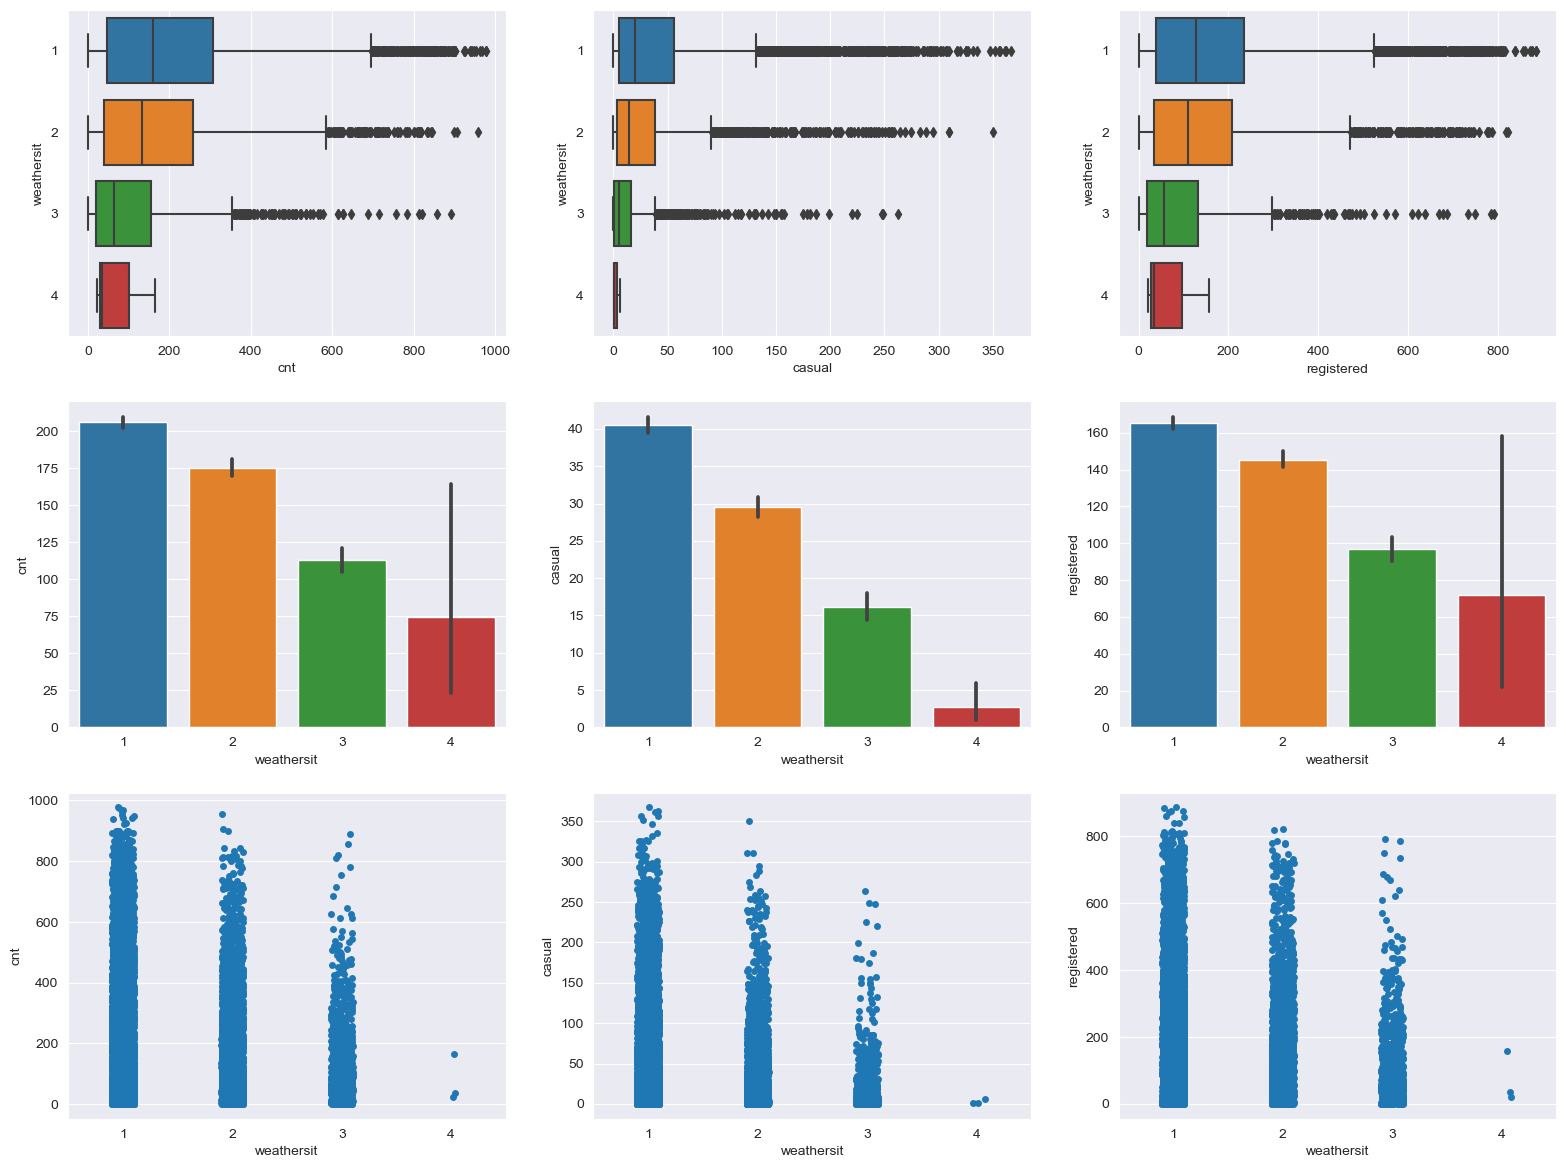

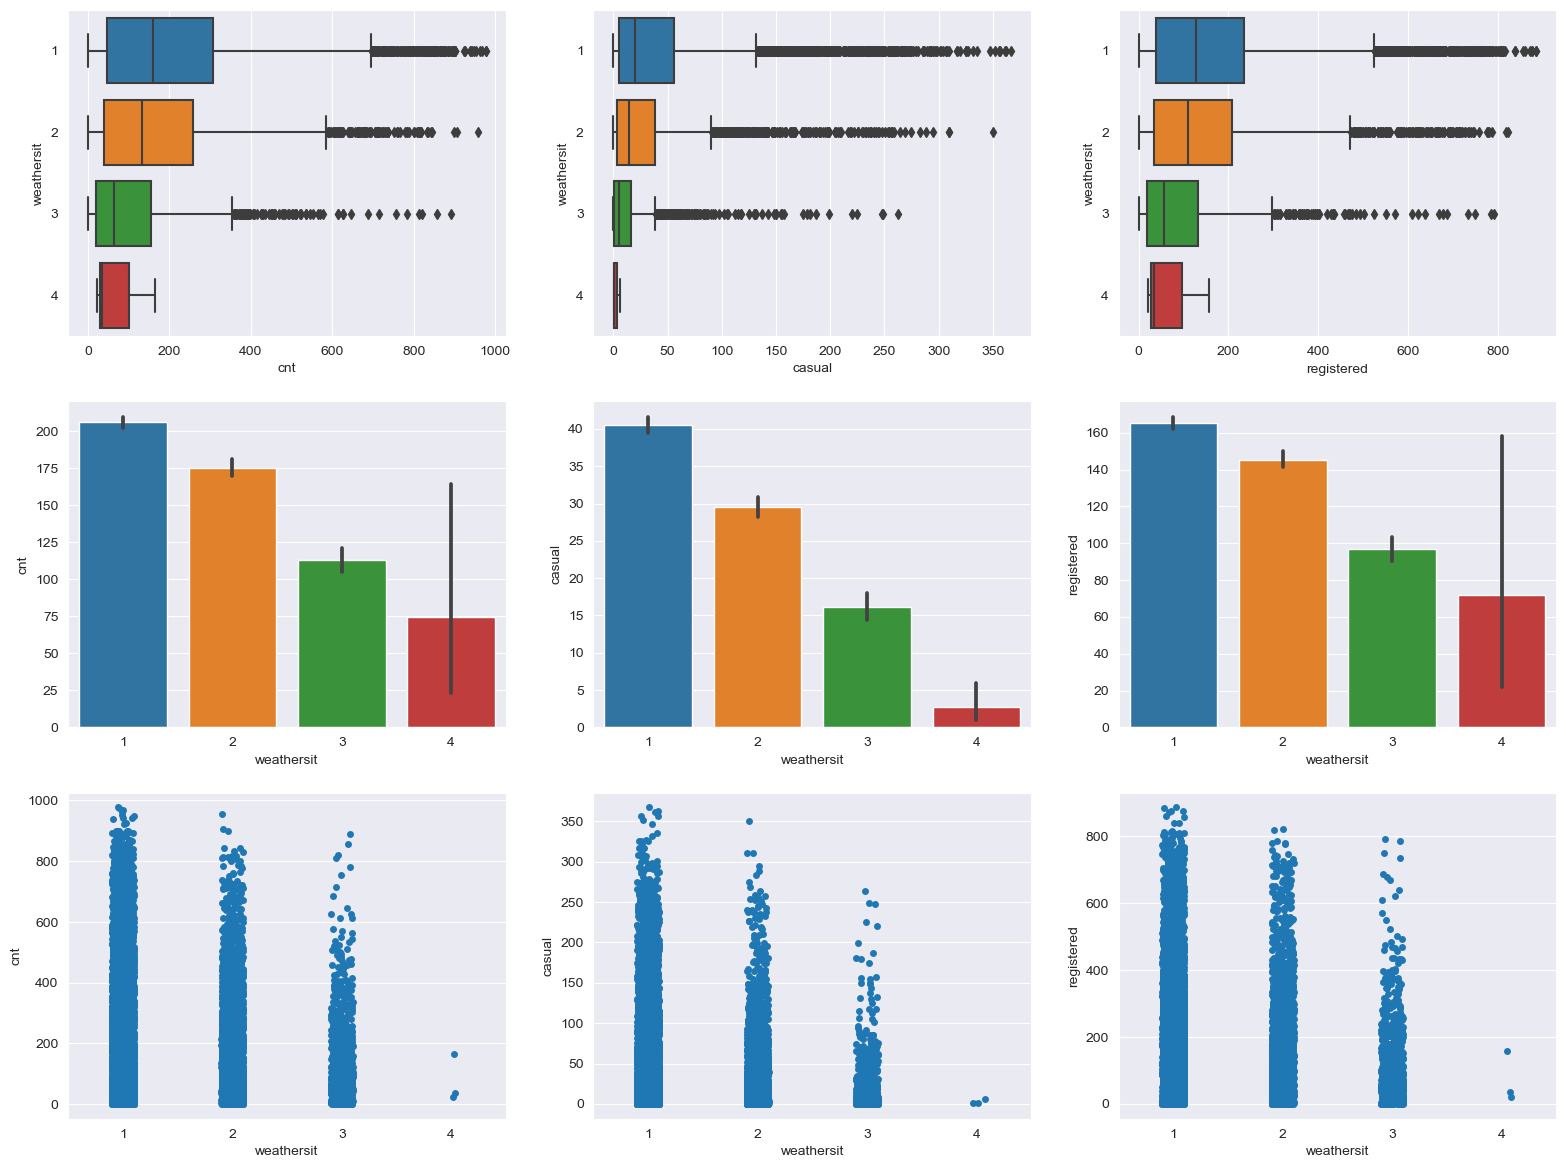

In [46]:
correlate_feature_target_discrete(trainBikes, "weathersit", ["cnt", "casual", "registered"])

**results:**
From the phik_matrix, it's calculated that weathersit has a .14 correlation with casual, a .14 correlation with cnt and a .13 correlation with registered.
This implies a very weak correlation. The graphs show a different relationship, with varying target values for different weathersit,
but this could be affected by the general distribution of the weathersit feature.

**Conclusion:**
weathersit is probably a bad predictor for targets.

#### Feature: temp, Targets: casual, registered, cnt ####
Investigate the temp feature against the targets.



                temp       cnt    casual  registered		                temp       cnt    casual  registered
temp        1.000000  0.406309  0.463394    0.335886		temp        1.000000  0.426042  0.574309    0.375586
cnt         0.406309  1.000000  0.692928    0.972152		cnt         0.426042  1.000000  0.849900    0.989459
casual      0.463394  0.692928  1.000000    0.504662		casual      0.574309  0.849900  1.000000    0.780626
registered  0.335886  0.972152  0.504662    1.000000		registered  0.375586  0.989459  0.780626    1.000000




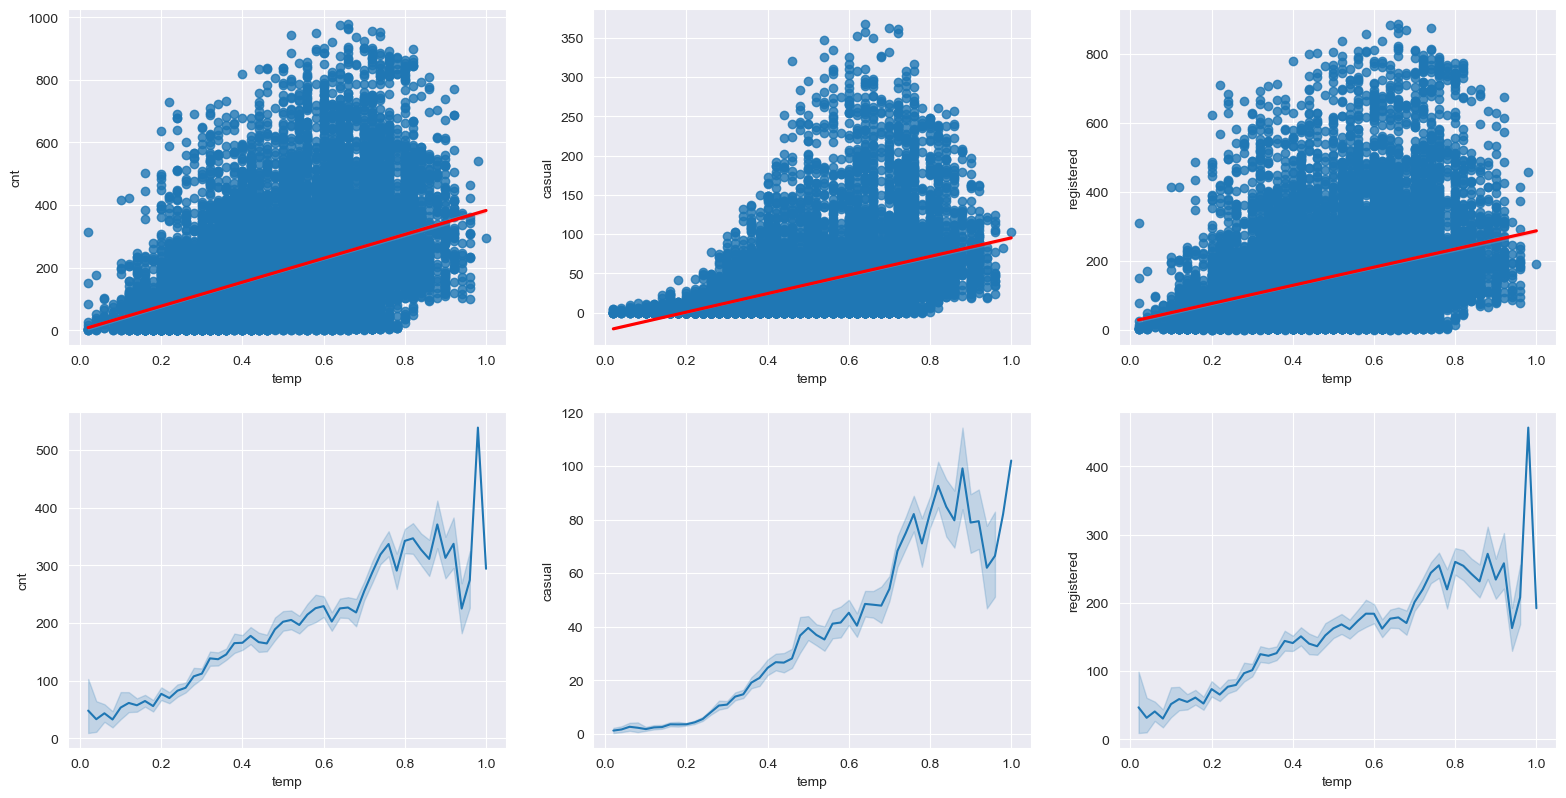

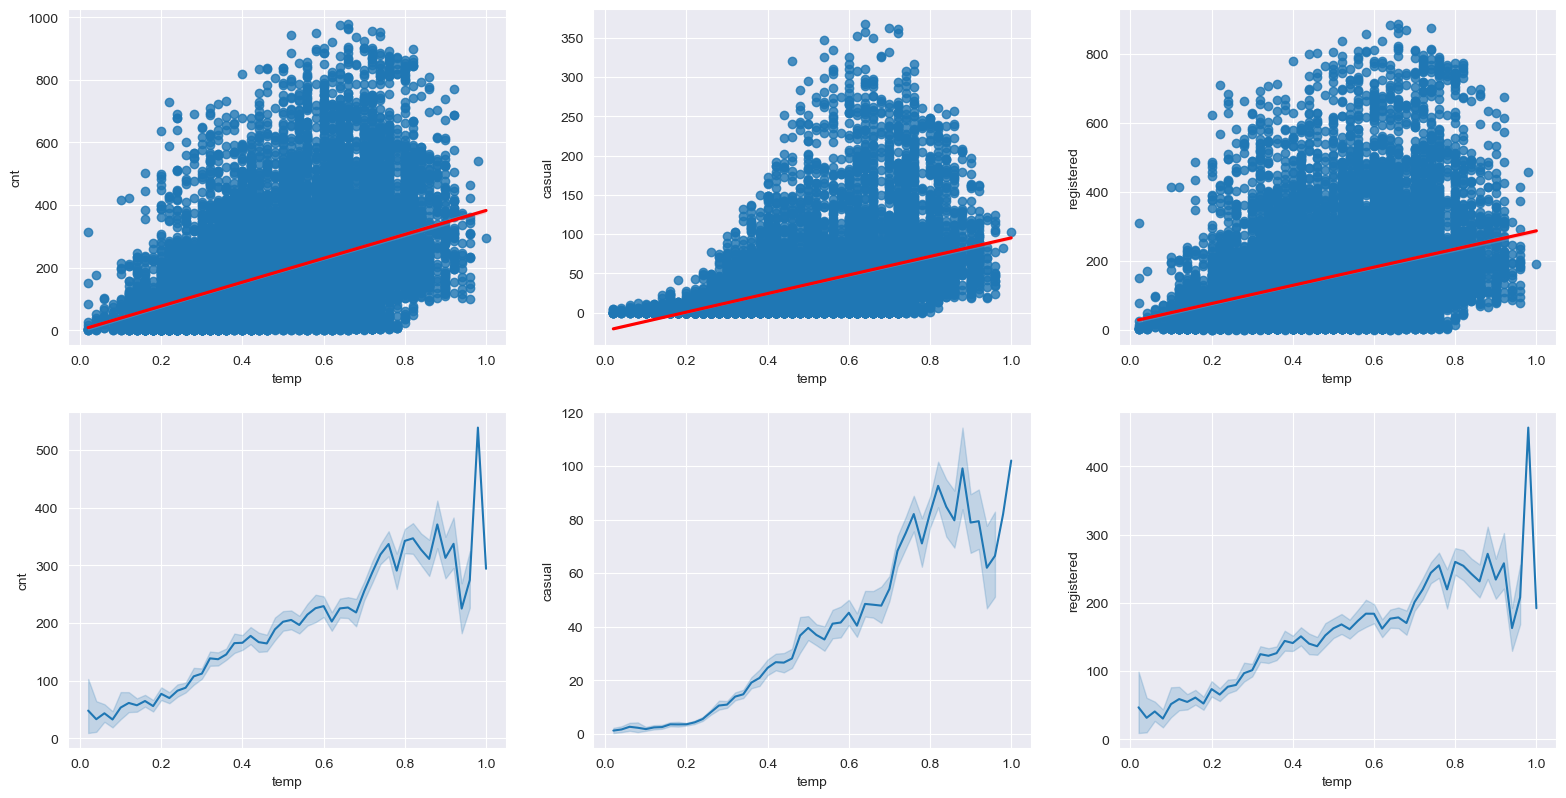

In [47]:
correlate_feature_target_continous(trainBikes, "temp", ["cnt", "casual", "registered"])

**Results:**
The pearson correlation calculates the following temp : cnt, casual, registerd correlations: .40, .45, .33.
The spearman correlation calculates slightly higher correlations at: .42, .57, .37.
The regplots are swarmed with data and can be a bit hard to make out but with the regression line, a moderate positive relationship can be determined.

**Conclusion:**
temp can be a backup predictor for targets.

#### Feature: hum, Targets: casual, registered, cnt ####
Investigate the hum feature against the targets.



                 hum       cnt    casual  registered		                 hum       cnt    casual  registered
hum         1.000000 -0.314666 -0.340337   -0.266153		hum         1.000000 -0.351997 -0.385512   -0.330623
cnt        -0.314666  1.000000  0.692928    0.972152		cnt        -0.351997  1.000000  0.849900    0.989459
casual     -0.340337  0.692928  1.000000    0.504662		casual     -0.385512  0.849900  1.000000    0.780626
registered -0.266153  0.972152  0.504662    1.000000		registered -0.330623  0.989459  0.780626    1.000000




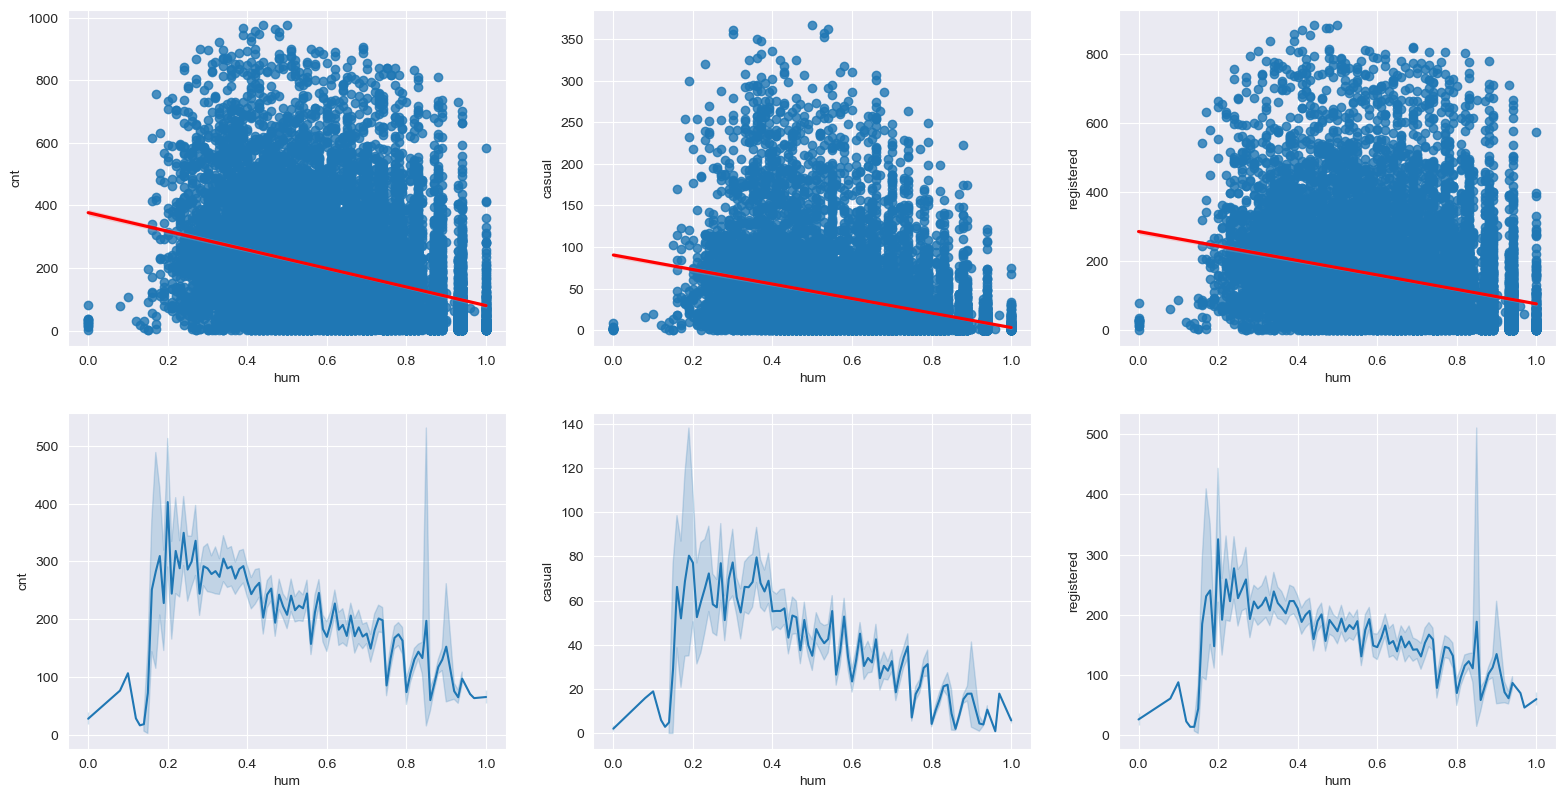

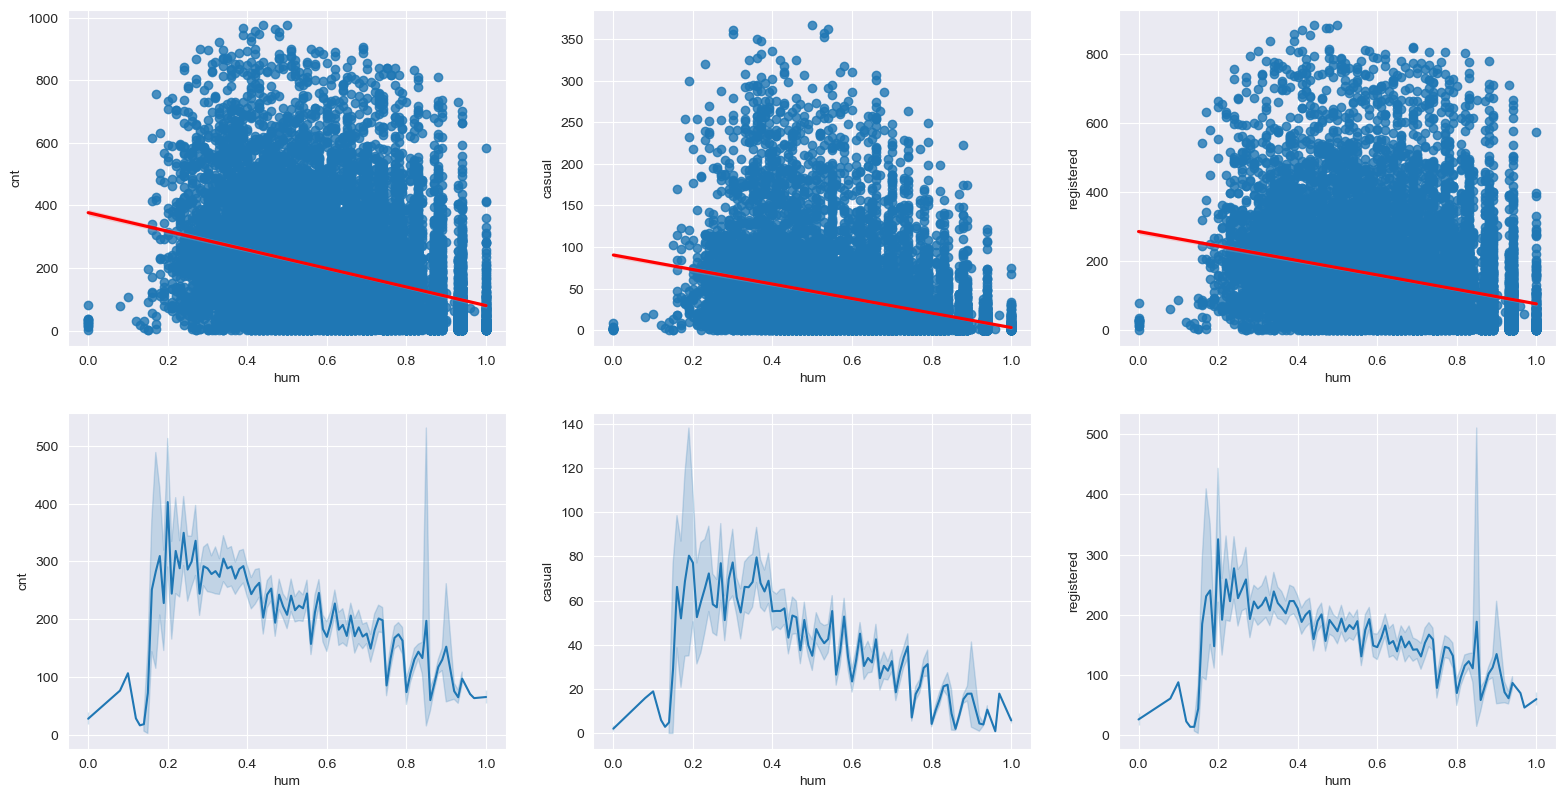

In [48]:
correlate_feature_target_continous(trainBikes, "hum", ["cnt", "casual", "registered"])

**Results:**
The pearson correlation calculates the following temp : cnt, casual, registerd  negative correlations: -.32, -.34, -.27.
The spearman correlation calculates slightly higher correlations at: -.35, -.38, -.33.
The regplots are swarmed with data and can be a bit hard to make out but with the regression line, a moderate negative relationship can be determined.

**Conclusion:**
hum is a bad predictor for targets.

#### Feature: windspeed, Targets: casual, registered, cnt ####
Investigate the windspeed feature against targets



            windspeed       cnt    casual  registered		            windspeed       cnt    casual  registered
windspeed    1.000000  0.090673  0.087325    0.080187		windspeed    1.000000  0.124167  0.122899    0.120164
cnt          0.090673  1.000000  0.692928    0.972152		cnt          0.124167  1.000000  0.849900    0.989459
casual       0.087325  0.692928  1.000000    0.504662		casual       0.122899  0.849900  1.000000    0.780626
registered   0.080187  0.972152  0.504662    1.000000		registered   0.120164  0.989459  0.780626    1.000000




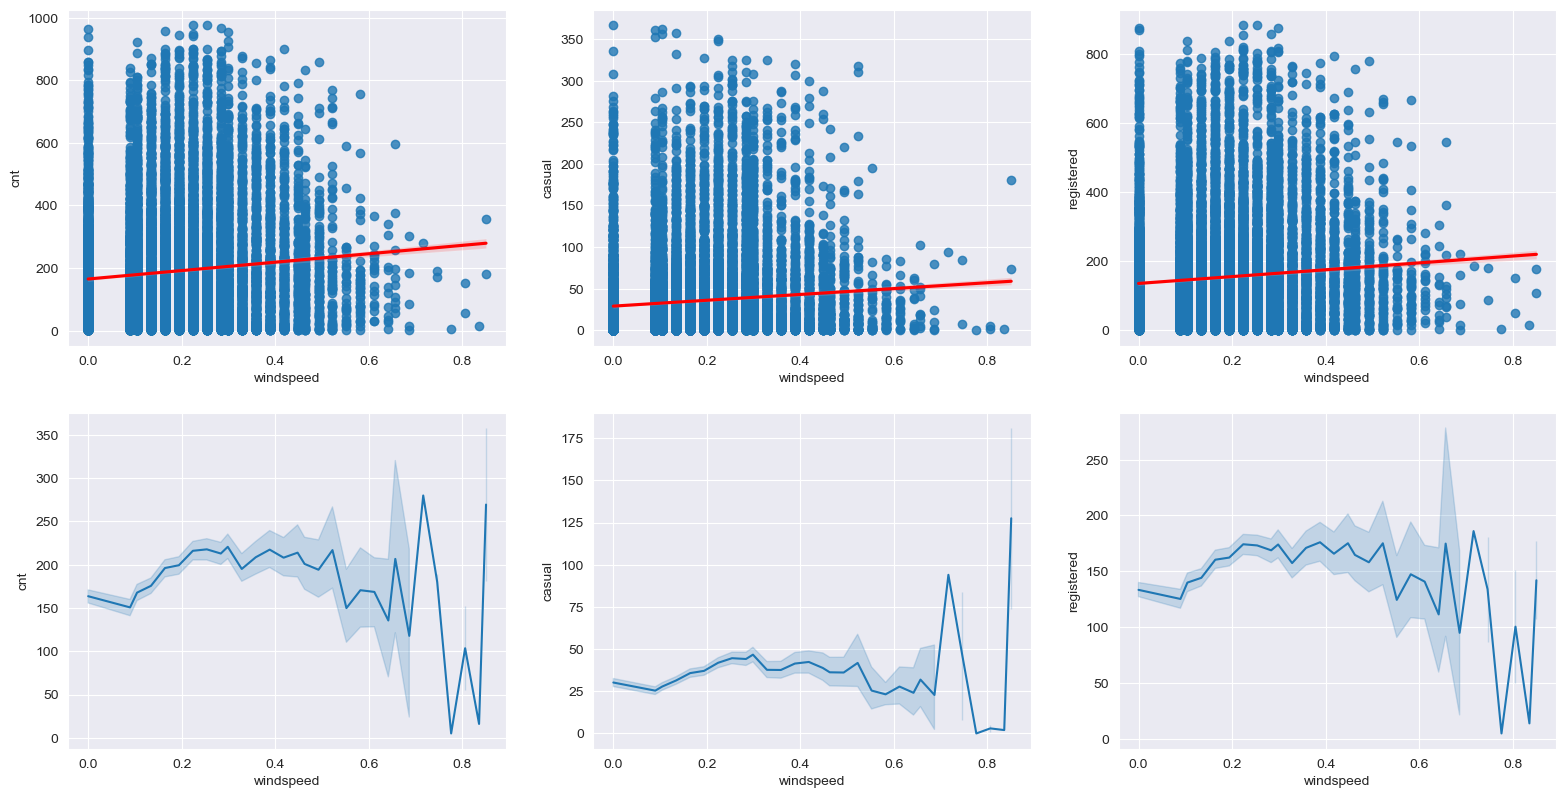

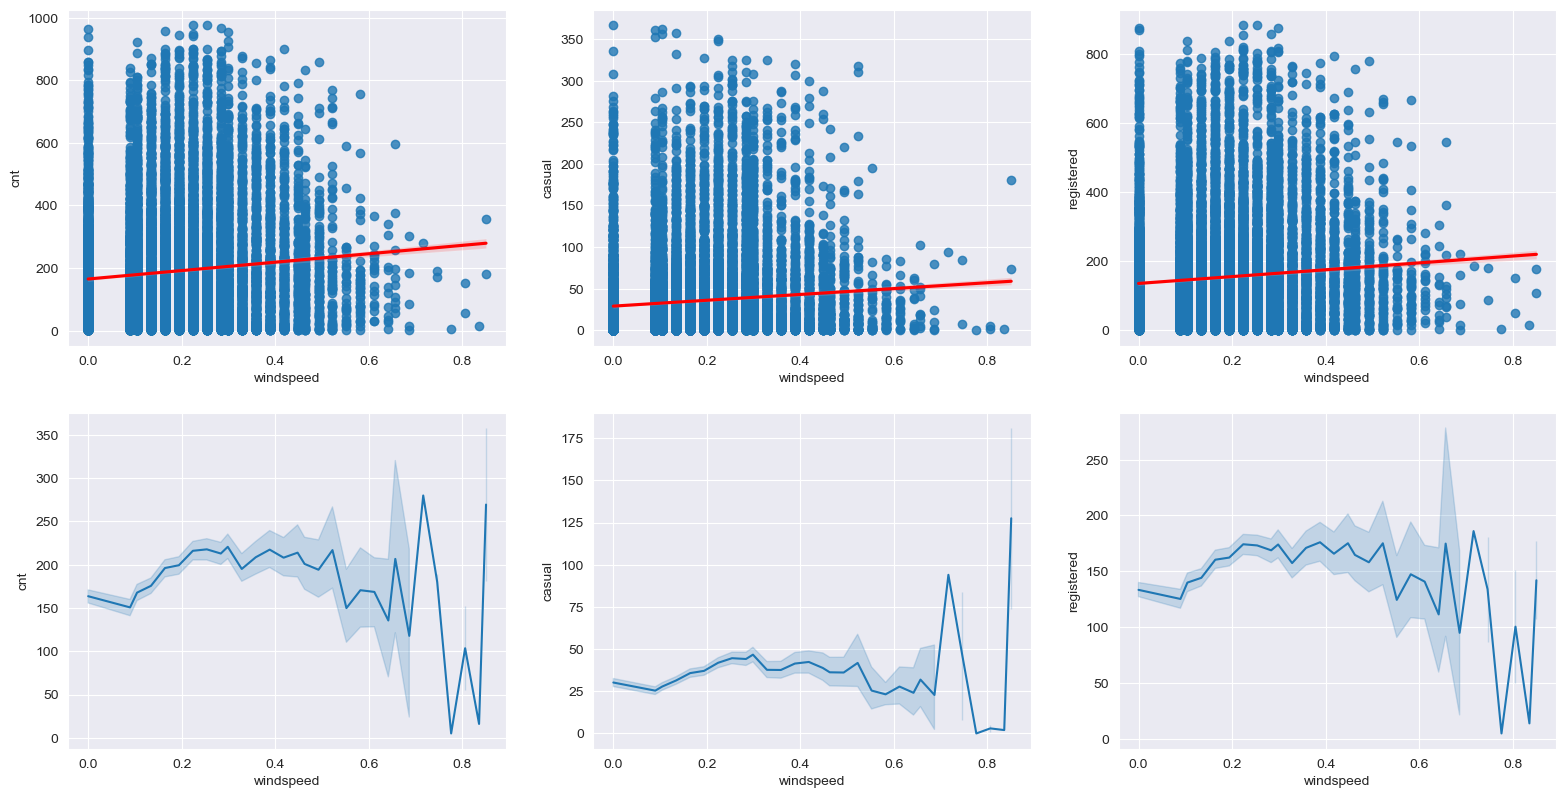

In [49]:
correlate_feature_target_continous(trainBikes, "windspeed", ["cnt", "casual", "registered"])

**Results:**
The pearson correlation calculates the following temp : cnt, casual, registerd correlations: .08, .08, .07.
The spearman correlation calculates slightly higher correlations at: .11, .11, .11.
The regplots are swarmed with data and can be a bit hard to make out but with the regression line, a a very weak positive relationship can be determined.

**Conclusion:**
windspeed is a bad predictor for targets.

#### Summary ####
Summary of feature to target correlations and whether they are a good predictor or not.  

| Feature    | Cnt Corr    | Casual Corr | Registered Corr | Evaluation                                   |
|:-----------|:------------|:------------|:----------------|:---------------------------------------------|
| yr         | 0.34        | 0.21        | 0.35            | Backup Predictor                             |
| mnth       | 0.31        | 0.38        | 0.28            | Backup Predictor                             |
| hr         | 0.70        | 0.56        | 0.71            | Very Good Predictor                          |
| holiday    | 0.05        | 0.07        | 0.06            | Bad                                          |
| weekday    | 0.1         | 0.27        | 0.13            | Bad                                          |
| workingday | 0.16        | 0.44        | 0.22            | Bad, except for Casual, where it can be Good |
| weathersit | 0.15        | 0.14        | 0.14            | Bad Predictor                                |
| temp       | 0.40/0.42   | 0.45/0.57   | 0.33/0.37       | Good Predictor                               |
| hum        | -0.32/-0.35 | -0.34/-0.38 | -0.27/-0.33     | Backup Predictor                             |
| windspeed  | 0.08/0.11   | 0.08/0.11   | 0.07/0.11       | Bad Predictor                                |

After checking some feature:feature and feature:target correlations, it has become apparent that certain features have a strong correlation to other features and as such one of them needs to be dropped.

holidays has a strong correlation with workingday and next to no correlation to any of the targets, as such it can be dropped.

In [50]:
trainBikes.drop(columns=["holiday"], inplace=True)

mnth has a very strong correlation to temp. Out of the two, temp has a stronger correlation to the targets than mnth and as such mnth can be dropped.

In [51]:
trainBikes.drop(columns=["mnth"], inplace=True)

hum and weathersit have a pretty strong correlation and as such one should be dropped. Out of the two hum has a stronger correlation to targets than weathersit and because of that weathersit will be dropped.

In [52]:
trainBikes.drop(columns=["weathersit"], inplace=True)

## End of Answer 2 ##

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

## Start of Answer 3 ##

Before regression is started, the feature:feature correlation will be checked one more time, to ensure there isn't any redundant data being checked.

<AxesSubplot:>

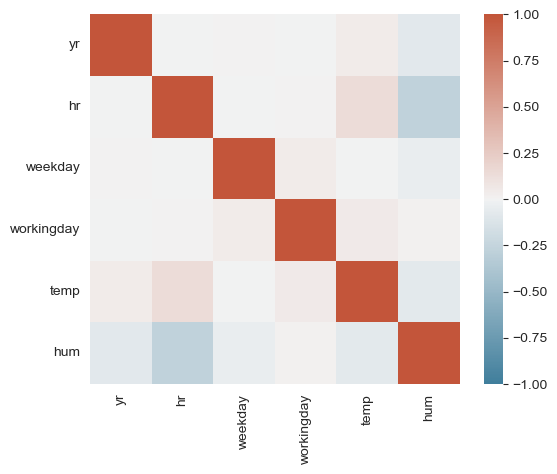

In [53]:
corr = trainBikes[['yr', 'hr', 'weekday', 'workingday', 'temp', 'hum']].corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap)

From the heatmap above, it can be estimated that the rest of the features do not have a significant correlation to each other.

### Target: Casual ###

The regression data needs to first be preprocessed, this includes creating x and y variables to hold the dependant and independant data.

In [54]:
# Select target to work with
y = trainBikes.casual.copy()
x = trainBikes.copy()
# Drop all targets from feature data
x.drop(["casual", "registered", "cnt"], axis=1, inplace=True)
# Initialize a linear regression model
model = LinearRegression()

The calculatePredictors() methods needs to be called now to take in the target and features and order them in descending order of r^2

In [55]:
scores = calculatePredictors(x, y)

['temp', 'workingday', 'hum', 'hr', 'yr', 'weekday', 'windspeed']
[0, 0.2147341219205865, 0.3205122349284786, 0.41209326654210565, 0.43826175946802315, 0.44885584329739325, 0.45044698475273814, 0.45044708012638035]


From the method above, it can be assumed that [temp, workingday, hum, hr] are the only worthwhile predictors for casual.
This is further explored in the following graph.

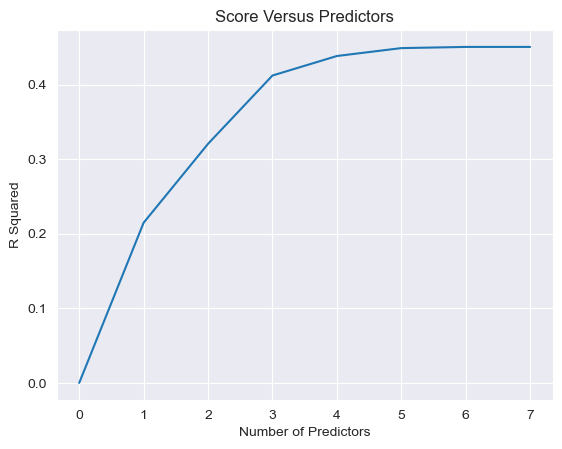

In [56]:
plt.title("Score Versus Predictors")
plt.xlabel('Number of Predictors')
plt.ylabel('R Squared')
plt.plot(scores)

Drop the rest of the columns that lack a strong enough r^2 value

In [57]:
x = x[['temp', 'workingday', 'hum', 'hr']]
model.fit(x, y)
model.score(x, y)

0.43826175946802315

The model now has a r^2 score of .44 but the trade-off is using 4 features to achieve this.

#### Regularisation ####
Perform regularisation on data and investigate results

In [58]:
scaler = preprocessing.StandardScaler()
scaledXArray = scaler.fit_transform(x)
scaledX = pd.DataFrame(scaledXArray, index=x.index, columns=x.columns)

In [59]:
model.fit(scaledX, y)
predictors = scaledX.columns
coef = pd.Series(model.coef_, predictors).sort_values()
coef

workingday   -15.804192
hum          -12.705627
hr             8.356001
temp          21.615804
dtype: float64

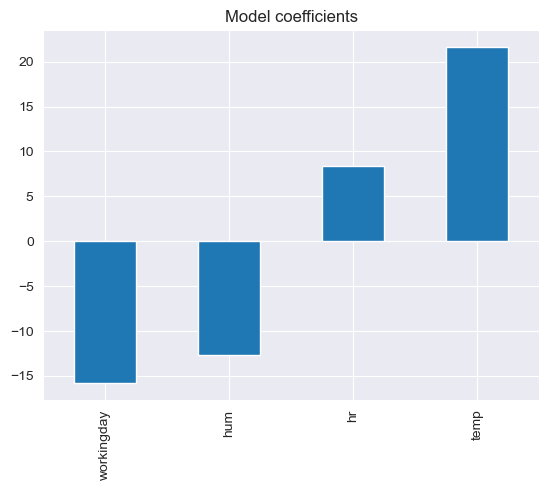

In [60]:
fig = coef.plot(kind="bar", title="Model coefficients")

In [61]:
ridgeReg = Ridge(alpha=100)
ridgeReg.fit(scaledX, y)
ridgeReg.score(scaledX, y)

0.4382432226765475

In [62]:
coef = pd.Series(ridgeReg.coef_,predictors).sort_values()
coef

workingday   -15.683968
hum          -12.632518
hr             8.336911
temp          21.462783
dtype: float64

Regularisation hasn't improved the variance much, this is most likely because the already existing variance is simply too small to be affected by low lambda level.
However, using higher lamda will greatly decrease the r^2 score, as such this will be treated as a dead end.

#### Continuation of feature investigation ####

In [63]:
model.fit(x, y)
model.score(x, y)

0.43826175946802315

##### Log #####

In [64]:
logX = x.copy()
logX[["temp"]] = logX[["temp"]].apply(np.log)
model.fit(logX, y)
model.score(logX, y)

0.4232282855119963

Using log on temp decreases the r^2 value, most likley a deadend.

##### sqrt #####

In [65]:
sqrtX = x.copy()
sqrtX = sqrtX.apply(np.sqrt)
model.fit(sqrtX, y)
model.score(sqrtX, y)

0.44221978294936604

Using sqrt on values increases r^2 slightly, but nothing significant, most likely a deadend.

##### replace bottom features ######

In [66]:
multipledX = x.copy()
multipledX = multipledX.assign(
    bigDaddy = lambda x: x.hr * x.workingday
)
multipledX.drop(columns=["temp", "hum", "hr", "workingday"], inplace=True)
model.fit(multipledX, y)
model.score(multipledX, y)

0.00413455712560884

Attempting to replace the 2 bottom features by using their multiplied value doesn't make much of a difference, most likely a deadend.

After all these deadends, 0.44 still seems too low of a model score, this needs to be investigated further.

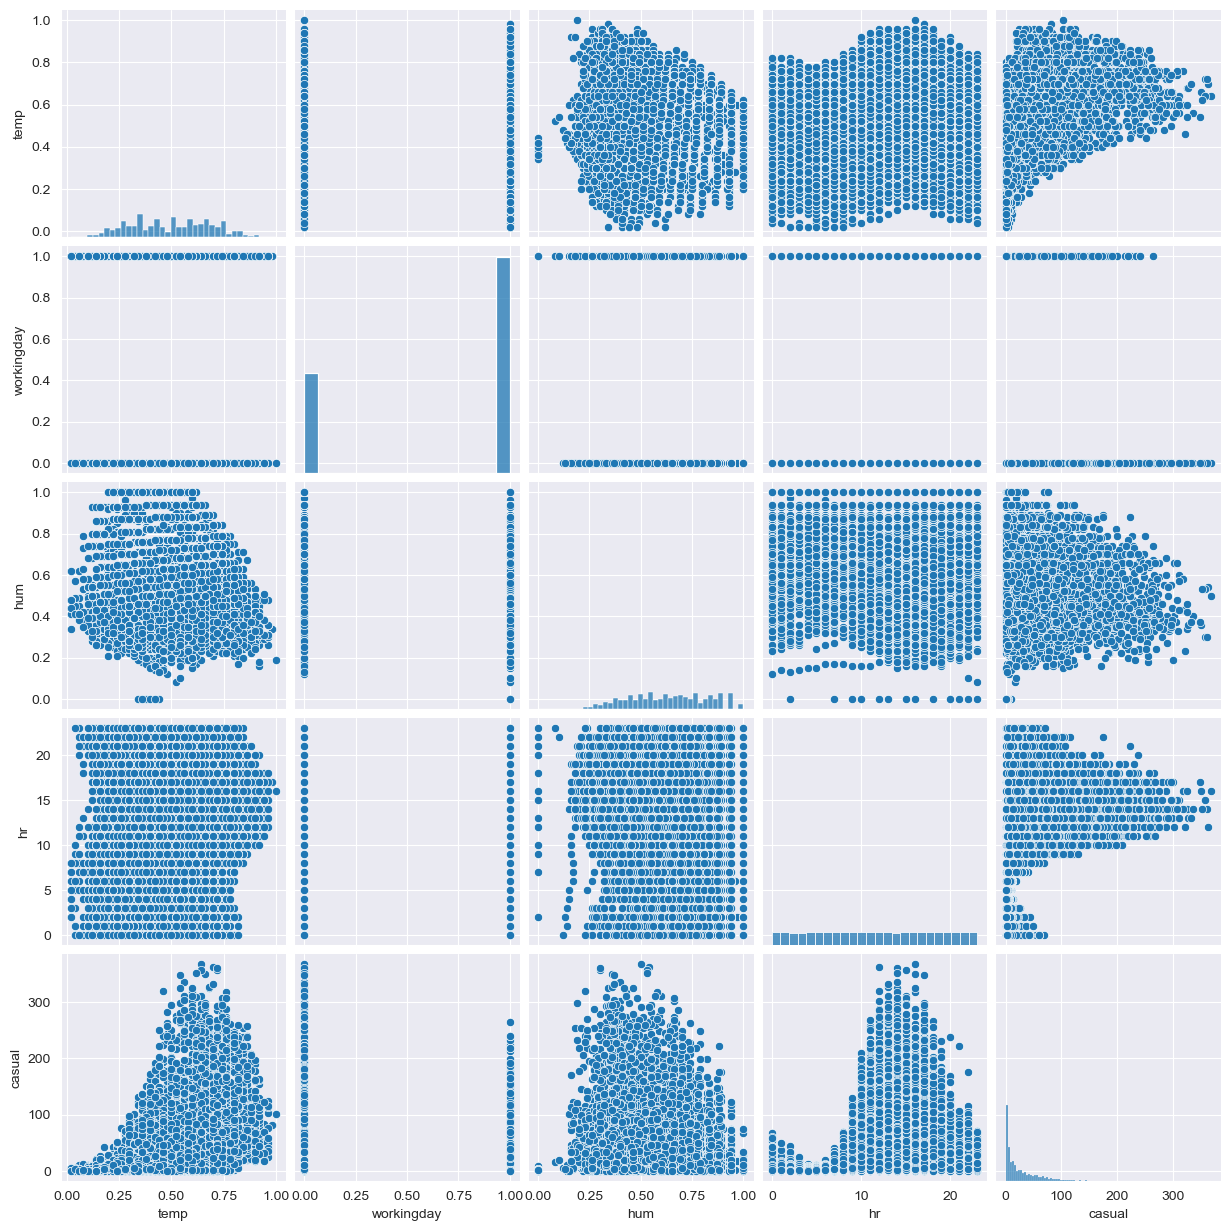

In [67]:
predictorsAndTarget = x.copy()
predictorsAndTarget["casual"] = y
sns.pairplot(predictorsAndTarget)

From the pairplot above, taking a closer look at the predictors relationship to casual, there is a chance that the data is not linear.
This means that a different model will need to be used for prediction.
A polynomial regression will be used instead.

The method below will create a polynomial model for different sizes of degrees and return their scores.

In [68]:
scores = calculatePolynomialScore(x, y)
print(scores)

[0.43826175946802315, 0.6038992186380672, 0.7124101601260886, 0.7740685170217065, 0.796029448688963, 0.8117269423900448, 0.8187596354913298, 0.822449714753126, 0.8210614079576353, 0.8257042082740064, 0.8202260772294394, 0.8158094418963534]


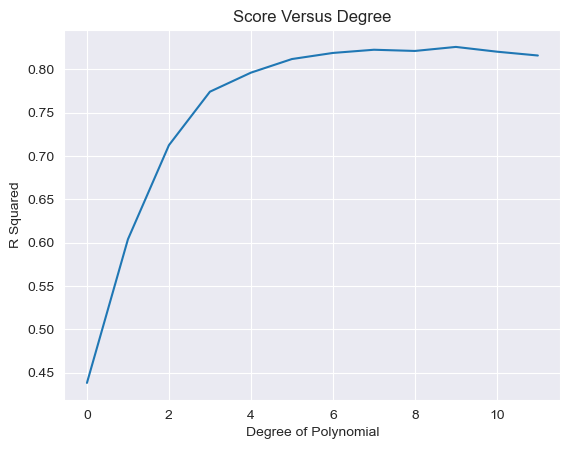

In [69]:
plt.title("Score Versus Degree")
plt.xlabel('Degree of Polynomial')
plt.ylabel('R Squared')
plt.plot(scores)

From the above scores and graph, it can be estimated that increasing the degree of the polynomial model also increasing the strenght of the regression.
That is until between degree of 8 and 12. The r^2 starts decreasing and increasing and as such, the degree has gone to far.
To get the most precise model, a degree of 6 or 7 should be used.  However, this precision comes at a performance hit.
A very similar precision can be achieved at a degree of 4 or 5, with minimal accuracy impact.
Before moving on, the current model will also be tested for different degrees of the polynomial modle.

This method will fit a polynomial regression model for different size of degree.
Then it will use that model to predict every value in the testBike set and compare against the actual values.
Lastly it will print the mean of the absolute difference between the two for each degree used.

In [73]:
scores = calculateDegrees(x, y, testBikes, ["temp", "workingday", "hum", "hr"])
print(scores)

[24.992249248261267, 20.368752215073133, 17.384634882993648, 14.645891441603391, 13.952389092271241, 13.023109749294035, 12.743127952218577, 12.424224247920858, 12.995174562670055, 12.232760281217729, 13.025434989597994, 13.077330652462726]


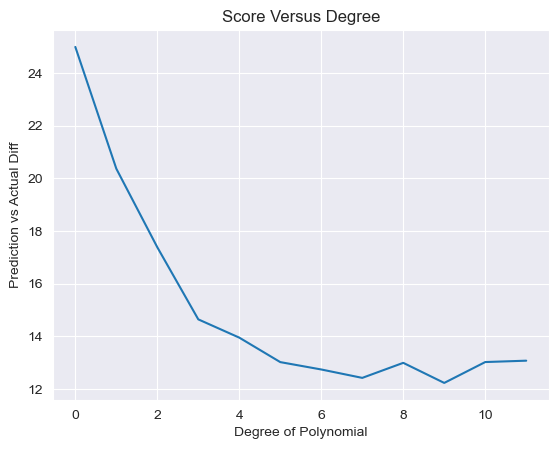

In [74]:
plt.title("Score Versus Degree")
plt.xlabel('Degree of Polynomial')
plt.ylabel('Prediction vs Actual Diff')
plt.plot(scores)

This further tests strenghtens the assumption made beforehand and once again estimates that the most accurate predicition is achieved at a degree of between 7 and 10, after which the accuracy starts decreasing.
Once again, there is minimal accuracy gain for a significant performance loss and as such a degree of 5 seems to be a more reasonable option.

In [75]:
# Create a polynomial model with degree of 5
poly = PolynomialFeatures(degree=5)
xPoly = poly.fit_transform(x)
model.fit(xPoly, y)
model.score(xPoly, y)

0.796029448688963

At the end of these tests we are left with a polynomial model with r^2 strenght of 80.

In [77]:
def getResiduals(test, predictors, model, polyModel):
    polyTest = test[predictors]
    polyTest = polyModel.fit_transform(polyTest)
    predict = model.predict(polyTest)
    actual = test.casual
    return actual - predict

residuals = getResiduals(testBikes, ['temp', 'workingday', 'hum', 'hr'], model, poly)
print(residuals)

16352    -3.225480
1047     -3.869969
573      -1.494726
3016    -35.948763
5695    -17.040909
           ...    
5353    -17.239414
2205    -10.234914
8849    -10.685540
7264      4.771397
3498    -58.546551
Name: casual, Length: 3476, dtype: float64


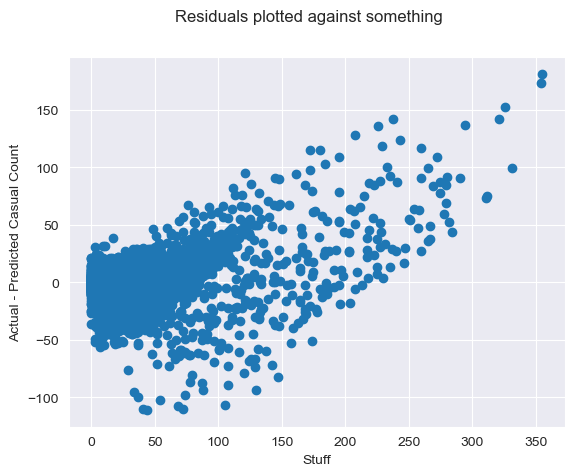

In [80]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(testBikes.casual, residuals)
fig.suptitle("Residuals plotted against something")
ax.set_ylabel("Actual - Predicted Casual Count")
ax.set_xlabel("Stuff")
ax.grid(True)

## End of Answer 3 ##

# Task 4: Which of the 3 target columns is easiest to predict accurately?

##Start of Answer 4##

##End of Answer 4##

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label

##Start of Answer 5##

##End of Answer 5##

# Task 6: Use _two_ classification procedures to predict these demand quartiles

##Start of Answer 6

##End of Answer 6##

# Task 7: Which of the two machine learning procedures provides the highest prediction accuracy on the test set?

##Start of Answer 7

##End of Answer 7##